In [1]:
#!pip install nimfa
#!pip install implicit

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import csv
#import pandasql as ps
import matplotlib.pyplot as plt
#import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy

#import torch
#import torch.nn as nn
#import torch.nn.parallel
#import torch.optim as optim
#import torch.utils.data

#from torch.nn import functional
#from torch.autograd import Variable

import statistics

#temporal pattern clustering
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from scipy.stats import chisquare
from scipy.stats import wasserstein_distance

#regression model
from patsy import dmatrices
#import statsmodels.api as sm

from datetime import datetime

#from pysal.model import spreg
#from pysal.lib import weights
#from pysal.explore import esda

#calculate the demographic bias 
#use wasserstein_distance
from scipy.stats import wasserstein_distance

#path = 'C:/Users/29700/Downloads/RecSys-Workshop/tutorials/'
#os.chdir(path)
#import utilities as utl

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mae
from datetime import datetime
import time
from sklearn.decomposition import NMF

import time
import scipy.sparse
from scipy.stats import entropy
from sys import exit

import itertools
from itertools import permutations

import xml.etree.ElementTree as ET

import geopandas as gpd

import copy 

import json

#binary factorization
import nimfa

from sklearn.decomposition import NMF
import scipy.sparse as sparse
import implicit

#extract number from str
import re

In [2]:
#process the fcd data
path = "G:/My Drive/2021/Bias/sumo_simulation/"
os.chdir(path)
#os.listdir()

raw_dt_path = []
for i in os.listdir():
    if len(i) == 12 and '2017' in i:
        raw_dt_path.append(i)
print(raw_dt_path)

['20170404.csv', '20170411.csv', '20170406.csv', '20170405.csv', '20170413.csv', '20170412.csv', '20170420.csv', '20170419.csv', '20170418.csv', '20170427.csv', '20170426.csv', '20170425.csv']


In [37]:
#read_csv
def get_data(raw_path, single_file=True):
    idx = 0
        
    if single_file == False:
        for path in raw_path:
            if idx == 0:
                dt = pd.read_csv(path)
                idx = 1
            else:
                dt_cur = pd.read_csv(path)
                dt = pd.concat([dt, dt_cur])
    else:
        dt = pd.read_csv(raw_path)
            
    get_hr = lambda x: int(x.split(':')[0])
    get_min = lambda x: int(x.split(':')[1])
    dt['hr'] = dt['time'].apply(get_hr)
    dt['min'] = dt['time'].apply(get_min)
    return(dt)

def get_time_variationbyzone(data, taz, time_loc, plot_index):
    data_taz = data[data['taz']==taz]
    data_taz = data_taz.sort_values(by=['hr', 'min'])
    data_taz = data_taz.groupby(by=['hr', 'min']).sum()
    
    data_taz.reset_index(inplace=True)
    data_taz = data_taz[['hr','min','sum']]
    #data_taz
    obs_sum = np.zeros((len(time_loc)))
    hr_ = data_taz['hr'].values
    min_ = data_taz['min'].values
    sum_val = data_taz['sum'].values
    
    for i in range(len(hr_)):
        obs_sum[time_loc[str(hr_[i])+'_'+str(min_[i])]] = sum_val[i]
    #use obs/max(obs) instead of obs/sum(obs) 
    obs_per = obs_sum/(np.max(obs_sum))
    
    if plot_index == True:
        fig = plt.figure(taz)
        plt.plot(obs_sum)
    return(obs_per)

def get_sim_obs_ts(fcd_out, taz_time_per, avg_per, return_sim=True):
    taz_ = fcd_out['taz'].values
    time_5 = fcd_out['time_5'].values
    per_ts = []
    for i in range(len(taz_)):
        if taz_[i] in taz_time_per:
            per_ts.append(taz_time_per[taz_[i]][time_5[i]])
        else:
            per_ts.append(avg_per[time_5[i]])
    if return_sim == True:
        sim_obs_ts = [] 
        for i in range(len(per_ts)):
            sim_obs_ts.append(np.random.binomial(1, per_ts[i], 1)[0])
        return(sim_obs_ts)
    else:
        return(per_ts)
    

#convert dt to matrix
def read_fcd(fcd_dt_path, app_based_data):
    fcd_out = pd.read_csv(fcd_dt_path, header=None)
    fcd_out.columns = ['id', 'taz', 'time']
    fcd_out.taz = fcd_out.taz.astype('int')
    
    
    revise_dt = lambda x: x.split('-')[0] if '-' in x else x
    get_sample_index = lambda x: x.split('-')[2] if '-' in x else 3
    fcd_out['reids'] = fcd_out['id'].apply(revise_dt)
    fcd_out['sample_index'] = (fcd_out['id'].apply(get_sample_index)).astype(int)
    
    fcd_out['time'] = fcd_out['time'].astype('int')
    fcd_out['hr'] = (fcd_out['time'].values/3600).astype(int)
    fcd_out['minus'] = ((fcd_out['time'].values- fcd_out['hr'].values*3600)/60).astype(int)
    fcd_out['time_30'] = (fcd_out['time']/30).astype(int)
    fcd_out['time_5'] = (fcd_out['time']/300).astype(int)
    
    print('num id', len(np.unique(fcd_out.reids)))

    #fcd_out.sort_values(by=['time', 'taz'])
    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+(fcd_out['time_5']).astype(str)

    time_ = np.unique((fcd_out['time']/300).astype(int))
    
    if app_based_data == True:
        #sample index 0: non app-based samples, 1: app=based samples, 3: transit
        #fcd_out.groupby(by=['sample_index']).size()
        #sample_index 0    1714901, 1     572267, 3     180802
        return(fcd_out[fcd_out['sample_index']!=0])
    else:
        return(fcd_out)
    
def getfcdnorigindt(fcd_out, savepath, 
                    data_obs, time_loc, taz_time_per, avg_per, 
                    save_index):
    #get one day data (use 5 min as the time interval)
    #fcd_out = fcd_out[fcd_out['time_5']<288]
    newuser_ = {}
    index_ = 0
    for i in np.unique(fcd_out.reids):
        newuser_[i] = index_
        index_ += 1    
    ## fcd output processing
    #delete the data exceeds the 24-hr daily period
    #fcd_out = fcd_out[~fcd_out['time'].isin([86400, 86700])]
    fcd_out.time = fcd_out.time.astype('int')

    obs = data_obs.groupby(by=['time']).size().values
    obs_per = obs/max(obs)

    sample_ct = lambda x: np.random.binomial(1, obs_per[x], 1)[0]

    fcd_out['sim_obs'] = fcd_out['time_5'].apply(sample_ct)

    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+((fcd_out['time']/300).astype(int)).astype(str)
    
    sim_obs = get_sim_obs_ts(fcd_out, taz_time_per, avg_per, True)
    fcd_out['sim_obs_ts'] = sim_obs

    #simulated observations based on time variation
    print('sim based on time', 
          np.count_nonzero(fcd_out['sim_obs'])/fcd_out.shape[0])

    #simulated observations based on time and spatial variation
    print('sim based on time and spatial',
          np.count_nonzero(fcd_out['sim_obs_ts'])/fcd_out.shape[0])
    
    return(fcd_out)

#fcd_out = read_fcd(fcd_dt_path, app_based_data)
def run_sim(csv_path, fcd_out, savepath, save_index=False, plot_index=True):
    data_obs = pd.read_csv(csv_path, header=0)
    print('app based data', data_obs.head(3))
    
    newids = np.unique(data_obs.newid)
    newid_ = {}
    index_ = 0
    for i in range(len(newids)):
        newid_[newids[i]] = index_
        index_ += 1
        
    get_hr = lambda x: x.split(':')[0]
    get_min = lambda x: x.split(':')[1]

    hr_ = np.unique(data_obs['time'].astype(str).apply(get_hr).astype(int))
    min_ = np.unique(data_obs['time'].astype(str).apply(get_min).astype(int))
    taz_ = np.unique(data_obs['taz'])

    data_obs['hr'] = data_obs['time'].astype(str).apply(get_hr).astype(int)
    data_obs['min'] = data_obs['time'].astype(str).apply(get_min).astype(int)
    
    index_ = 0
    lt_loc = {}
    for taz in taz_:
        for h in hr_:
            for m in min_:
                lt_loc['4_'+str(h)+'_'+str(m)+'_'+str(taz)] = index_
                index_ += 1
    obs_mx = np.zeros((len(newid_), len(lt_loc)))

    newid_col = data_obs.newid.values
    key_col = data_obs.key.values
    ct_col = data_obs['sum'].values

    for i in range(len(newid_col)):
        obs_mx[newid_[newid_col[i]]][lt_loc[key_col[i]]] = 1

    total_ct = np.sum(obs_mx, axis=0)
    #get ct based on taz and time
    total_ct = total_ct.reshape(1, total_ct.shape[0])
    total_ct_conver = np.hsplit(total_ct, len(taz_))
    max_num = np.max(np.array(total_ct_conver), axis=2)
    
    if plot_index == True:
        plt.plot(data_obs.groupby(by=['time']).size().values)
        
    time_loc = {}
    index_ = 0
    for hr in hr_:
        for miuts in min_:
            time_loc[str(hr)+'_'+str(miuts)] = index_
            index_ += 1

    taz_time_per = {}
    avg_per = 0
    index_ = 0 
    for taz_id in taz_:
        taz_time_per[taz_id] = get_time_variationbyzone(data_obs, taz_id, time_loc, plot_index)
        if index_ == 0:
            avg_per = taz_time_per[taz_id]
        else:
            avg_per = avg_per + taz_time_per[taz_id]
        index_ += 1
        
    avg_per = avg_per/np.max(avg_per)
    if plot_index == True:
        fig = plt.figure(1)
        plt.plot(avg_per)
        
    
    fcd_out = getfcdnorigindt(fcd_out, savepath, data_obs, time_loc, taz_time_per, avg_per, save_index=False)
    
    fcd_out['obs'] = 1
    #simulation compare
    print('sim_t vs sim_ts', mean_squared_error(fcd_out.sim_obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_ts', mean_squared_error(fcd_out.obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_t', mean_squared_error(fcd_out.obs, fcd_out.sim_obs, squared=False))
    
    return(fcd_out)   


def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def get_maxvalnindex(WHpert):
    max_val = np.max(WHpert, axis=1)
    max_index = np.argmax(WHpert, axis=1)
    return(max_val, max_index)

def get_pred_dt(WH_pred, time_interval):
    num_taz = int(WH_pred.shape[1]/time_interval)
    #print('num taz', num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T)  


def get_simdt(fcd_out, sim_col, newuser_, loc_time):
    sim_dt = np.zeros((len(newuser_), len(loc_time)))
    fcd_obs = fcd_out[['reids', 'tl_id', 'sim_obs']].groupby(by=['reids', 'tl_id']).sum()
    fcd_obs.reset_index(inplace=True) 
    ids_ = fcd_obs['reids'].values
    tl_id_ = fcd_obs['tl_id'].values
    sim_obs = fcd_obs['sim_obs'].values
    for i in range(len(ids_)):
        sim_dt[newuser_[ids_[i]]][loc_time[tl_id_[i]]] = sim_obs[i]
    return(sim_dt)

def fit_dt(fcd_out, sim_col, newuser_, loc_time, k_val): 
    sim_dt = get_simdt(fcd_out, sim_col, newuser_, loc_time)
    #predict data based on time
    model = NMF(n_components=k_val, init='random', random_state=0)
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def get_index_lst(i, num_taz, num_time):
    return(list(np.arange(i, (num_time-1)*num_taz+i, num_time)))

#sep_dict = {'mor':[6, 9]
#            'noon':[9, 17]
#            'eve':[17, 20]}
def sep_indexdetime(num_taz, num_time, time_interval):
    sep_time = {'mor':[],
               'noon':[],
               'eve':[],
               'other':[]}
    for i in range(num_time):
        if i>=6*time_interval and i < 9*time_interval:
            sep_time['mor'].extend(get_index_lst(i, num_taz, num_time))
        elif i >= 9*time_interval and i < 17*time_interval:
            sep_time['noon'].extend(get_index_lst(i, num_taz, num_time))
        elif i>17*time_interval and i <20*time_interval:
            sep_time['eve'].extend(get_index_lst(i, num_taz, num_time))
        else:
            sep_time['other'].extend(get_index_lst(i, num_taz, num_time))
            
    for key in sep_time:
        sep_time[key] = sorted(sep_time[key])
    return(sep_time)

def fit_dtbytime(sim_dt, num_taz, num_time, time_interval, k_val, save_name):
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', random_state=0)
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt_time(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')

def del_transit_oneobs(fcd_out):
    fcd_transit = fcd_out[fcd_out['sample_index']==3]
    fcd_transit = fcd_transit.groupby(by=['id']).size().to_frame()
    fcd_transit.reset_index(inplace=True)
    fcd_transit_ids = fcd_transit[['id']][fcd_transit[0]==1].values.flatten()
    #print(fcd_transit_ids)
    print('# o ftransit line with only one obs deleted', len(fcd_transit_ids))
    return(fcd_out[~fcd_out['id'].isin(fcd_transit_ids)])

def get_test_dt(fcd_out, selected_ids):
    fcd_test = (fcd_out[fcd_out['reids'].isin(selected_ids)]).sort_values(by=['reids', 'time_30'])
    fcd_test['od_taz'] = fcd_test['otaz'].astype(str)+'_'+fcd_test['dtaz'].astype(str)
    fcd_test = fcd_test.sort_values(by=['reids', 'time_30'])
    return(fcd_test)

def get_other_stay_od(fcd_ids):
    fcd_ids['otaz'] = fcd_ids['taz']
    fcd_ids['dtaz'] = fcd_ids[['taz']].shift(periods=-1, fill_value=fcd_ids['otaz'].values[-1])
    fcd_ids['od_taz'] = fcd_ids['otaz'].astype(str)+'_'+fcd_ids['dtaz'].astype(str)
    return(fcd_ids)

def get_stay_val(fcd_test, ids, other_index):
    fcd_ids = fcd_test[fcd_test['reids']==ids]
    if other_index == True:
        fcd_ids = get_other_stay_od(fcd_ids)

    fcd_index = fcd_ids.groupby(by=['od_taz', 'otaz','dtaz','time_5_new'], sort=False).size().to_frame()
    fcd_index.reset_index(inplace=True)
    fcd_index = fcd_index.sort_values(by=['time_5_new'])

    fcd_index['time_diff'] = fcd_index[['time_5_new']] - (fcd_index[['time_5_new']].shift(periods=1, fill_value=0))
    fcd_index['time_diff_index'] = fcd_index['time_diff']>1

    start_t = 0
    time_ = []
    taz_ = []
    first_index = False

    for i in range(fcd_index.shape[0]):
        #handle special condition, when the first index = 1
        if i == 0 and fcd_index.iloc[i, 5] == 1:
            first_index = True
        if fcd_index.iloc[i, 6] == True or first_index==True:
            add_time = np.arange(start_t, fcd_index.iloc[i, 3])
            time_.extend(add_time)
            taz_.extend(np.repeat(fcd_index.iloc[i, 1], len(add_time)))

        start_t = fcd_index.iloc[i, 3]+1

    if start_t-1 < 287:
        add_time = np.arange(start_t, 288)
        time_.extend(add_time)
        taz_.extend(np.repeat(fcd_index.iloc[i, 2], len(add_time)))
        
    return(np.vstack((np.repeat(ids, len(time_)), time_, taz_)))

def get_stays_mx(fcd_dt, selected_ids, other_index=False):
    fcd_test = get_test_dt(fcd_dt, selected_ids)
    index_ = 0
    for ids in np.unique(fcd_test['reids']):
        if index_ == 0:
            add_stay = get_stay_val(fcd_test, ids, other_index)
            index_ = 1
        else:
            add_stay_cur = get_stay_val(fcd_test, ids, other_index)
            add_stay = np.hstack((add_stay, add_stay_cur))
            
    return(add_stay.T)

#check add stay function
def add_stay_check(add_stay, selected_ids, fcd_out):
    #get fcd trip num based on the time
    fcd_trip_num = (fcd_out.sort_values(by=['reids', 'time_30'])).groupby(by=['reids', 'time_5'], sort=False).size().to_frame()
    fcd_trip_num.reset_index(inplace=True)
    fcd_trip_num = fcd_trip_num.groupby(by=['reids'], sort=False).size().to_frame()
    fcd_trip_num.reset_index(inplace=True)
    
    test = pd.DataFrame(add_stay)
    test.columns = ['reids', 'taz', 'time_5']
    test = test.groupby(by=['reids']).size().to_frame()
    test.columns = ['stay_num']
    test = test.join((fcd_trip_num[fcd_trip_num['reids'].isin(selected_ids)]).set_index('reids'))
    test.reset_index(inplace=True)
    test = test[~(test['reids'].isin(stays_[0].values))]
    test.columns = ['reids','stay_num', 'trip_num']
    test['total'] = test['stay_num']+test['trip_num']
    print(test['total'].describe())
    return(test[test['total']!=288])

#add ids with stays only
#time = np.range(0, 288)
def get_stays(stays_dt):
    for i in range(stays_dt.shape[0]):
        ids = stays_dt.iloc[i, 0]
        taz = stays_dt.iloc[i, 1]
        if i == 0 :
            stays = np.vstack((np.repeat(ids, 288),
                               np.arange(0, 288),
                               np.repeat(taz, 288)))
        else:
            stays = np.hstack((stays, np.vstack((np.repeat(ids, 288),
                                                 np.arange(0, 288),
                                                 np.repeat(taz, 288)))))
        
    return(stays.T)

def add_index(index_val, stay_mx):
    add_index = np.repeat(index_val, stay_mx.shape[0]).reshape(stay_mx.shape[0], 1)
    return(np.hstack((stay_mx, add_index)))

def join_dt(add_mx, colname, index_val):
    add_mx = add_index(index_val, add_mx)
    join_dt = pd.DataFrame(add_mx)
    join_dt.columns = colname
    return(join_dt)
    

#colname = ['reids', 'time_5', 'taz'], indexcol = 'col_index'
def get_filled_dt(stay, add_stay, add_stay_other, fcd_out, colname, indexcol):
    #add index to distinguish the filled dt
    fcd_dt = fcd_out[colname]
    fcd_dt[indexcol] = 3
    colname.append(indexcol)
    
    #add add stays
    fcd_dt = pd.concat([fcd_dt, join_dt(add_stay, colname, 0)])
    #add add other stays
    fcd_dt = pd.concat([fcd_dt, join_dt(add_stay_other, colname, 1)])
    #add stays only
    fcd_dt = pd.concat([fcd_dt, join_dt(stay, colname, 2)])
    
    return(fcd_dt.sort_values(by=['reids', 'time_5_new']))

def conver2mx(test_taz_time, taz_dict):
    time_len = len(np.unique(test_taz_time['minut_5']))
    taz_len = len(taz_dict)
    output_mx = np.zeros((taz_len, time_len))
    taz_val = test_taz_time.taz.values
    time_val = test_taz_time.minut_5.values
    num_val = test_taz_time[0].values 
    for i in range(test_taz_time.shape[0]):
        output_mx[taz_val[i]][time_val[i]] = num_val[i]
    return(output_mx)

def cal_time_taz_per(test_taz, test_taz_time, taz_dict):
    output_per = conver2mx(test_taz_time, taz_dict)
    print(output_per.shape)
    taz_ = test_taz_.taz.values
    num_ids = test_taz_[0].values
    
    missing_taz = []
    for i in range(output_per.shape[0]):
        if i in taz_:
            output_per[i, :] = output_per[i, :]/(num_ids[np.where(taz_==167)[0][0]])
        else:
            missing_taz.append(i)
    print('# of missing tazs', len(missing_taz))
    #add average data to the tazs without data info
    mean_per = np.sum(output_per, axis=0)/(len(taz_)-len(missing_taz))
    for i in missing_taz:
        output_per[i,:] = mean_per
    return(output_per)

#######
#get the simulated observed data
def check_fcd_dt(fcd_dt):
    fcd_colname = fcd_dt.columns
    id_dict = {}
    index_ = 0
    for i in np.unique(fcd_dt['reids']):
        if i not in id_dict:
            id_dict[i] = index_
            index_ += 1

    get_id_index = lambda x: id_dict[x]        
    fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
    if 'ts_index' not in fcd_colname:
        fcd_dt['ts_index'] = fcd_dt['taz_index']*288 + fcd_dt['time_5_new']
    return(fcd_dt)

#get the simulated observed data
def getinput_mx(fcd_dt, sim_col):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    fcd_val = check_fcd_dt(fcd_val)
    #fcd_dt['ts_index'] = fcd_dt['taz_index']*288+fcd_dt['time_5_new'] 

    fcd_val = check_fcd_dt(fcd_val)
    input_mx = np.zeros((len(np.unique(fcd_val['reids'])),
                         len(np.unique(fcd_val['time_5_new']))*len(np.unique(fcd_val['taz_index']))))
   # print(input_mx.shape)
    
    vals = fcd_val[sim_col].values
    rows = fcd_val['id_index'].values
    cols = fcd_val['ts_index'].values
    for i in range(len(vals)):
        input_mx[rows[i], cols[i]] = vals[i]        
    return(input_mx)

def fit_dt01(fcd_dt, sim_col, k_val): 
    sim_dt = getinput_mx(fcd_dt, sim_col)
    #predict data based on time
    #for 0 and 1
    model = NMF(n_components=k_val, init='random', 
                random_state=0, solver='cd', 
                beta_loss='binary_reconstruction')
    
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def fit_dtbytime_stay01(fcd_dt, sim_col, time_interval, k_val, save_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', 
                    random_state=0, solver='cd', 
                    beta_loss='binary_reconstruction')
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt_time(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_stay_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index_stay_'+ky+'_'+save_name+'.csv')
    print('predtion based on time done')

def fit_dt(fcd_dt, sim_col, k_val): 
    sim_dt = getinput_mx(fcd_dt, sim_col)
    #predict data based on time
    #for 0 and 1
    model = NMF(n_components=k_val, init='random', random_state=0)
    
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def fit_dtbytime_stay(fcd_dt, sim_col, time_interval, k_val, save_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', random_state=0)
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_stay_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index_stay_'+ky+'_'+save_name+'.csv')
    print('predtion based on time done')

#get time loc
#time_interval = 288
#num_taz = int(WH_ts.shape[1]/time_interval)

def get_timeloc(num_taz, time_interval, t):
    select_time_loc = []
    for i in range(num_taz):
        select_time_loc.append(time_interval*i+t)
    return(select_time_loc)

def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def get_maxvalnindex(WHpert):
    max_val = np.max(WHpert, axis=1)
    max_index = np.argmax(WHpert, axis=1)
    return(max_val, max_index)


def get_pred_dt_time(WH_pred, time_interval):
    num_taz = int(WH_pred.shape[1]/time_interval)
    print('num taz', num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T)  

In [38]:
def get_idx_dict(idx_val):
    idx = 0
    idx_dict = {}
    for i in idx_val:
        if i not in idx_dict:
            idx_dict[i] = idx
            idx += 1
    return(idx_dict)

def get_dt_idx(idx_col, dt, idx_dict):
    get_idx = lambda x: idx_dict[x]
    dt[idx_col+'_idx'] = dt[idx_col].apply(get_idx)
    return(dt)

def get_time_idx(dt, time_col):
    get_hr = lambda x: int(x.split(':')[0])
    get_min = lambda x: int(x.split(':')[1])
    
    dt[time_col+'_idx'] = (dt[time_col].apply(get_hr)*12+dt[time_col].apply(get_min)/5).astype(int)
    return(dt)

def convert2matrix(dt, time_range):
    newids = np.unique(dt['newid'])
    newid_dict = get_idx_dict(newids) 
    dt = get_dt_idx('newid', dt, newid_dict)
    
    taz =  np.unique(dt['taz'])
    taz_dict = get_idx_dict(taz)
    dt = get_dt_idx('taz', dt, taz_dict)
    
    dt = get_time_idx(dt, 'time')
    
    dt['lt_idx'] = (dt['taz_idx']*time_range+dt['time_idx']).astype(int)
    
    arr = np.zeros((len(newids), len(taz) * time_range))
    
    lt_idx = dt['lt_idx'].values
    newid_idx = dt['newid_idx'].values
    
    for i in range(dt.shape[0]):
        arr[newid_idx[i], lt_idx[i]] = 1
    return(arr)  

def get_timeloc(num_taz, time_interval, t):
    select_time_loc = []
    for i in range(num_taz):
        select_time_loc.append(time_interval*i+t)
    return(select_time_loc)

def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def convert_timedic2mx(time_dict):
    #dataDict = {'device1':(1,1,0,1), 'device2':(0,1,0,1), 'device3':(1,0,0,1)}
    #orderedNames = ['device1','device2','device3']
    times = list(time_dict.keys())
    dataMatrix = np.array([time_dict[i] for i in times])
    return(dataMatrix)

def get_missing_rate(time_index_mx, input_mx_indi):
    indi_m = input_mx_indi[time_index_mx]
    return(np.count_nonzero(np.sum(indi_m,axis=1))/(indi_m.shape[0]))


def check_missings(dt, time_range, plot_idx=True):
    input_mx = convert2matrix(dt, time_range)
    num_taz = int(input_mx.shape[1]/time_range)
    #print('num taz', num_taz)
    time_dic = get_pred_timedict(num_taz, time_range)
    time_mx = convert_timedic2mx(time_dic)
    missing_rate = []
    for i in range(input_mx.shape[0]):
        missing_rate.append(get_missing_rate(time_mx, input_mx[i,]))
        #print(missing_rate)
    if plot_idx == True:
        plt.hist(missing_rate)
        plt.title('hist of non-missing rate')
        plt.xlabel('non-missing rate')
        plt.ylabel('# of ids')
        print(max(missing_rate))
        print(min(missing_rate))
    return(np.array(missing_rate))

In [5]:
#app_based_test_dt = get_data(raw_dt_path[0], True)
#missing_info = check_missings(app_based_test_dt, 288)

#use the census tract
path = 'G:/My Drive/2021/Bias/'
#save matrice
#np.savetxt('test_matrice_reverse.csv', test_matrice_reverse, delimiter=",")
#np.savetxt('Zero_index.csv', Zero_index, delimiter=",")

#read the test matrice and data
test_matrice_reverse = pd.read_csv(path+'test_matrice_reverse.csv', header=None).to_numpy()
Zero_index = pd.read_csv(path+'Zero_index.csv', header=None).to_numpy()
#Seattle_ct = pd.read_csv('G:/My Drive/2021/Bias/census_tract_process/Seattle_ct.csv')
#geoids = np.unique(Seattle_ct.GEOID10)
newids = test_matrice_reverse[:, 0]

test_matrice_reverse = test_matrice_reverse[:, 1:]

def check_missings_mx(input_mx, time_interval, plot_idx=True):
    num_taz = int(input_mx.shape[1]/time_interval)
    #print('num taz', num_taz)
    time_dic = get_pred_timedict(num_taz, time_interval)
    time_mx = convert_timedic2mx(time_dic)
    missing_rate = []
    for i in range(input_mx.shape[0]):
        missing_rate.append(get_missing_rate(time_mx, input_mx[i,]))
        #print(missing_rate)
    if plot_idx == True:
        plt.hist(missing_rate)
        plt.title('hist of non-missing rate')
        plt.xlabel('non-missing rate')
        plt.ylabel('# of ids')
        print(max(missing_rate))
        print(min(missing_rate))
    return(np.array(missing_rate))

missing_sum = check_missings_mx(test_matrice_reverse, 288, False)
missing_sum  = pd.DataFrame(missing_sum)
missing_sum[0].describe()

count    7767.000000
mean        0.050230
std         0.076175
min         0.003472
25%         0.006944
50%         0.020833
75%         0.059028
max         0.968750
Name: 0, dtype: float64

### NMF test without zero loss

In [48]:
#no ground truth to check 
def fit_process_dt_mf01(dt, time_range, missing_info, 
                        missing_val, k_val, model_name, input_matrix): 
    #convert data into matrix
    result_para = []
    if input_matrix == False:
        test_dt = convert2matrix(dt, time_range)
    else:
        test_dt = dt
    fit_dt = test_dt[np.where(missing_info>=missing_val)[0],]
    svd_idx = 0
    
    #predict data based on missing_rate
    if  model_name == 'NMF':
        model = NMF(n_components=k_val, init='random', random_state=0,
                   beta_loss='kullback-leibler', solver='mu')
        W = model.fit_transform(fit_dt)
        H = model.components_

    if model_name == 'BMF':
        #some of the parameters may be reconducted
        #seed = 'nndsvd'
        model = nimfa.Bmf(fit_dt, rank=k_val, max_iter=1000, lambda_w=1.1, lambda_h=1.1)
        model_fit = model()
        
        W = model_fit.fit.W
        H = model_fit.fit.H
        
    if model_name == 'SVD':
        u, s, v = svds(fit_dt, k=k_val)
        svd_idx = 1
        
    if svd_idx == 1:
        pred_dt = u @ np.diag(s) @ v
        print('if pred & fit dt is equal, with tol=0.01:', 
              np.allclose(pred_dt, fit_dt, atol=1e-2))
        
        model_rmse = mean_squared_error(fit_dt, pred_dt, squared=False)
        #model_rmse_tru = mean_squared_error(fit_dt_tru, pred_dt, squared=False)

        print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+',', model_rmse)

        WH_max, WH_index = get_pred_dt(pred_dt, 288)
        ori_miss_per, mitigate_miss_per = check_pred_index(fit_dt, WH_index)

        result_para = [model_rmse, ori_miss_per, mitigate_miss_per]    

        del(u, s, v, pred_dt)
        return(result_para)
    
    else:
        #check if the model fit the data well    
        if True in np.isnan(W) or True in np.isnan(H):
            print('Error, fitting data failed')
            del(W, H)
            return([0,0,0,0])

        else:
            pred_dt = np.dot(W, H)
            pred_dt = np.array(pred_dt)

            model_rmse = mean_squared_error(fit_dt, pred_dt, squared=False)

            print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+',', model_rmse)

            WH_max, WH_index = get_pred_dt(pred_dt, 288)
            ori_miss_per, mitigate_miss_per = check_pred_index(fit_dt, WH_index)

            result_para = [model_rmse,  ori_miss_per, mitigate_miss_per]    

            del(W, H, pred_dt)
            return(result_para)
    
#para_lst_nmf = [k_val, alpha_W, alpha_H, l1_ratio]
#para_lst_bmf = [k_val, lambda_w, lambda_h]  
#for BMF and NMF
def fit_process_dt_mf01_sensitive(dt, time_range, 
                      missing_info, missing_val, 
                      model_name, para_lst, input_matrix): 
    #convert data into matrix
    result_para = []
    if input_matrix==False:
        test_dt = convert2matrix(dt, time_range)
    else:
        test_dt = dt
    fit_dt = test_dt[np.where(missing_info>=missing_val)[0],]
    
    #predict data based on missing_rate
    if  model_name == 'NMF':
        #para_lst = [k_val, alpha_W, alpha_H, l1_ratio]
        model = NMF(n_components = para_lst[0], init='random', random_state=0,
                   alpha_W = para_lst[1], alpha_H = para_lst[2],
                   l1_ratio = para_lst[3], beta_loss='kullback-leibler',
                   solver='mu')
        W = model.fit_transform(fit_dt)
        H = model.components_

    if model_name == 'BMF':
        #some of the parameters may be reconducted
        #seed = 'nndsvd'
        #para_lst = [k_val, lambda_w, lambda_h]
        model = nimfa.Bmf(fit_dt, rank=para_lst[0], max_iter=1000, 
                          lambda_w=para_lst[1], lambda_h=para_lst[2])
        model_fit = model()
        
        W = model_fit.fit.W
        H = model_fit.fit.H
        
    #check if the model fit the data well    
    if True in np.isnan(W) or True in np.isnan(H):
        print('Error, fitting data failed')
        del(W, H)
        return([0,0,0,0])
        
    else:
        pred_dt = np.dot(W, H)
        pred_dt = np.array(pred_dt)
    
        model_rmse = mean_squared_error(fit_dt, pred_dt, squared=False)

        print('RMSE, data with missing rate>='+str(missing_val)+', para='+str(para_lst)+',', model_rmse)

        WH_max, WH_index = get_pred_dt(pred_dt, 288)
        ori_miss_per, mitigate_miss_per = check_pred_index(fit_dt, WH_index)

        result_para = [model_rmse, ori_miss_per, mitigate_miss_per]    

        del(W, H, pred_dt)
        return(result_para)


#para_lst_nmf = [k_val, alpha_W, alpha_H, l1_ratio]
#para_lst_bmf = [k_val, lambda_w, lambda_h]    
def fit_dtbytime_sensitive(dt, missing_info, missing_val, 
                           time_interval, model_name, para_lst, input_matrix):
    
    if input_matrix == False:
        num_taz = len(np.unique(dt['taz_idx']))
        num_time = len(np.unique(dt['time_idx']))
        test_dt = convert2matrix(dt, num_time)
    else:
        test_dt = dt
        num_time = 288
        num_taz = int(dt.shape[1]/num_time)
    
    #predict data based on missing_rate
    
    fit_dt = test_dt[np.where(missing_info>=missing_val)[0],]
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    
    null_idx = 0
    result_para = {}
    svd_idx = 0
    for ky in time_dict:
        result_para[ky] = []
        #print(ky)
        input_dt = fit_dt[:, time_dict[ky]]
        if model_name == 'NMF':
            #para_lst_nmf = [k_val, alpha_W, alpha_H, l1_ratio]
            model = NMF(n_components = para_lst[0], init='random', 
                        random_state=0,
                        alpha_W = para_lst[1], alpha_H = para_lst[2],
                        l1_ratio = para_lst[3], beta_loss='kullback-leibler', solver='mu')
            #model = NMF(n_components=k_val, init='random', random_state=0)
            W = model.fit_transform(input_dt)
            H = model.components_
            
        if model_name == 'BMF':
            #some of the parameters may be reconducted
            #seed = 'nndsvd'
            #para_lst = [k_val, lambda_w, lambda_h]
            model = nimfa.Bmf(input_dt, rank=para_lst[0], max_iter=1000, 
                              lambda_w=para_lst[1], lambda_h=para_lst[2])
            #model = nimfa.Bmf(input_dt, rank=k_val, max_iter=1000, lambda_w=1.1, lambda_h=1.1)
            model_fit = model()

            W = model_fit.fit.W
            H = model_fit.fit.H
            
        if model_name == 'SVD':
            u, s, v = svds(fit_dt, k=k_val)
            svd_idx = 1
        
        if svd_idx == 1:
            pred_dt = u @ np.diag(s) @ v
            print('if pred & fit dt is equal, with tol=0.01:', 
                  np.allclose(pred_dt, fit_dt, atol=1e-2))

            model_rmse = mean_squared_error(fit_dt, pred_dt, squared=False)
            #model_rmse_tru = mean_squared_error(fit_dt_tru, pred_dt, squared=False)

            print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+',', model_rmse)

            WH_max, WH_index = get_pred_dt(pred_dt, 288)

        else:
            if True in np.isnan(W) or True in np.isnan(H):
                print('Error, fitting data failed')
                null_idx = 1
                del(W, H)
                result_para[ky] = [0,0,0,0]

            else:
                #print(WH.shape)
                pred_dt = np.dot(W, H)
                pred_dt = np.array(pred_dt)

                WH_max, WH_index = get_pred_dt_time(pred_dt, num_taz)
                #print(WH_max.shape, WH_index.shape)

        model_rmse = mean_squared_error(input_dt, pred_dt, squared=False)

        print('RMSE, data with missing rate>='+str(missing_val)+', para='+str(para_lst)+','+ky+',', model_rmse)

        ori_miss_per, mitigate_miss_per = check_pred_indexbytime(input_dt, WH_index, num_taz, ky)

        del(WH_max, WH_index, pred_dt)
        #pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
        #pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')
        result_para[ky] = [model_rmse, ori_miss_per, mitigate_miss_per]
    
    return(result_para)    

def check_pred_index(fit_dt, WH_index):
    WH_max_mis, WH_index_mis = get_pred_dt(fit_dt, 288)

    #real vs revised data
    match_per = np.count_nonzero(1*((WH_index_mis == WH_index)==True))/(len(WH_index_mis.flatten()))
    #sim pred vs sim true
    #mx location with pred != raw dt
    check_idx = np.where((1*((WH_index_mis == WH_index)==True))==0)
    mitigate_miss_per  = np.count_nonzero(WH_index[check_idx]>0)/(len(WH_index[check_idx]))
    
    print('matched % compared with raw dt', match_per)
    print('% of missings mitigated', mitigate_miss_per)
    return(match_per, mitigate_miss_per)
    
def fit_process_dt_nmf_csrsparse(sim_dt, missing_info, missing_val, k_val):
    fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
    ix = np.nonzero(fit_dt)
    sparse_fit_dt = sparse.csc_matrix((fit_dt[ix], ix))
    model = NMF(n_components=k_val, init='random', random_state=0, beta_loss='kullback-leibler', solver='mu').fit(sparse_fit_dt)
    
    reconstructed = model.inverse_transform(model.transform(sparse_fit_dt))
    model_rmse = mean_squared_error(sparse_fit_dt.toarray(), reconstructed, squared=False)
    
    print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+',', model_rmse)
    del(sparse_fit_dt, reconstructed)
    return(model_rmse)         
    
def fit_dtbytime(dt, time_range, missing_info, missing_val, time_interval, 
                 k_val, model_name, input_matrix):
    if input_matrix == False:
        num_taz = len(np.unique(dt['taz_idx']))
        num_time = len(np.unique(dt['time_idx']))
        test_dt = convert2matrix(dt, time_interval)
        
    else:
        test_dt = dt
        num_time = time_range
        num_taz = int(dt.shape[1]/num_time)
    
    
    #predict data based on missing_rate
    
    fit_dt = test_dt[np.where(missing_info>=missing_val)[0],]
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    
    null_idx = 0
    svd_idx = 0
    result_para = {}
    for ky in time_dict:
        result_para[ky] = []
        #print(ky)
        input_dt = fit_dt[:, time_dict[ky]]
        if model_name == 'NMF':
            model = NMF(n_components=k_val, init='random', random_state=0,  
                        beta_loss='kullback-leibler', solver='mu')
            W = model.fit_transform(input_dt)
            H = model.components_
            
        if model_name == 'BMF':
            #some of the parameters may be reconducted
            #seed = 'nndsvd'
            model = nimfa.Bmf(input_dt, rank=k_val, max_iter=1000, lambda_w=1.1, lambda_h=1.1)
            model_fit = model()

            W = model_fit.fit.W
            H = model_fit.fit.H
        
        #pred_dt = np.dot(W, H)
        #pred_dt = np.array(pred_dt)
        if model_name == 'SVD':
            u, s, v = svds(input_dt, k=k_val)
            svd_idx = 1
        
        if svd_idx == 1:
            pred_dt = u @ np.diag(s) @ v
            print('if pred & fit dt is equal, with tol=0.01:', 
                  np.allclose(pred_dt, input_dt, atol=1e-2))

            WH_max, WH_index = get_pred_dt_time(pred_dt, num_taz)
            #print(WH_max.shape, WH_index.shape)

            model_rmse = mean_squared_error(input_dt, pred_dt, squared=False)

            print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+','+ky+',', model_rmse)

            match_per, mitigate_miss_per = check_pred_indexbytime(input_dt, WH_index, num_taz,ky)

            del(WH_max, WH_index, pred_dt)
            #pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
            #pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')
            result_para[ky] = [model_rmse, match_per, mitigate_miss_per]
            del(u, s, v)

        else:
            if True in np.isnan(W) or True in np.isnan(H):
                print('Error, fitting data failed')
                null_idx = 1
                del(W, H)
                result_para[ky] = [0,0,0,0]

            else:
                #print(WH.shape)
                pred_dt = np.dot(W, H)
                pred_dt = np.array(pred_dt)

                WH_max, WH_index = get_pred_dt_time(pred_dt, num_taz)
                #print(WH_max.shape, WH_index.shape)

                model_rmse = mean_squared_error(input_dt, pred_dt, squared=False)

                print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+','+ky+',', model_rmse)

                match_per, mitigate_miss_per = check_pred_indexbytime(input_dt, WH_index, num_taz, ky)

                del(WH_max, WH_index, pred_dt, W, H)
                #pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
                #pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')
                result_para[ky] = [model_rmse, match_per, mitigate_miss_per]
    
    return(result_para)
        

def check_pred_indexbytime(fit_dt, WH_index, num_taz, ky):
    WH_max_mis, WH_index_mis = get_pred_dt_time(fit_dt, num_taz)

    #sim var vs sim true
    match_per = (np.count_nonzero(1*((WH_index_mis == WH_index)==True))/(len(WH_index_mis.flatten())))
    #sim pred vs sim true
    check_idx = np.where((1*((WH_index_mis == WH_index)==True))==0)
    mitigate_miss_per  = np.count_nonzero(WH_index[check_idx]>0)/(len(WH_index[check_idx]))
    
    print('matched % compared with raw dt'+ky+',', match_per)
    print('% of missings mitigated'+ky+',', mitigate_miss_per)
    
    return(match_per, mitigate_miss_per)

def get_pred_dt_time(WH_pred, num_taz):
    #print('num taz', num_taz)
    time_interval = int(WH_pred.shape[1]/num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T) 


def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def add_result2dict(result_para, result_para_time, result_para_dict):
    result_para_dict = add_val(result_para, 'ori', result_para_dict)
    result_para_dict = add_val(result_para_time['mor'], 'mor', result_para_dict)
    result_para_dict = add_val(result_para_time['noon'], 'noon', result_para_dict)
    result_para_dict = add_val(result_para_time['eve'], 'eve', result_para_dict)
    result_para_dict = add_val(result_para_time['other'], 'other', result_para_dict)
    return(result_para_dict)
    
    
def add_val(result_val, ky, result_para_dict):    
    result_para_dict[ky]['rmse_predvsraw'].append(result_val[0])
    result_para_dict[ky]['match per'].append(result_val[1])
    result_para_dict[ky]['per of missings mitigated'].append(result_val[2])
    return(result_para_dict)

#plot the results
def plot_paras(result_para_dict, xval, kval, missinginfo, ypop):
    plot_popidx = 0
    for ky in result_para_dict:
        #plt.figure(idx)
        paras = list(result_para_dict[ky].keys())
        #print(paras)
        #fig.tight_layout()
        
        plt.title('model:p='+str(kval)+', use '+missinginfo)
        #ax[0].set_title('RMSE')
        #print(result_para_dict[ky][paras[0]])
        plt.figure(1)
        plt.plot(xval, result_para_dict[ky][paras[0]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel('RMSE, pred vs. raw')
        #ax[0, 0].legend()
        plt.legend()
        
        plt.figure(2)
        plt.plot(xval, result_para_dict[ky][paras[1]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel(paras[1])
        plt.legend()
        
        plt.figure(3)
        plt.plot(xval, result_para_dict[ky][paras[2]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel(paras[2])
        #label = f"({x},{y})"
        plt.legend()
        if ypop != -1:
            if plot_popidx == 0:
                for i in range(len(xval)):
                    label =  f"{ypop[i]}"

                    plt.annotate(label, # this is the text
                                 (xval[i], 0.015), # these are the coordinates to position the label
                                 textcoords="offset points", # how to position the text
                                 xytext=(0,10), # distance from text to points (x,y)
                                 ha='center') # horizontal alignment can be left, right or center
                plot_popidx = 1
                

def plot_paras_sensitive(result_para_dict, xval, paras_intest, para_loc, idx):
    xval = np.array(xval)[:, para_loc]
    #convert xval from number to string
    xval = list(map(str, list(xval)))
    for ky in result_para_dict:
        #plt.figure(idx)
        paras = list(result_para_dict[ky].keys())
        #print(paras)
        #fig.tight_layout()
        
        #ax[0].set_title('RMSE')
        #print(result_para_dict[ky][paras[0]])
        plt.figure(idx)
        plt.title('sensitive test, test para: '+paras_intest)
        plt.plot(xval, result_para_dict[ky][paras[0]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.ylabel('RMSE, sim vs pred')
        #ax[0, 0].legend()
        plt.xticks(rotation=45)
        plt.legend()
        
        plt.figure(idx+1)
        plt.plot(xval, result_para_dict[ky][paras[1]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.ylabel('match rate')
        #ax[0, 1].legend()
        plt.xticks(rotation=45)
        plt.legend()
        
        plt.figure(idx+2)
        plt.plot(xval, result_para_dict[ky][paras[2]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.ylabel('rate'+paras[2][3:])
        #label = f"({x},{y})"
        plt.xticks(rotation=45)
        plt.legend()  

    return(idx+3) 
        
def plot_paras_sensitive_svd(result_para_dict, xval, paras_intest, idx):
    xval = np.array(xval)
    #convert xval from number to string
    xval = list(map(str, list(xval)))
    for ky in result_para_dict:
        #plt.figure(idx)
        paras = list(result_para_dict[ky].keys())
        #print(paras)
        #fig.tight_layout()
        
        #ax[0].set_title('RMSE')
        #print(result_para_dict[ky][paras[0]])
        plt.figure(idx)
        plt.title('sensitive test, test para: '+paras_intest)
        plt.plot(xval, result_para_dict[ky][paras[0]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.ylabel('RMSE, sim vs pred')
        plt.xticks(rotation=45)
        #ax[0, 0].legend()
        plt.legend()
        
        plt.figure(idx+1)
        plt.plot(xval, result_para_dict[ky][paras[1]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.ylabel('match rate')
        plt.xticks(rotation=45)
        #ax[0, 1].legend()
        plt.legend()
        
        plt.figure(idx+2)
        plt.plot(xval, result_para_dict[ky][paras[2]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.ylabel('rate'+paras[2][3:])
        plt.xticks(rotation=45)
        #label = f"({x},{y})"
        plt.legend()  

    return(idx+3) 

def save_result_dict(result_dict, savename):
    # create json object from dictionary
    #json = json.dumps(result_dict)
    # open file for writing, "w" 
    f = open(savename,"w")
    # write json object to file
    f.write(str(result_dict))
    # close file
    f.close()
    
def fit_model_get_para(dt, k_val, 
                       x_val, time_interval, 
                       result_para_dict, model_name,
                       change_k=False, input_matrix=False):
    if input_matrix == False:
        missing_info = check_missings(dt, time_interval, False)
    else:
        missing_info = check_missings_mx(dt, time_interval, False)
    result_para_dict_return = copy.deepcopy(result_para_dict)
    if change_k == True:
        for i in k_val:
            #dt, time_range, missing_info, missing_val, k_val, model_name, input_matrix
            result_para = fit_process_dt_mf01(dt, time_interval, missing_info, x_val, i, model_name, input_matrix)
            #dt, time_range, missing_info, missing_val, time_interval, k_val, model_name, input_matrix
            if i <=300:
                result_para_time = fit_dtbytime(dt, 288, missing_info, x_val, 12, i, model_name, input_matrix)
            else:
                result_para_time = {'mor':[0,0,0],
                                   'noon':[0,0,0],
                                   'eve':[0,0,0],
                                   'other':[0,0,0]}
            result_para_dict_return = add_result2dict(result_para, result_para_time, result_para_dict_return)
    else:
        for i in x_val:
            result_para = fit_process_dt_mf01(dt, time_interval, missing_info, i, k_val, model_name, input_matrix)
            result_para_time = fit_dtbytime(dt, 288, missing_info, i, 12, k_val, model_name, input_matrix)
            result_para_dict_return = add_result2dict(result_para, result_para_time, result_para_dict_return)
            #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))
    return(result_para_dict_return)

def fit_model_get_para_sensitive(dt, para_lst, missing_val, time_interval, result_para_dict, model_name, input_matrix=False):
    if input_matrix == False:
        missing_info = check_missings(dt, time_interval, False)
    else:
        missing_info = check_missings_mx(dt, time_interval, False)
        
    result_para_dict_return = copy.deepcopy(result_para_dict)
    for paras in para_lst:
        result_para = fit_process_dt_mf01_sensitive(dt, time_interval, 
                                                  missing_info, missing_val,  
                                                  model_name, paras, input_matrix)
        result_para_time = fit_dtbytime_sensitive(dt, missing_info, missing_val, 12, 
                                        model_name, paras, input_matrix)
        result_para_dict_return = add_result2dict(result_para, result_para_time, result_para_dict_return)
        #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))
    return(result_para_dict_return)

### Sensitive test

In [41]:
def generate_paralst(test_valrange, val_loc, other_val, para_len):
    para_lst = []
    add_para_cb = []
    idx = 0
    if len(val_loc) == 1:
        for i in range(para_len):
            if i in val_loc:
                add_para_cb.append(0)
            else:
                add_para_cb.append(other_val[idx])
                idx += 1
        #print(add_para_cb)        
        for j in range(len(test_valrange)):
            add_para_cb_cur = copy.deepcopy(add_para_cb)
            add_para_cb_cur[val_loc[0]] = test_valrange[j]
            para_lst.append(add_para_cb_cur)
        
    else:
        add_para_cb = np.zeros(para_len)
        idx = 0
        for i in range(para_len):
            if i not in val_loc:
                add_para_cb[i] = other_val[idx]
                idx += 1
        for j in range(len(test_valrange)):
            add_para_cb_cur = copy.deepcopy(add_para_cb)
            add_para_cb_cur[val_loc] = test_valrange[j]
            para_lst.append(list(add_para_cb_cur))
    
    #conver type k to int
    for i in range(len(para_lst)):
        para_lst[i][0] = int(para_lst[i][0])
    #convert other type to float
    num_other_para = len(para_lst[0])-1
    for i in range(len(para_lst)):
        for j in range(1, num_other_para+1):
            para_lst[i][j] = round(para_lst[i][j], 1)
    
    return(para_lst)

def get_num_txt(line):
    nums = re.findall("\d+", line)
    est_ = nums[-2]+'.'+nums[-1]
    return(float(est_))


def get_para_dt(txt_file, result_para_dict):    
    with open(txt_file, 'r') as f:
        lines = f.readlines()
    f.close()
    
    para_result =  copy.deepcopy(result_para_dict)
    paras = list(para_result['ori'].keys())

    event_idx = 0
    start_idx = 0


    for l in lines:
        if l=='\n':
            pass
        else:
            if 'mor' in l or event_idx == 1:
                event_idx = 1
                est_val = get_num_txt(l)
                para_result['mor'][paras[start_idx%4]].append(est_val)
                if start_idx%4 == 3:
                    event_idx = 0

            elif 'eve' in l or event_idx == 3:
                event_idx = 3
                est_val = get_num_txt(l)
                para_result['eve'][paras[start_idx%4]].append(est_val)
                if start_idx%4 == 3:
                    event_idx = 0

            elif 'noon' in l or event_idx == 2:
                event_idx = 2
                est_val = get_num_txt(l)
                para_result['noon'][paras[start_idx%4]].append(est_val)
                if start_idx%4 == 3:
                    event_idx = 0

            elif 'other' in l or event_idx == 4:
                event_idx = 4
                est_val = get_num_txt(l)
                para_result['other'][paras[start_idx%4]].append(est_val)
                if start_idx%4 == 3:
                    event_idx = 0

            else:
                est_val = get_num_txt(l)
                para_result['ori'][paras[start_idx%4]].append(est_val)
            start_idx += 1
    
    return(para_result)

### NMF with zero

In [58]:
#packages
import numbers
import scipy.sparse as sp
import warnings
from math import sqrt
import time

from sklearn.decomposition._cdnmf_fast import _update_cdnmf_fast #not able to be revised, visual studio version not matched
from sklearn._config import config_context
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import check_random_state, check_array
from sklearn.utils.extmath import randomized_svd, safe_sparse_dot, squared_norm
from sklearn.utils.validation import check_is_fitted, check_non_negative
from sklearn.metrics import mean_absolute_error

In [59]:
#code input NMF with zero
EPSILON = np.finfo(np.float32).eps

def norm(x):
    return sqrt(squared_norm(x))


def trace_dot(X, Y):
    return np.dot(X.ravel(), Y.ravel())


def _check_init(A, shape, whom):
    A = check_array(A)
    if np.shape(A) != shape:
        raise ValueError(
            "Array with wrong shape passed to %s. Expected %s, but got %s "
            % (whom, shape, np.shape(A))
        )
    check_non_negative(A, whom)
    if np.max(A) == 0:
        raise ValueError("Array passed to %s is full of zeros." % whom)
        

def _beta_divergence(X, W, H, beta, square_root=False):
    beta = _beta_loss_to_float(beta)

    # The method can be called with scalars
    if not sp.issparse(X):
        X = np.atleast_2d(X)
    W = np.atleast_2d(W)
    H = np.atleast_2d(H)

    # Frobenius norm
    if beta == 2:
        # Avoid the creation of the dense np.dot(W, H) if X is sparse.
        if sp.issparse(X):
            norm_X = np.dot(X.data, X.data)
            norm_WH = trace_dot(np.linalg.multi_dot([W.T, W, H]), H)
            cross_prod = trace_dot((X * H.T), W)
            res = (norm_X + norm_WH - 2.0 * cross_prod) / 2.0
        else:
            res = squared_norm(X - np.dot(W, H)) / 2.0

        if square_root:
            return np.sqrt(res * 2)
        else:
            return res

    if sp.issparse(X):
        # compute np.dot(W, H) only where X is nonzero
        WH_data = _special_sparse_dot(W, H, X).data
        X_data = X.data
    else:
        WH = np.dot(W, H)
        WH_data = WH.ravel()
        X_data = X.ravel()

    # do not affect the zeros: here 0 ** (-1) = 0 and not infinity
    indices = X_data > EPSILON
    WH_data = WH_data[indices]
    X_data = X_data[indices]

    # used to avoid division by zero
    WH_data[WH_data == 0] = EPSILON

    # generalized Kullback-Leibler divergence
    if beta == 1:
        # fast and memory efficient computation of np.sum(np.dot(W, H))
        sum_WH = np.dot(np.sum(W, axis=0), np.sum(H, axis=1))
        # computes np.sum(X * log(X / WH)) only where X is nonzero
        div = X_data / WH_data
        res = np.dot(X_data, np.log(div))
        # add full np.sum(np.dot(W, H)) - np.sum(X)
        res += sum_WH - X_data.sum()

    # Itakura-Saito divergence
    elif beta == 0:
        div = X_data / WH_data
        res = np.sum(div) - np.product(X.shape) - np.sum(np.log(div))

    # beta-divergence, beta not in (0, 1, 2)
    else:
        if sp.issparse(X):
            # slow loop, but memory efficient computation of :
            # np.sum(np.dot(W, H) ** beta)
            sum_WH_beta = 0
            for i in range(X.shape[1]):
                sum_WH_beta += np.sum(np.dot(W, H[:, i]) ** beta)

        else:
            sum_WH_beta = np.sum(WH ** beta)

        sum_X_WH = np.dot(X_data, WH_data ** (beta - 1))
        res = (X_data ** beta).sum() - beta * sum_X_WH
        res += sum_WH_beta * (beta - 1)
        res /= beta * (beta - 1)

    if square_root:
        return np.sqrt(2 * res)
    else:
        return res

def _special_sparse_dot(W, H, X):
    if sp.issparse(X):
        ii, jj = X.nonzero()
        n_vals = ii.shape[0]
        dot_vals = np.empty(n_vals)
        n_components = W.shape[1]

        batch_size = max(n_components, n_vals // n_components)
        for start in range(0, n_vals, batch_size):
            batch = slice(start, start + batch_size)
            dot_vals[batch] = np.multiply(W[ii[batch], :], H.T[jj[batch], :]).sum(
                axis=1
            )

        WH = sp.coo_matrix((dot_vals, (ii, jj)), shape=X.shape)
        return WH.tocsr()
    else:
        return np.dot(W, H)
    

def _beta_loss_to_float(beta_loss):
    """Convert string beta_loss to float."""
    allowed_beta_loss = {"frobenius": 2, "kullback-leibler": 1, "itakura-saito": 0}
    if isinstance(beta_loss, str) and beta_loss in allowed_beta_loss:
        beta_loss = allowed_beta_loss[beta_loss]
        return beta_loss
    
    elif type(beta_loss) == int:
        return beta_loss
    
    elif not isinstance(beta_loss, numbers.Number):
        raise ValueError(
            "Invalid beta_loss parameter: got %r instead of one of %r, or a float."
            % (beta_loss, allowed_beta_loss.keys())
        )
        print("warnings: beta loss not included")
    

def _initialize_nmf(X, n_components, init="warn", eps=1e-6, random_state=None):
    """Algorithms for NMF initialization.
    Computes an initial guess for the non-negative
    rank k matrix approximation for X: X = WH.
    """
    if init == "warn":
        warnings.warn(
            "The 'init' value, when 'init=None' and "
            "n_components is less than n_samples and "
            "n_features, will be changed from 'nndsvd' to "
            "'nndsvda' in 1.1 (renaming of 0.26).",
            FutureWarning,
        )
        init = None

    check_non_negative(X, "NMF initialization")
    n_samples, n_features = X.shape

    if (
        init is not None
        and init != "random"
        and n_components > min(n_samples, n_features)
    ):
        raise ValueError(
            "init = '{}' can only be used when "
            "n_components <= min(n_samples, n_features)".format(init)
        )

    if init is None:
        if n_components <= min(n_samples, n_features):
            init = "nndsvd"
        else:
            init = "random"

    # Random initialization
    if init == "random":
        avg = np.sqrt(X.mean() / n_components)
        rng = check_random_state(random_state)
        H = avg * rng.randn(n_components, n_features).astype(X.dtype, copy=False)
        W = avg * rng.randn(n_samples, n_components).astype(X.dtype, copy=False)
        np.abs(H, out=H)
        np.abs(W, out=W)
        return W, H

    # NNDSVD initialization
    U, S, V = randomized_svd(X, n_components, random_state=random_state)
    W = np.zeros_like(U)
    H = np.zeros_like(V)

    # The leading singular triplet is non-negative
    # so it can be used as is for initialization.
    W[:, 0] = np.sqrt(S[0]) * np.abs(U[:, 0])
    H[0, :] = np.sqrt(S[0]) * np.abs(V[0, :])

    for j in range(1, n_components):
        x, y = U[:, j], V[j, :]

        # extract positive and negative parts of column vectors
        x_p, y_p = np.maximum(x, 0), np.maximum(y, 0)
        x_n, y_n = np.abs(np.minimum(x, 0)), np.abs(np.minimum(y, 0))

        # and their norms
        x_p_nrm, y_p_nrm = norm(x_p), norm(y_p)
        x_n_nrm, y_n_nrm = norm(x_n), norm(y_n)

        m_p, m_n = x_p_nrm * y_p_nrm, x_n_nrm * y_n_nrm

        # choose update
        if m_p > m_n:
            u = x_p / x_p_nrm
            v = y_p / y_p_nrm
            sigma = m_p
        else:
            u = x_n / x_n_nrm
            v = y_n / y_n_nrm
            sigma = m_n

        lbd = np.sqrt(S[j] * sigma)
        W[:, j] = lbd * u
        H[j, :] = lbd * v

    W[W < eps] = 0
    H[H < eps] = 0

    if init == "nndsvd":
        pass
    elif init == "nndsvda":
        avg = X.mean()
        W[W == 0] = avg
        H[H == 0] = avg
    elif init == "nndsvdar":
        rng = check_random_state(random_state)
        avg = X.mean()
        W[W == 0] = abs(avg * rng.randn(len(W[W == 0])) / 100)
        H[H == 0] = abs(avg * rng.randn(len(H[H == 0])) / 100)
    else:
        raise ValueError(
            "Invalid init parameter: got %r instead of one of %r"
            % (init, (None, "random", "nndsvd", "nndsvda", "nndsvdar"))
        )

    return W, H

def _update_coordinate_descent(X, W, Ht, l1_reg, l2_reg, shuffle, random_state):
    """Helper function for _fit_coordinate_descent.
    Update W to minimize the objective function, iterating once over all
    coordinates. By symmetry, to update H, one can call
    _update_coordinate_descent(X.T, Ht, W, ...).
    """
    n_components = Ht.shape[1]

    HHt = np.dot(Ht.T, Ht)
    XHt = safe_sparse_dot(X, Ht)

    # L2 regularization corresponds to increase of the diagonal of HHt
    if l2_reg != 0.0:
        # adds l2_reg only on the diagonal
        HHt.flat[:: n_components + 1] += l2_reg
    # L1 regularization corresponds to decrease of each element of XHt
    if l1_reg != 0.0:
        XHt -= l1_reg

    if shuffle:
        permutation = random_state.permutation(n_components)
    else:
        permutation = np.arange(n_components)
    # The following seems to be required on 64-bit Windows w/ Python 3.5.
    permutation = np.asarray(permutation, dtype=np.intp)
    return _update_cdnmf_fast(W, HHt, XHt, permutation)

def _fit_coordinate_descent(
    X,
    W,
    H,
    tol=1e-4,
    max_iter=200,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    verbose=0,
    shuffle=False,
    random_state=None,
):
    """Compute Non-negative Matrix Factorization (NMF) with Coordinate Descent
    The objective function is minimized with an alternating minimization of W
    and H. Each minimization is done with a cyclic (up to a permutation of the
    features) Coordinate Descent.
    """
    # so W and Ht are both in C order in memory
    Ht = check_array(H.T, order="C")
    X = check_array(X, accept_sparse="csr")

    rng = check_random_state(random_state)

    for n_iter in range(1, max_iter + 1):
        violation = 0.0

        # Update W
        violation += _update_coordinate_descent(
            X, W, Ht, l1_reg_W, l2_reg_W, shuffle, rng
        )
        # Update H
        if update_H:
            violation += _update_coordinate_descent(
                X.T, Ht, W, l1_reg_H, l2_reg_H, shuffle, rng
            )

        if n_iter == 1:
            violation_init = violation

        if violation_init == 0:
            break

        if verbose:
            print("violation:", violation / violation_init)

        if violation / violation_init <= tol:
            if verbose:
                print("Converged at iteration", n_iter + 1)
            break
    #print(violation)

    return W, Ht.T, n_iter


def _multiplicative_update_w(
    X,
    W,
    H,
    beta_loss,
    l1_reg_W,
    l2_reg_W,
    gamma,
    H_sum=None,
    HHt=None,
    XHt=None,
    update_H=True,
):
    """Update W in Multiplicative Update NMF."""
    beta_loss = _beta_loss_to_float(beta_loss)
    if beta_loss == 2:
        # Numerator
        if XHt is None:
            XHt = safe_sparse_dot(X, H.T)
        if update_H:
            # avoid a copy of XHt, which will be re-computed (update_H=True)
            numerator = XHt
        else:
            # preserve the XHt, which is not re-computed (update_H=False)
            numerator = XHt.copy()

        # Denominator
        if HHt is None:
            HHt = np.dot(H, H.T)
        denominator = np.dot(W, HHt)

    else:
        # Numerator
        # if X is sparse, compute WH only where X is non zero
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            #print(beta_loss)
            if beta_loss - 1.0 < 0:
                WH[WH == 0] = EPSILON

        # to avoid taking a negative power of zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data == 0] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(X * (dot(W, H) ** (beta_loss - 2)), H.T)
        numerator = safe_sparse_dot(WH_safe_X, H.T)

        # Denominator
        if beta_loss == 1:
            if H_sum is None:
                H_sum = np.sum(H, axis=1)  # shape(n_components, )
            denominator = H_sum[np.newaxis, :]

        else:
            # computation of WHHt = dot(dot(W, H) ** beta_loss - 1, H.T)
            if sp.issparse(X):
                # memory efficient computation
                # (compute row by row, avoiding the dense matrix WH)
                WHHt = np.empty(W.shape)
                for i in range(X.shape[0]):
                    WHi = np.dot(W[i, :], H)
                    if beta_loss - 1 < 0:
                        WHi[WHi == 0] = EPSILON
                    WHi **= beta_loss - 1
                    WHHt[i, :] = np.dot(WHi, H.T)
            else:
                WH **= beta_loss - 1
                WHHt = np.dot(WH, H.T)
            denominator = WHHt

    # Add L1 and L2 regularization
    if l1_reg_W > 0:
        denominator += l1_reg_W
    if l2_reg_W > 0:
        denominator = denominator + l2_reg_W * W
    denominator[denominator == 0] = EPSILON

    numerator /= denominator
    delta_W = numerator

    # gamma is in ]0, 1]
    if gamma != 1:
        delta_W **= gamma

    return delta_W, H_sum, HHt, XHt

def _multiplicative_update_h(X, W, H, beta_loss, l1_reg_H, l2_reg_H, gamma):
    beta_loss = _beta_loss_to_float(beta_loss)
    
    """Update H in Multiplicative Update NMF."""
    if beta_loss == 2:
        numerator = safe_sparse_dot(W.T, X)
        denominator = np.linalg.multi_dot([W.T, W, H])

    else:
        # Numerator
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            print(beta_loss)
            if beta_loss - 1.0 < 0:
                WH[WH == 0] = EPSILON

        # to avoid division by zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data == 0] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(W.T, (dot(W, H) ** (beta_loss - 2)) * X)
        numerator = safe_sparse_dot(W.T, WH_safe_X)

        # Denominator
        if beta_loss == 1:
            W_sum = np.sum(W, axis=0)  # shape(n_components, )
            W_sum[W_sum == 0] = 1.0
            denominator = W_sum[:, np.newaxis]

        # beta_loss not in (1, 2)
        else:
            # computation of WtWH = dot(W.T, dot(W, H) ** beta_loss - 1)
            if sp.issparse(X):
                # memory efficient computation
                # (compute column by column, avoiding the dense matrix WH)
                WtWH = np.empty(H.shape)
                for i in range(X.shape[1]):
                    WHi = np.dot(W, H[:, i])
                    if beta_loss - 1 < 0:
                        WHi[WHi == 0] = EPSILON
                    WHi **= beta_loss - 1
                    WtWH[:, i] = np.dot(W.T, WHi)
            else:
                WH **= beta_loss - 1
                WtWH = np.dot(W.T, WH)
            denominator = WtWH

    # Add L1 and L2 regularization
    if l1_reg_H > 0:
        denominator += l1_reg_H
    if l2_reg_H > 0:
        denominator = denominator + l2_reg_H * H
    denominator[denominator == 0] = EPSILON

    numerator /= denominator
    delta_H = numerator

    # gamma is in ]0, 1]
    if gamma != 1:
        delta_H **= gamma

    return delta_H


def _fit_multiplicative_update(
    X,
    W,
    H,
    beta_loss="frobenius",
    max_iter=200,
    tol=1e-4,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    verbose=0,
):
    """Compute Non-negative Matrix Factorization with Multiplicative Update.
    The objective function is _beta_divergence(X, WH) and is minimized with an
    alternating minimization of W and H. Each minimization is done with a
    Multiplicative Update.
    
    """
    start_time = time.time()

    beta_loss = _beta_loss_to_float(beta_loss)

    # gamma for Maximization-Minimization (MM) algorithm [Fevotte 2011]
    if beta_loss < 1:
        gamma = 1.0 / (2.0 - beta_loss)
    elif beta_loss > 2:
        gamma = 1.0 / (beta_loss - 1.0)
    else:
        gamma = 1.0

    # used for the convergence criterion
    error_at_init = _beta_divergence(X, W, H, beta_loss, square_root=True)
    previous_error = error_at_init

    H_sum, HHt, XHt = None, None, None
    for n_iter in range(1, max_iter + 1):
        # update W
        # H_sum, HHt and XHt are saved and reused if not update_H
        delta_W, H_sum, HHt, XHt = _multiplicative_update_w(
            X, W, H, beta_loss, l1_reg_W, l2_reg_W, gamma, H_sum, HHt, XHt, update_H
        )
        W *= delta_W

        # necessary for stability with beta_loss < 1
        if beta_loss < 1:
            W[W < np.finfo(np.float64).eps] = 0.0

        # update H
        if update_H:
            delta_H = _multiplicative_update_h(
                X, W, H, beta_loss, l1_reg_H, l2_reg_H, gamma
            )
            H *= delta_H

            # These values will be recomputed since H changed
            H_sum, HHt, XHt = None, None, None

            # necessary for stability with beta_loss < 1
            if beta_loss <= 1:
                H[H < np.finfo(np.float64).eps] = 0.0

        # test convergence criterion every 10 iterations
        if tol > 0 and n_iter % 10 == 0:
            error = _beta_divergence(X, W, H, beta_loss, square_root=True)

            if verbose:
                iter_time = time.time()
                print(
                    "Epoch %02d reached after %.3f seconds, error: %f"
                    % (n_iter, iter_time - start_time, error)
                )

            if (previous_error - error) / error_at_init < tol:
                break
            previous_error = error

    # do not print if we have already printed in the convergence test
    if verbose and (tol == 0 or n_iter % 10 != 0):
        end_time = time.time()
        print(
            "Epoch %02d reached after %.3f seconds." % (n_iter, end_time - start_time)
        )

    return W, H, n_iter

def non_negative_factorization_w0(
    X,
    ZERO,
    W=None,
    H=None,
    n_components=None,
    *,
    init="warn",
    update_H=True,
    solver="cd",
    beta_loss="frobenius",
    tol=1e-4,
    max_iter=200,
    alpha="deprecated",
    alpha_W=0.0,
    alpha_H="same",
    l1_ratio=0.0,
    regularization="deprecated",
    random_state=None,
    verbose=0,
    shuffle=False,
):
    """Compute Non-negative Matrix Factorization (NMF).
    Find two non-negative matrices (W, H) whose product approximates the non-
    negative matrix X. This factorization can be used for example for
    dimensionality reduction, source separation or topic extraction.
   
    """
    X = check_array(X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32])
    
    if type(ZERO) != int:
        zero_reg = ZEROS
    else:
        zero_reg = 0
    
    est = NMF_w0(
        n_components=n_components,
        init=init,
        solver=solver,
        beta_loss=beta_loss,
        tol=tol,
        max_iter=max_iter,
        random_state=random_state,
        alpha=alpha,
        alpha_W=alpha_W,
        alpha_H=alpha_H,
        l1_ratio=l1_ratio,
        verbose=verbose,
        shuffle=shuffle,
        regularization=regularization,
        zero_weight=zero_weight,
    )

    with config_context(assume_finite=True):
        W, H, n_iter = est._fit_transform_w0(X, zero_reg, W=W, H=H, 
                                             update_H=update_H)

    return W, H, n_iter

def check_nan(matrix, var):
    if True in np.isnan(matrix):
        print('nan in '+var)
        return(1)
    else:
        pass

def revise_nan(matrix):
    matrix[np.isnan(matrix)==True] = 0
    
def check_inf(matrix, var):
    if True in np.isinf(matrix):
        print('inf in '+var)
        return(1)
    else:
        pass
    
def check_non_zero(matrix, zero_index):
    if np.count_nonzero(zero_index) == 0:
        if np.count_nonzero(matrix) != 0:
            print('Warning, zero matrix return non zero')

def obj_loss_w0(
    X, 
    zero_reg,
    W, 
    H,
    beta_loss,
    zero_weight,
    l1_reg_W,
    l1_reg_H,
    l2_reg_W,
    l2_reg_H,
):
    beta_loss = _beta_loss_to_float(beta_loss)
        
    obj = _beta_divergence(X, W, H, beta_loss, square_root=True)
        
    if l1_reg_W != 0:
        obj += l1_reg_W*np.linalg.norm(W.flatten(order="F"), 1)
    else:
        pass
        
    if l1_reg_H != 0:
        obj += l1_reg_H*np.linalg.norm(H.flatten(order="F"), 1)
    else:
        pass
        
    if l2_reg_W != 0:
        obj += l2_reg_W*np.linalg.norm(W)
    else:
        pass
        
    if l2_reg_H != 0:
        obj += l2_reg_H*np.linalg.norm(H)
    else:
        pass
        
    if zero_weight != 0:
        obj += zero_weight*np.linalg.norm((np.multiply(np.dot(W, H), zero_reg)-np.zeros(X.shape)))
    else:
        pass
        
    return(obj)

def _gradient_update_w(
    X,
    zero_reg,
    W,
    H,
    beta_loss,
    l1_reg_W,
    l2_reg_W,
    zero_weight=0.0,
    H_sum = None,
    HHt=None,
    XHt=None,
    update_H=True,
):
    """Update W in Multiplicative Update NMF."""
    #print('X', X.shape)
    #print('zero index', zero_reg.shape)
    #print('W', W.shape)
    #print('H', H.shape)
    beta_loss = _beta_loss_to_float(beta_loss)
    
    if type(zero_reg) != int:
        zero_matrix = np.zeros(X.shape)
    
    if beta_loss == 2:
        # Numerator
        if XHt is None:
            XHt = safe_sparse_dot(X, H.T)
        if update_H:
            # avoid a copy of XHt, which will be re-computed (update_H=True)
            numerator = XHt
        else:
            # preserve the XHt, which is not re-computed (update_H=False)
            numerator = XHt.copy()

        # Denominator
        if HHt is None:
            HHt = np.dot(H, H.T)
        denominator = np.dot(W, HHt)

    else:
        # Numerator
        # if X is sparse, compute WH only where X is non zero
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            if beta_loss - 1.0 < 0:
                WH[WH == 0] = EPSILON

        # to avoid taking a negative power of zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data == 0] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(X * (dot(W, H) ** (beta_loss - 2)), H.T)
        numerator = safe_sparse_dot(WH_safe_X, H.T)

        # Denominator
        if beta_loss == 1:
            if H_sum is None:
                H_sum = np.sum(H, axis=1)  # shape(n_components, )
            denominator = H_sum[np.newaxis, :]

        else:
            # computation of WHHt = dot(dot(W, H) ** beta_loss - 1, H.T)
            if sp.issparse(X):
                # memory efficient computation
                # (compute row by row, avoiding the dense matrix WH)
                WHHt = np.empty(W.shape)
                for i in range(X.shape[0]):
                    WHi = np.dot(W[i, :], H)
                    if beta_loss - 1 < 0:
                        WHi[WHi == 0] = EPSILON
                    WHi **= beta_loss - 1
                    WHHt[i, :] = np.dot(WHi, H.T)
            else:
                WH **= beta_loss - 1
                WHHt = np.dot(WH, H.T)
            denominator = WHHt
    
    if zero_weight != 0 and type(zero_reg) != int:
        if beta_loss == 2:
            denominator += zero_weight*np.dot(np.multiply(np.dot(W, H), zero_reg), H.T)
            check_non_zero(np.dot(np.multiply(np.dot(W, H), zero_reg), H.T), zero_reg)
        elif beta_loss == 1:
            zero_loss = np.sum(zero_weight*np.dot(np.multiply(np.dot(W, H), zero_reg), H.T), axis=0)
            zero_loss = zero_loss[np.newaxis, :]
            denominator += zero_loss
        else:
            print('Error: loss function definition is wrong!')
    
    if l1_reg_W > 0:
        denominator += l1_reg_W
    if l2_reg_W > 0:
        denominator = denominator + l2_reg_W * W
        
    #revise_nan(denominator)
    denominator[denominator == 0] = EPSILON
    #check_inf(numerator, 'denominator')
    
    numerator /= denominator
    delta_W = numerator
    
    return delta_W, H_sum, HHt, XHt


def _gradient_update_h(X, zero_reg, W, H, beta_loss,
                       l1_reg_H, l2_reg_H, zero_weight):
    beta_loss = _beta_loss_to_float(beta_loss)
    if type(zero_reg) != int:
        zero_matrix = np.zeros(X.shape)

    if beta_loss == 2:
        numerator = safe_sparse_dot(W.T, X)
        denominator = np.linalg.multi_dot([W.T, W, H])

    else:
        # Numerator
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            if beta_loss - 1.0 < 0:
                WH[WH == 0] = EPSILON

        # to avoid division by zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data == 0] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(W.T, (dot(W, H) ** (beta_loss - 2)) * X)
        numerator = safe_sparse_dot(W.T, WH_safe_X)

        # Denominator
        if beta_loss == 1:
            W_sum = np.sum(W, axis=0)  # shape(n_components, )
            W_sum[W_sum == 0] = 1.0
            denominator = W_sum[:, np.newaxis]

        # beta_loss not in (1, 2)
        else:
            # computation of WtWH = dot(W.T, dot(W, H) ** beta_loss - 1)
            if sp.issparse(X):
                # memory efficient computation
                # (compute column by column, avoiding the dense matrix WH)
                WtWH = np.empty(H.shape)
                for i in range(X.shape[1]):
                    WHi = np.dot(W, H[:, i])
                    if beta_loss - 1 < 0:
                        WHi[WHi == 0] = EPSILON
                    WHi **= beta_loss - 1
                    WtWH[:, i] = np.dot(W.T, WHi)
            else:
                WH **= beta_loss - 1
                WtWH = np.dot(W.T, WH)
            denominator = WtWH
    
    #denominator = np.linalg.multi_dot([W.T, W, H])
    if zero_weight != 0 and type(zero_reg) != int:
        if beta_loss == 2:
            denominator += zero_weight*np.dot(W.T,np.multiply(np.dot(W, H), zero_reg))
            check_non_zero(np.dot(W.T,np.multiply(np.dot(W, H), zero_reg)), zero_reg)
        elif beta_loss == 1:
            zero_loss = np.sum(zero_weight*np.dot(W.T, np.multiply(np.dot(W, H), zero_reg)), axis=1)
            zero_loss = zero_loss[:, np.newaxis]
            denominator += zero_loss
        else:
            print('Error: loss function definition is wrong!')

    if l1_reg_H > 0:
        denominator += l1_reg_H
    if l2_reg_H > 0:
        denominator = denominator + l2_reg_H * H
    denominator[denominator == 0] = EPSILON
    
   # check_nan(denominator,'denominator')
   # check_inf(denominator,'denominator')
    numerator /= denominator
    delta_H = numerator
    
    return delta_H

  
def _fit_gradient_descent_w0(
    X,
    zero_reg,
    W,
    H,
    beta_loss = "frobenius",
    tol=1e-4,
    max_iter=200,
    zero_weight=0.0,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    random_state=None,
):
    # used for the convergence criterion
    error_at_init = obj_loss_w0(
    X, 
    zero_reg,
    W, 
    H,
    beta_loss,
    zero_weight,
    l1_reg_W,
    l1_reg_H,
    l2_reg_W,
    l2_reg_H,)

    #previous_error = error_at_init
    #current_error = 0
    
    HHt, XHt = None, None
    for n_iter in range(1, max_iter + 1):
        # update W
        # H_sum, HHt and XHt are saved and reused if not update_H
        
        #print('iter='+str(n_iter)+' W')
        
        delta_W, H_sum, HHt, XHt = _gradient_update_w(
            X, zero_reg, W, H, beta_loss, 
            l1_reg_W, l2_reg_W, zero_weight, 
            HHt, XHt, update_H
        )
        
        W *= delta_W
        #check_nan(delta_W, 'update result delta W')
        #check_nan(W, 'update result W')
        
        # update H
        if update_H:
            #print('iter='+str(n_iter)+' H')
            delta_H = _gradient_update_h(
                X, zero_reg, W, H, beta_loss,
                l1_reg_H, l2_reg_H, zero_weight
            )
            H *= delta_H
            #check_nan(delta_H, 'update result delta H')
            #check_nan(H, 'update result H')
            
            # These values will be recomputed since H changed
            HHt, XHt = None, None
            
            #if tol > 0 and n_iter % 10 == 0:
            #    current_error = obj_loss_w0(X, zero_reg, W, H, zero_weight, l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H)

            #if (previous_error - current_error) / error_at_init < tol:
            #    break
            
            #previous_error = current_error
    
    return W, H, n_iter

class NMF_w0(TransformerMixin, BaseEstimator):
    """Non-Negative Matrix Factorization (NMF).
    Find two non-negative matrices (W, H) whose product approximates the non-
    negative matrix X. This factorization can be used for example for
    dimensionality reduction, source separation or topic extraction.
    The objective function is:
    """

    def __init__(
        self,
        n_components=None,
        *,
        init="warn",
        solver="cd",
        beta_loss="frobenius",
        tol=1e-4,
        max_iter=200,
        random_state=None,
        alpha="deprecated",
        alpha_W=0.0,
        alpha_H="same",
        l1_ratio=0.0,
        verbose=0,
        shuffle=False,
        regularization="deprecated",
        zero_weight=0.0,
    ):
        self.n_components = n_components
        self.init = init
        self.solver = solver
        self.beta_loss = beta_loss
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state
        self.alpha = alpha
        self.alpha_W = alpha_W
        self.alpha_H = alpha_H
        self.l1_ratio = l1_ratio
        self.verbose = verbose
        self.shuffle = shuffle
        self.regularization = regularization
        self.zero_weight = zero_weight

    def _more_tags(self):
        return {"requires_positive_X": True}
    
    def _compute_regularization(self, X):
        """Compute scaled regularization terms."""
        n_samples, n_features = X.shape
        alpha_W = self.alpha_W
        alpha_H = self.alpha_W if self.alpha_H == "same" else self.alpha_H

        l1_reg_W = n_features * alpha_W * self.l1_ratio
        l1_reg_H = n_samples * alpha_H * self.l1_ratio
        l2_reg_W = n_features * alpha_W * (1.0 - self.l1_ratio)
        l2_reg_H = n_samples * alpha_H * (1.0 - self.l1_ratio)

        return l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H

    def _check_params(self, X):
        # n_components
        self._n_components = self.n_components
        if self._n_components is None:
            self._n_components = X.shape[1]
        if (
            not isinstance(self._n_components, numbers.Integral)
            or self._n_components <= 0
        ):
            raise ValueError(
                "Number of components must be a positive integer; got "
                f"(n_components={self._n_components!r})"
            )

        # max_iter
        if not isinstance(self.max_iter, numbers.Integral) or self.max_iter < 0:
            raise ValueError(
                "Maximum number of iterations must be a positive "
                f"integer; got (max_iter={self.max_iter!r})"
            )

        # tol
        if not isinstance(self.tol, numbers.Number) or self.tol < 0:
            raise ValueError(
                "Tolerance for stopping criteria must be positive; got "
                f"(tol={self.tol!r})"
            )

        # beta_loss
        beta_loss = _beta_loss_to_float(self.beta_loss)

        # solver
        allowed_solver = ("cd", "mu", "zero")
        if self.solver not in allowed_solver:
            raise ValueError(
                f"Invalid solver parameter: got {self.solver!r} instead of one of "
                f"{allowed_solver}"
            )
        if self.solver != "mu" and beta_loss not in (2, "frobenius", 1, "kullback-leibler"):
            # 'mu' is the only solver that handles other beta losses than 'frobenius'
            raise ValueError(
                f"Invalid beta_loss parameter: solver {self.solver!r} does not handle "
                f"beta_loss = {self.beta_loss!r}"
            )
        if self.solver == "mu" and self.init == "nndsvd":
            warnings.warn(
                "The multiplicative update ('mu') solver cannot update "
                "zeros present in the initialization, and so leads to "
                "poorer results when used jointly with init='nndsvd'. "
                "You may try init='nndsvda' or init='nndsvdar' instead.",
                UserWarning,
            )

        # alpha and regularization are deprecated in favor of alpha_W and alpha_H
        # TODO clean up in 1.2
        if self.alpha != "deprecated":
            warnings.warn(
                "`alpha` was deprecated in version 1.0 and will be removed "
                "in 1.2. Use `alpha_W` and `alpha_H` instead",
                FutureWarning,
            )
            alpha = self.alpha
        else:
            alpha = 0.0            

        if self.regularization != "deprecated":
            warnings.warn(
                "`regularization` was deprecated in version 1.0 and will be "
                "removed in 1.2. Use `alpha_W` and `alpha_H` instead",
                FutureWarning,
            )
            allowed_regularization = ("both", "components", "transformation", None)
            if self.regularization not in allowed_regularization:
                raise ValueError(
                    f"Invalid regularization parameter: got {self.regularization!r} "
                    f"instead of one of {allowed_regularization}"
                )
            regularization = self.regularization
        else:
            regularization = "both"

        (
            self.l1_reg_W,
            self.l1_reg_H,
            self.l2_reg_W,
            self.l2_reg_H,
        ) = self._compute_regularization(X)

        return self

    def _check_w_h(self, X, zero_reg, W, H, update_H):
        # check W and H, or initialize them
        n_samples, n_features = X.shape
        if self.init == "custom" and update_H:
            _check_init(H, (self._n_components, n_features), "NMF (input H)")
            _check_init(W, (n_samples, self._n_components), "NMF (input W)")
            if H.dtype != X.dtype or W.dtype != X.dtype:
                raise TypeError(
                    "H and W should have the same dtype as X. Got "
                    "H.dtype = {} and W.dtype = {}.".format(H.dtype, W.dtype)
                )
        elif not update_H:
            _check_init(H, (self._n_components, n_features), "NMF (input H)")
            if H.dtype != X.dtype:
                raise TypeError(
                    "H should have the same dtype as X. Got H.dtype = {}.".format(
                        H.dtype
                    )
                )
            # 'mu' solver should not be initialized by zeros
            if self.solver == "mu" or type(zero_reg) != int:
                avg = np.sqrt(X.mean() / self._n_components)
                W = np.full((n_samples, self._n_components), avg, dtype=X.dtype)
            else:
                W = np.zeros((n_samples, self._n_components), dtype=X.dtype)
        else:
            W, H = _initialize_nmf(
                X, self._n_components, init=self.init, random_state=self.random_state
            )
        return W, H

    def fit_transform_w0(self, X, zero_reg, y=None, W=None, H=None):
        """Learn a NMF model for the data X and returns the transformed data.
        This is more efficient than calling fit followed by transform.
        """
        X = self._validate_data(
            X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32]
        )

        with config_context(assume_finite=True):
            W, H, n_iter = self._fit_transform_w0(X, zero_reg, W=W, H=H)

        self.reconstruction_err_ = _beta_divergence(
            X, W, H, self.beta_loss, square_root=True
        )

        self.n_components_ = H.shape[0]
        self.components_ = H
        self.n_iter_ = n_iter

        return W
    
    # w0 = with zero
    def _fit_transform_w0(self, X, zero_reg, y=None, W=None, H=None, 
                          update_H=True):
        """Learn a NMF model for the data X and returns the transformed data.
        """
        check_non_negative(X, "NMF (input X)")

        # check parameters
        self._check_params(X)
        
        #beta_loss = _beta_loss_to_float(self.beta_loss)
        
        if X.min() == 0 and _beta_loss_to_float(self.beta_loss) <= 0:
            raise ValueError(
                "When beta_loss <= 0 and X contains zeros, "
                "the solver may diverge. Please add small values "
                "to X, or use a positive beta_loss."
            )

        # initialize or check W and H
        W, H = self._check_w_h(X, zero_reg, W, H, update_H)

        # scale the regularization terms
        l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H = self._compute_regularization(X)
        
        #print(l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H)
        
       # print(zero_reg)
       # if type(zero_reg) == int: #keep the original method when not considering the zero matrix
        if type(zero_reg) != int or self.solver == "zero":  
            #print('apply zero od method')
            W, H, n_iter = _fit_gradient_descent_w0(
                X,
                zero_reg,
                W,
                H,
                self.beta_loss,
                self.tol,
                self.max_iter,
                self.zero_weight,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,                
            )
        elif self.solver == "cd":
            print('apply cd')
            W, H, n_iter = _fit_coordinate_descent(
                X,
                W,
                H,
                self.tol,
                self.max_iter,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,
                update_H=update_H,
                verbose=self.verbose,
                shuffle=self.shuffle,
                random_state=self.random_state,
            )
        elif self.solver == "mu":
            print('apply mu')
            W, H, n_iter = _fit_multiplicative_update(
                X,
                W,
                H,
                self.beta_loss,
                self.max_iter,
                self.tol,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,
                update_H=update_H,
                verbose=self.verbose,
            )
    #else: #add the zero constriants
        else:
            raise ValueError("Invalid solver parameter '%s'." % self.solver)

        '''if n_iter == self.max_iter and self.tol > 0:
            warnings.warn(
                "Maximum number of iterations %d reached. Increase "
                "it to improve convergence."
                % self.max_iter,
                ConvergenceWarning,
            )'''

        return W, H, n_iter

    def fit(self, X, y=None, **params):
        """Learn a NMF model for the data X.
        """
        self.fit_transform_w0(X, **params)
        return self

    def transform(self, X):
        """Transform the data X according to the fitted NMF model.
        """
        check_is_fitted(self)
        X = self._validate_data(
            X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32], reset=False
        )

        with config_context(assume_finite=True):
            W, *_ = self._fit_transform_w0(X, zero_reg, H=self.components_, update_H=False)

        return W

    def inverse_transform(self, W):
        """Transform data back to its original space.
        """
        check_is_fitted(self)
        return np.dot(W, self.components_)


In [67]:
test_matrice_reverse[np.where(test_matrice_reverse>0)]=1

0.96875
0.003472222222222222


count    7767.000000
mean        0.050230
std         0.076175
min         0.003472
25%         0.006944
50%         0.020833
75%         0.059028
max         0.968750
Name: 0, dtype: float64

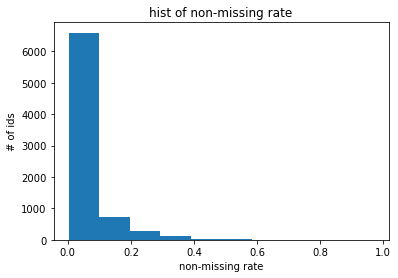

In [72]:
missing_dt = check_missings_mx(test_matrice_reverse, 288)
missing_dt = pd.DataFrame(missing_dt)
missing_dt[0].describe()

### NMF test

In [40]:
result_para_dict = {'ori':{'rmse_predvsraw':[],
                           'match per':[],    
                           'per of missings mitigated':[]},
                    'mor':{'rmse_predvsraw':[],
                     'match per':[],    
                     'per of missings mitigated':[]},
                    'noon':{'rmse_predvsraw':[],
                       'match per':[],    
                       'per of missings mitigated':[]},
                    'eve':{'rmse_predvsraw':[],
                      'match per':[],    
                      'per of missings mitigated':[]},
                    'other':{'rmse_predvsraw':[],
                        'match per':[],    
                        'per of missings mitigated':[]}
                   }

In [55]:
missing_val = 0.01

In [73]:
k_nmf = generate_paralst(list(np.array(range(1, 21))*10), [0], [0, 0, 0], 4)
k_nmf_100 = generate_paralst(list(np.array(range(1, 11))*100), [0], [0, 0, 0], 4)

RMSE, data with missing rate>=0.01, para=[10, 0, 0, 0], 0.0639843047568236
matched % compared with raw dt 0.12097667295004713
% of missings mitigated 0.9987014215115781


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[10, 0, 0, 0],mor, 0.06505774258286176
matched % compared with raw dtmor, 0.6357629071106922
% of missings mitigatedmor, 0.9948103849803054
RMSE, data with missing rate>=0.01, para=[10, 0, 0, 0],noon, 0.08002208497053398
matched % compared with raw dtnoon, 0.3463909833490418
% of missings mitigatednoon, 0.9936161264157178
RMSE, data with missing rate>=0.01, para=[10, 0, 0, 0],eve, 0.0716808709006242
matched % compared with raw dteve, 0.5922337417530632
% of missings mitigatedeve, 0.9956942096365173
RMSE, data with missing rate>=0.01, para=[10, 0, 0, 0],other, 0.04250997483753088
matched % compared with raw dtother, 0.6350082956200684
% of missings mitigatedother, 0.9995176917495412
RMSE, data with missing rate>=0.01, para=[20, 0, 0, 0], 0.062114559551957604
matched % compared with raw dt 0.15033249554927217
% of missings mitigated 0.9988129315737092
RMSE, data with missing rate>=0.01, para=[20, 0, 0, 0],mor, 0.06088864273868268
matched % compare

C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[20, 0, 0, 0],noon, 0.07726637048399751
matched % compared with raw dtnoon, 0.3441800188501414
% of missings mitigatednoon, 0.9978772200864681


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[20, 0, 0, 0],eve, 0.06757985633639038
matched % compared with raw dteve, 0.6630725730442978
% of missings mitigatedeve, 0.9956680893236785


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[20, 0, 0, 0],other, 0.040105718065721684
matched % compared with raw dtother, 0.6767901792321294
% of missings mitigatedother, 0.9995854822383959
RMSE, data with missing rate>=0.01, para=[30, 0, 0, 0], 0.0605674346737596
matched % compared with raw dt 0.2136382081893392
% of missings mitigated 0.998791445230079


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[30, 0, 0, 0],mor, 0.05751972665256181
matched % compared with raw dtmor, 0.7366425803749084
% of missings mitigatedmor, 0.9981310641005249


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[30, 0, 0, 0],noon, 0.07463221885949747
matched % compared with raw dtnoon, 0.426983191957273
% of missings mitigatednoon, 0.9983825978494034


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[30, 0, 0, 0],eve, 0.06430637301098394
matched % compared with raw dteve, 0.7037027063417262
% of missings mitigatedeve, 0.996510042715623
RMSE, data with missing rate>=0.01, para=[30, 0, 0, 0],other, 0.03907789226476711
matched % compared with raw dtother, 0.7201423886712208
% of missings mitigatedother, 0.9996159027398938


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[40, 0, 0, 0], 0.05973262474907393
matched % compared with raw dt 0.23886336265577549
% of missings mitigated 0.9991323378292967
RMSE, data with missing rate>=0.01, para=[40, 0, 0, 0],mor, 0.05635510767140922
matched % compared with raw dtmor, 0.7599486857262541
% of missings mitigatedmor, 0.9986039917112007


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[40, 0, 0, 0],noon, 0.07333422471679159
matched % compared with raw dtnoon, 0.46423185673892553
% of missings mitigatednoon, 0.9979439704459495


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[40, 0, 0, 0],eve, 0.06219659806654216
matched % compared with raw dteve, 0.7565854315335937
% of missings mitigatedeve, 0.9973006460748739
RMSE, data with missing rate>=0.01, para=[40, 0, 0, 0],other, 0.03843537262866826
matched % compared with raw dtother, 0.7229776991922481
% of missings mitigatedother, 0.9997188199435391


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[50, 0, 0, 0], 0.05921827027576903
matched % compared with raw dt 0.2584910723635983
% of missings mitigated 0.9992479523915025


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[50, 0, 0, 0],mor, 0.054652005927402575
matched % compared with raw dtmor, 0.7887056236255106
% of missings mitigatedmor, 0.9981166208212524


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[50, 0, 0, 0],noon, 0.07231462165639457
matched % compared with raw dtnoon, 0.47110234055922084
% of missings mitigatednoon, 0.9986894715934614


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[50, 0, 0, 0],eve, 0.060183426704366196
matched % compared with raw dteve, 0.7814245321125622
% of missings mitigatedeve, 0.9977823772915435
RMSE, data with missing rate>=0.01, para=[50, 0, 0, 0],other, 0.03787488901582203
matched % compared with raw dtother, 0.7258223568908172
% of missings mitigatedother, 0.99964203731903


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[60, 0, 0, 0], 0.058313888971019905
matched % compared with raw dt 0.32116451984500993
% of missings mitigated 0.9993761762981703


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[60, 0, 0, 0],mor, 0.05359025270520982
matched % compared with raw dtmor, 0.7923499842915489
% of missings mitigatedmor, 0.9986383236250851


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[60, 0, 0, 0],noon, 0.0715723319293411
matched % compared with raw dtnoon, 0.4969015080113101
% of missings mitigatednoon, 0.9985246938154229


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[60, 0, 0, 0],eve, 0.05882903587118866
matched % compared with raw dteve, 0.7813599030564158
% of missings mitigatedeve, 0.9968962459355601


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[60, 0, 0, 0],other, 0.03741347625250092
matched % compared with raw dtother, 0.7471510581783909
% of missings mitigatedother, 0.999525584547611


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[70, 0, 0, 0], 0.05803337584545523
matched % compared with raw dt 0.292183081998115
% of missings mitigated 0.9992759593538562
RMSE, data with missing rate>=0.01, para=[70, 0, 0, 0],mor, 0.05222899117502445
matched % compared with raw dtmor, 0.8209812545816316
% of missings mitigatedmor, 0.998332797098482


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[70, 0, 0, 0],noon, 0.07070419962111954
matched % compared with raw dtnoon, 0.5373978950675463
% of missings mitigatednoon, 0.9986035298012683
RMSE, data with missing rate>=0.01, para=[70, 0, 0, 0],eve, 0.05757694442257731
matched % compared with raw dteve, 0.7973394371886361
% of missings mitigatedeve, 0.9977411039357942
RMSE, data with missing rate>=0.01, para=[70, 0, 0, 0],other, 0.03696390368976888
matched % compared with raw dtother, 0.7663735287932015
% of missings mitigatedother, 0.999606577490898


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[80, 0, 0, 0], 0.057570213008737846
matched % compared with raw dt 0.35290999057492933
% of missings mitigated 0.9993304000404593


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[80, 0, 0, 0],mor, 0.05019477693648584
matched % compared with raw dtmor, 0.8412556288616609
% of missings mitigatedmor, 0.998218821123462


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[80, 0, 0, 0],noon, 0.06948385392251939
matched % compared with raw dtnoon, 0.5520538799874333
% of missings mitigatednoon, 0.9984877043790821
RMSE, data with missing rate>=0.01, para=[80, 0, 0, 0],eve, 0.056247791506446494
matched % compared with raw dteve, 0.8178699340245051
% of missings mitigatedeve, 0.9973977585238194
RMSE, data with missing rate>=0.01, para=[80, 0, 0, 0],other, 0.03637006849237691
matched % compared with raw dtother, 0.7450837740787188
% of missings mitigatedother, 0.9995844333626674


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[90, 0, 0, 0], 0.056910651842051005
matched % compared with raw dt 0.35800803749083676
% of missings mitigated 0.9993281412962693


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[90, 0, 0, 0],mor, 0.049599816347459184
matched % compared with raw dtmor, 0.8398575767096031
% of missings mitigatedmor, 0.9971880721946116


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[90, 0, 0, 0],noon, 0.0687974257094772
matched % compared with raw dtnoon, 0.5630419415645618
% of missings mitigatednoon, 0.9985395490127351
RMSE, data with missing rate>=0.01, para=[90, 0, 0, 0],eve, 0.05481646882719746
matched % compared with raw dteve, 0.8227386562542076
% of missings mitigatedeve, 0.9970528362653055


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[90, 0, 0, 0],other, 0.036216973840920375
matched % compared with raw dtother, 0.7674500120734377
% of missings mitigatedother, 0.9995176687322057


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[100, 0, 0, 0], 0.0567828043303287
matched % compared with raw dt 0.280429233427584
% of missings mitigated 0.9993878417921227


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[100, 0, 0, 0],mor, 0.047196029906915085
matched % compared with raw dtmor, 0.8483244318776836
% of missings mitigatedmor, 0.9985845962647151


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[100, 0, 0, 0],noon, 0.06797713337511684
matched % compared with raw dtnoon, 0.5931805686459315
% of missings mitigatednoon, 0.9985954581654077
RMSE, data with missing rate>=0.01, para=[100, 0, 0, 0],eve, 0.05274275242579798
matched % compared with raw dteve, 0.8455150127911674
% of missings mitigatedeve, 0.9960953841863059
RMSE, data with missing rate>=0.01, para=[100, 0, 0, 0],other, 0.03602684531131816
matched % compared with raw dtother, 0.7421627810968913
% of missings mitigatedother, 0.9995649730827095


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[110, 0, 0, 0], 0.05664917305106466
matched % compared with raw dt 0.33782071421091214
% of missings mitigated 0.999328855080142
RMSE, data with missing rate>=0.01, para=[110, 0, 0, 0],mor, 0.04564935508666949
matched % compared with raw dtmor, 0.8535029846057178
% of missings mitigatedmor, 0.9982486239187933


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[110, 0, 0, 0],noon, 0.06784775415023479
matched % compared with raw dtnoon, 0.58018575243481
% of missings mitigatednoon, 0.9985828075377801
RMSE, data with missing rate>=0.01, para=[110, 0, 0, 0],eve, 0.05045189211874935
matched % compared with raw dteve, 0.865765450383735
% of missings mitigatedeve, 0.9967099983951212
RMSE, data with missing rate>=0.01, para=[110, 0, 0, 0],other, 0.03562588458825737
matched % compared with raw dtother, 0.7534183407202
% of missings mitigatedother, 0.9996714724352738


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[120, 0, 0, 0], 0.056065984481903954
matched % compared with raw dt 0.3422138443816106
% of missings mitigated 0.9994338263389161


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[120, 0, 0, 0],mor, 0.043708311089679444
matched % compared with raw dtmor, 0.8804639229238663
% of missings mitigatedmor, 0.9982040387226773


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[120, 0, 0, 0],noon, 0.06670089538376374
matched % compared with raw dtnoon, 0.6222863650644046
% of missings mitigatednoon, 0.9985392125263826
RMSE, data with missing rate>=0.01, para=[120, 0, 0, 0],eve, 0.04920163740548732
matched % compared with raw dteve, 0.8665140702840985
% of missings mitigatedeve, 0.9963284244502724


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[120, 0, 0, 0],other, 0.03538692261024807
matched % compared with raw dtother, 0.7580078048932475
% of missings mitigatedother, 0.9996716794561467


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[130, 0, 0, 0], 0.0556929195580614
matched % compared with raw dt 0.3632448423918735
% of missings mitigated 0.9993246715868676


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[130, 0, 0, 0],mor, 0.04223689838072872
matched % compared with raw dtmor, 0.8809665933605613
% of missings mitigatedmor, 0.9978005542603264


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[130, 0, 0, 0],noon, 0.0662589990634991
matched % compared with raw dtnoon, 0.6286679233427585
% of missings mitigatednoon, 0.9985405474004823


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[130, 0, 0, 0],eve, 0.047821971868658254
matched % compared with raw dteve, 0.8747542749427764
% of missings mitigatedeve, 0.9965168780907332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[130, 0, 0, 0],other, 0.03458086416712288
matched % compared with raw dtother, 0.7667380687173335
% of missings mitigatedother, 0.9996727486442444


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[140, 0, 0, 0], 0.05554767491609263
matched % compared with raw dt 0.3066027856320033
% of missings mitigated 0.99939116481027


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[140, 0, 0, 0],mor, 0.04109335642250348
matched % compared with raw dtmor, 0.9033249554927217
% of missings mitigatedmor, 0.998158479120403


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[140, 0, 0, 0],noon, 0.06589862379770522
matched % compared with raw dtnoon, 0.6325655827835376
% of missings mitigatednoon, 0.9987441683990017


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[140, 0, 0, 0],eve, 0.04647083862989897
matched % compared with raw dteve, 0.8783358018042278
% of missings mitigatedeve, 0.9968570163789288
RMSE, data with missing rate>=0.01, para=[140, 0, 0, 0],other, 0.03469842097395553
matched % compared with raw dtother, 0.7597790950374277
% of missings mitigatedother, 0.9997665354509433


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[150, 0, 0, 0], 0.05531138181132637
matched % compared with raw dt 0.3611811446224736
% of missings mitigated 0.9993463201822107


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[150, 0, 0, 0],mor, 0.038994722607044965
matched % compared with raw dtmor, 0.89964917792439
% of missings mitigatedmor, 0.9986433602921994


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[150, 0, 0, 0],noon, 0.06507857200070014
matched % compared with raw dtnoon, 0.6364357524348099
% of missings mitigatednoon, 0.9986929940158569


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[150, 0, 0, 0],eve, 0.045363494687438694
matched % compared with raw dteve, 0.8950424128180962
% of missings mitigatedeve, 0.9974343185550082


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[150, 0, 0, 0],other, 0.03446262867605318
matched % compared with raw dtother, 0.7524851808289389
% of missings mitigatedother, 0.9997041811166848


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[160, 0, 0, 0], 0.054877738411096465
matched % compared with raw dt 0.3626623206618494
% of missings mitigated 0.9993673940949935


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[160, 0, 0, 0],mor, 0.03890070888058375
matched % compared with raw dtmor, 0.8917373546968269
% of missings mitigatedmor, 0.9987425033855678


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[160, 0, 0, 0],noon, 0.06388686637709473
matched % compared with raw dtnoon, 0.6483270499528746
% of missings mitigatednoon, 0.9984757118927973


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[160, 0, 0, 0],eve, 0.04311572145825418
matched % compared with raw dteve, 0.900535882590548
% of missings mitigatedeve, 0.9972384665367121


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[160, 0, 0, 0],other, 0.034105565022791356
matched % compared with raw dtother, 0.7738232292940544
% of missings mitigatedother, 0.9997658144148116


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[170, 0, 0, 0], 0.05473863049752367
matched % compared with raw dt 0.39439601005340874
% of missings mitigated 0.9993763955446325
RMSE, data with missing rate>=0.01, para=[170, 0, 0, 0],mor, 0.03707770622248612
matched % compared with raw dtmor, 0.8962299717247879
% of missings mitigatedmor, 0.99823392875164


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[170, 0, 0, 0],noon, 0.06333541833923333
matched % compared with raw dtnoon, 0.6745699811498587
% of missings mitigatednoon, 0.9985941412495852
RMSE, data with missing rate>=0.01, para=[170, 0, 0, 0],eve, 0.04155073575275501
matched % compared with raw dteve, 0.9001157937255958
% of missings mitigatedeve, 0.9978971206729214


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[170, 0, 0, 0],other, 0.03391529495036382
matched % compared with raw dtother, 0.7643171497339949
% of missings mitigatedother, 0.999735600121624


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[180, 0, 0, 0], 0.05459474012724125
matched % compared with raw dt 0.3595304482144727
% of missings mitigated 0.9994348694732431
RMSE, data with missing rate>=0.01, para=[180, 0, 0, 0],mor, 0.036365616937002035
matched % compared with raw dtmor, 0.90275945125144
% of missings mitigatedmor, 0.9985999676915621


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[180, 0, 0, 0],noon, 0.06278107552665103
matched % compared with raw dtnoon, 0.6559888469996858
% of missings mitigatednoon, 0.9985502117604083
RMSE, data with missing rate>=0.01, para=[180, 0, 0, 0],eve, 0.03918216971090684
matched % compared with raw dteve, 0.908339841120237
% of missings mitigatedeve, 0.9977672013631823


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[180, 0, 0, 0],other, 0.03399726936106315
matched % compared with raw dtother, 0.768908171769966
% of missings mitigatedother, 0.999757312641989


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[190, 0, 0, 0], 0.05452613143362202
matched % compared with raw dt 0.38427584040213636
% of missings mitigated 0.9994461736017212


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[190, 0, 0, 0],mor, 0.03423109130126246
matched % compared with raw dtmor, 0.904953398261598
% of missings mitigatedmor, 0.998402379903041


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[190, 0, 0, 0],noon, 0.06272624556515116
matched % compared with raw dtnoon, 0.6815288250078543
% of missings mitigatednoon, 0.9980886732309437
RMSE, data with missing rate>=0.01, para=[190, 0, 0, 0],eve, 0.038299834585697384
matched % compared with raw dteve, 0.9170486064359769
% of missings mitigatedeve, 0.9984417608102844


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[190, 0, 0, 0],other, 0.03364504407888227
matched % compared with raw dtother, 0.7681899969621673
% of missings mitigatedother, 0.9998252688172043


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[200, 0, 0, 0], 0.05429336634203925
matched % compared with raw dt 0.3891493873704053
% of missings mitigated 0.9994321116232822


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[200, 0, 0, 0],mor, 0.03264336172031598
matched % compared with raw dtmor, 0.9201696512723846
% of missings mitigatedmor, 0.9986881805063623


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[200, 0, 0, 0],noon, 0.06173557701605306
matched % compared with raw dtnoon, 0.7061989475337732
% of missings mitigatednoon, 0.9983625949861991
RMSE, data with missing rate>=0.01, para=[200, 0, 0, 0],eve, 0.03788517703602907
matched % compared with raw dteve, 0.9107149589336205
% of missings mitigatedeve, 0.9976474846181687


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[200, 0, 0, 0],other, 0.03308891959009429
matched % compared with raw dtother, 0.7679033501842173
% of missings mitigatedother, 0.9997784997046663


4

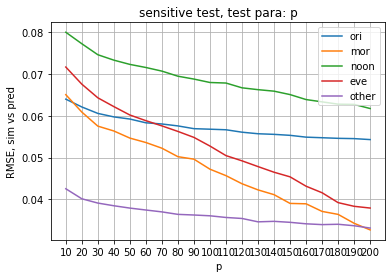

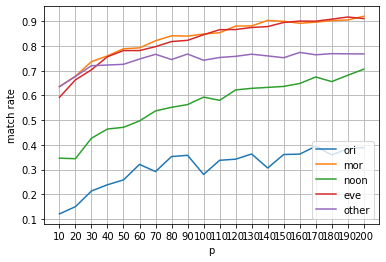

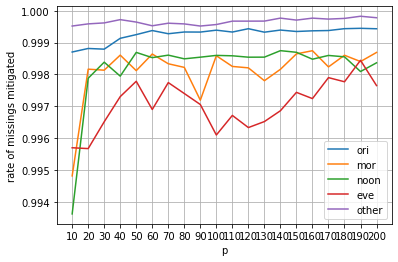

In [97]:
#test of k
test_k_nmf = fit_model_get_para_sensitive(test_matrice_reverse, k_nmf, 
                                          missing_val, 288, result_para_dict, 'NMF', True)

plot_paras_sensitive(test_k_nmf, k_nmf, 'p', 0, 1)

C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[100, 0, 0, 0], 0.0567828043303287
matched % compared with raw dt 0.280429233427584
% of missings mitigated 0.9993878417921227


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[100, 0, 0, 0],mor, 0.047196029906915085
matched % compared with raw dtmor, 0.8483244318776836
% of missings mitigatedmor, 0.9985845962647151


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[100, 0, 0, 0],noon, 0.06797713337511684
matched % compared with raw dtnoon, 0.5931805686459315
% of missings mitigatednoon, 0.9985954581654077
RMSE, data with missing rate>=0.01, para=[100, 0, 0, 0],eve, 0.05274275242579798
matched % compared with raw dteve, 0.8455150127911674
% of missings mitigatedeve, 0.9960953841863059
RMSE, data with missing rate>=0.01, para=[100, 0, 0, 0],other, 0.03602684531131816
matched % compared with raw dtother, 0.7421627810968913
% of missings mitigatedother, 0.9995649730827095


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[200, 0, 0, 0], 0.05429336634203925
matched % compared with raw dt 0.3891493873704053
% of missings mitigated 0.9994321116232822


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[200, 0, 0, 0],mor, 0.03264336172031598
matched % compared with raw dtmor, 0.9201696512723846
% of missings mitigatedmor, 0.9986881805063623


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[200, 0, 0, 0],noon, 0.06173557701605306
matched % compared with raw dtnoon, 0.7061989475337732
% of missings mitigatednoon, 0.9983625949861991
RMSE, data with missing rate>=0.01, para=[200, 0, 0, 0],eve, 0.03788517703602907
matched % compared with raw dteve, 0.9107149589336205
% of missings mitigatedeve, 0.9976474846181687


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[200, 0, 0, 0],other, 0.03308891959009429
matched % compared with raw dtother, 0.7679033501842173
% of missings mitigatedother, 0.9997784997046663


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[300, 0, 0, 0], 0.052463016177278325
matched % compared with raw dt 0.43899622997172477
% of missings mitigated 0.9995064891427612
RMSE, data with missing rate>=0.01, para=[300, 0, 0, 0],mor, 0.02221247713387926
matched % compared with raw dtmor, 0.9388312912346842
% of missings mitigatedmor, 0.9989727786337956


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[300, 0, 0, 0],noon, 0.05565206096680034
matched % compared with raw dtnoon, 0.742813383600377
% of missings mitigatednoon, 0.9985188578408918


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[300, 0, 0, 0],eve, 0.024249564445353266
matched % compared with raw dteve, 0.9320802477447152
% of missings mitigatedeve, 0.9993656331773848
RMSE, data with missing rate>=0.01, para=[300, 0, 0, 0],other, 0.030452350869724993
matched % compared with raw dtother, 0.7496062501460496
% of missings mitigatedother, 0.9999128968636649


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[400, 0, 0, 0], 0.051355133136886284
matched % compared with raw dt 0.33188881034663315
% of missings mitigated 0.9996512426440118
RMSE, data with missing rate>=0.01, para=[400, 0, 0, 0],mor, 0.014735804563874423
matched % compared with raw dtmor, 0.8828934967012253
% of missings mitigatedmor, 0.9997317236753857


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[400, 0, 0, 0],noon, 0.04876901519647091
matched % compared with raw dtnoon, 0.7937460728872133
% of missings mitigatednoon, 0.9984767852552813
RMSE, data with missing rate>=0.01, para=[400, 0, 0, 0],eve, 0.013569675976702115
matched % compared with raw dteve, 0.9174902383196445
% of missings mitigatedeve, 0.999934725848564


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[400, 0, 0, 0],other, 0.027277698281768886
matched % compared with raw dtother, 0.7667645523870354
% of missings mitigatedother, 0.9998597334936379


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[500, 0, 0, 0], 0.04928175855015477
matched % compared with raw dt 0.35704458582050475
% of missings mitigated 0.9996650830217452
RMSE, data with missing rate>=0.01, para=[500, 0, 0, 0],mor, 0.009795724992563249
matched % compared with raw dtmor, 0.8459262750026181
% of missings mitigatedmor, 1.0


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[500, 0, 0, 0],noon, 0.041396988858445415
matched % compared with raw dtnoon, 0.8046516650958215
% of missings mitigatednoon, 0.9987938122568778


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[500, 0, 0, 0],eve, 0.008300031423743987
matched % compared with raw dteve, 0.9004604820250438
% of missings mitigatedeve, 0.9999458933015908
RMSE, data with missing rate>=0.01, para=[500, 0, 0, 0],other, 0.02353264254711619
matched % compared with raw dtother, 0.7690764209657193
% of missings mitigatedother, 0.9999257915011031


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[600, 0, 0, 0], 0.04739299540747654
matched % compared with raw dt 0.3213877107550529
% of missings mitigated 0.9996913612992147
RMSE, data with missing rate>=0.01, para=[600, 0, 0, 0],mor, 0.005479137038853065
matched % compared with raw dtmor, 0.8554089433448528
% of missings mitigatedmor, 1.0


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[600, 0, 0, 0],noon, 0.035126072184505315
matched % compared with raw dtnoon, 0.7414624568017594
% of missings mitigatednoon, 0.9994531700944801
RMSE, data with missing rate>=0.01, para=[600, 0, 0, 0],eve, 0.005462892301512137
matched % compared with raw dteve, 0.8639181365288812
% of missings mitigatedeve, 1.0


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[600, 0, 0, 0],other, 0.02080275012287427
matched % compared with raw dtother, 0.7720690756420343
% of missings mitigatedother, 0.9999658259859203


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[700, 0, 0, 0], 0.04502774976263307
matched % compared with raw dt 0.29579275316787096
% of missings mitigated 0.9997629926499838
RMSE, data with missing rate>=0.01, para=[700, 0, 0, 0],mor, 0.004371374571805047
matched % compared with raw dtmor, 0.8225887527489789
% of missings mitigatedmor, 1.0


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[700, 0, 0, 0],noon, 0.029666849044868476
matched % compared with raw dtnoon, 0.8245797989318253
% of missings mitigatednoon, 0.9993731670733619
RMSE, data with missing rate>=0.01, para=[700, 0, 0, 0],eve, 0.002511667345477052
matched % compared with raw dteve, 0.7945496162649791
% of missings mitigatedeve, 1.0


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[700, 0, 0, 0],other, 0.017756214293202788
matched % compared with raw dtother, 0.7683629197466915
% of missings mitigatedother, 0.9999596473175555


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[800, 0, 0, 0], 0.04326391789310188
matched % compared with raw dt 0.35305202115404755
% of missings mitigated 0.9997531446238642
RMSE, data with missing rate>=0.01, para=[800, 0, 0, 0],mor, 0.0030105767699151794
matched % compared with raw dtmor, 0.7633626557754739
% of missings mitigatedmor, 0.9999778726793973


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[800, 0, 0, 0],noon, 0.02518369806392454
matched % compared with raw dtnoon, 0.7794670907948477
% of missings mitigatednoon, 0.9996082376928762
RMSE, data with missing rate>=0.01, para=[800, 0, 0, 0],eve, 0.0013396334834036572
matched % compared with raw dteve, 0.7778160764777164
% of missings mitigatedeve, 1.0


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[800, 0, 0, 0],other, 0.015516760288163905
matched % compared with raw dtother, 0.7843201096735498
% of missings mitigatedother, 0.9999422157375438


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[900, 0, 0, 0], 0.040795290817472046
matched % compared with raw dt 0.3045986490732014
% of missings mitigated 0.9997797568289502
RMSE, data with missing rate>=0.01, para=[900, 0, 0, 0],mor, 0.002475215704613515
matched % compared with raw dtmor, 0.7246675044507278
% of missings mitigatedmor, 1.0


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[900, 0, 0, 0],noon, 0.022380448320076622
matched % compared with raw dtnoon, 0.7040036914860195
% of missings mitigatednoon, 0.999840790739328
RMSE, data with missing rate>=0.01, para=[900, 0, 0, 0],eve, 0.0011636187489882164
matched % compared with raw dteve, 0.702340110407971
% of missings mitigatedeve, 1.0


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[900, 0, 0, 0],other, 0.012288510245920467
matched % compared with raw dtother, 0.7700672217851551
% of missings mitigatedother, 0.9999864494054677


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[1000, 0, 0, 0], 0.03921903646410505
matched % compared with raw dt 0.31751885014137604
% of missings mitigated 0.9998283339183407
RMSE, data with missing rate>=0.01, para=[1000, 0, 0, 0],mor, 0.0015401283770883302
matched % compared with raw dtmor, 0.7045292700806367
% of missings mitigatedmor, 1.0


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[1000, 0, 0, 0],noon, 0.020965477526985146
matched % compared with raw dtnoon, 0.6132206251963557
% of missings mitigatednoon, 0.9998527761842633
RMSE, data with missing rate>=0.01, para=[1000, 0, 0, 0],eve, 0.0008606246739685906
matched % compared with raw dteve, 0.7230537229029218
% of missings mitigatedeve, 1.0


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, para=[1000, 0, 0, 0],other, 0.01024766607638114
matched % compared with raw dtother, 0.7777833168459507
% of missings mitigatedother, 0.9999929894420998


4

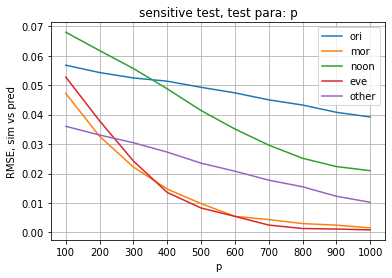

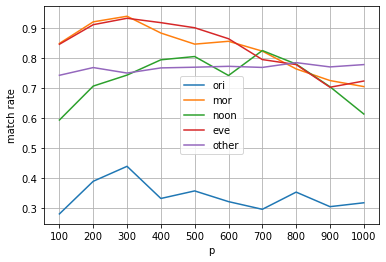

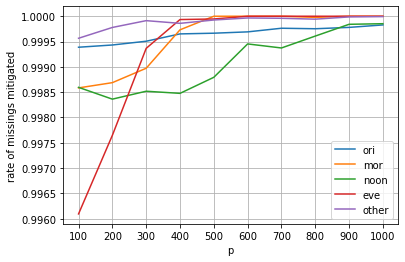

In [102]:
#test of k
test_k_nmf_100 = fit_model_get_para_sensitive(test_matrice_reverse, k_nmf_100,
                                              missing_val, 288, result_para_dict, 'NMF', True)
plot_paras_sensitive(test_k_nmf_100, k_nmf_100, 'p', 0, 1)

RMSE, data with missing rate>=0.0, para=[10, 0, 0, 0], 0.05384531076914852
matched % compared with raw dt 0.1252619701586484
% of missings mitigated 0.9979705606077177
RMSE, data with missing rate>=0.0, para=[10, 0, 0, 0],mor, 0.05444274087255216
matched % compared with raw dtmor, 0.692488162167575
% of missings mitigatedmor, 0.9958829549683662
RMSE, data with missing rate>=0.0, para=[10, 0, 0, 0],noon, 0.06705896618713864
matched % compared with raw dtnoon, 0.39254753014892063
% of missings mitigatednoon, 0.9955225462316972


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[10, 0, 0, 0],eve, 0.060060803014223466
matched % compared with raw dteve, 0.6885210322058526
% of missings mitigatedeve, 0.9938233696294022
RMSE, data with missing rate>=0.0, para=[10, 0, 0, 0],other, 0.03558481167436917
matched % compared with raw dtother, 0.7052682093238293
% of missings mitigatedother, 0.9974945034315195


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[20, 0, 0, 0], 0.05221822658940879
matched % compared with raw dt 0.19808922721485486
% of missings mitigated 0.9993622445424244


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[20, 0, 0, 0],mor, 0.051103348900157074
matched % compared with raw dtmor, 0.7522495457991789
% of missings mitigatedmor, 0.9984698443860611


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[20, 0, 0, 0],noon, 0.06460774896684053
matched % compared with raw dtnoon, 0.4463046113900691
% of missings mitigatednoon, 0.9987937595221543


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[20, 0, 0, 0],eve, 0.05713885894565842
matched % compared with raw dteve, 0.7177546028067465
% of missings mitigatedeve, 0.9971326912299451


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[20, 0, 0, 0],other, 0.03407065806235111
matched % compared with raw dtother, 0.7430483067268067
% of missings mitigatedother, 0.9987825330765886
RMSE, data with missing rate>=0.0, para=[30, 0, 0, 0], 0.05138429175525795
matched % compared with raw dt 0.22825960616854785
% of missings mitigated 0.9991693231141926


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[30, 0, 0, 0],mor, 0.04967720226182193
matched % compared with raw dtmor, 0.7815437105703618
% of missings mitigatedmor, 0.9986903066319598


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[30, 0, 0, 0],noon, 0.06318737020616999
matched % compared with raw dtnoon, 0.49597120295266295
% of missings mitigatednoon, 0.9988052791229844
RMSE, data with missing rate>=0.0, para=[30, 0, 0, 0],eve, 0.054565933213356385
matched % compared with raw dteve, 0.7685445750335669
% of missings mitigatedeve, 0.9977908455181183
RMSE, data with missing rate>=0.0, para=[30, 0, 0, 0],other, 0.03282125506673141
matched % compared with raw dtother, 0.7667201882939795
% of missings mitigatedother, 0.9995712422116604


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[40, 0, 0, 0], 0.050516627631693095
matched % compared with raw dt 0.2972498497918544
% of missings mitigated 0.9993918493822118
RMSE, data with missing rate>=0.0, para=[40, 0, 0, 0],mor, 0.048218285105881296
matched % compared with raw dtmor, 0.8083129479421484
% of missings mitigatedmor, 0.9985633792305683


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[40, 0, 0, 0],noon, 0.06223192033664752
matched % compared with raw dtnoon, 0.5388757456761513
% of missings mitigatednoon, 0.9986766677621725
RMSE, data with missing rate>=0.0, para=[40, 0, 0, 0],eve, 0.05305485965405958
matched % compared with raw dteve, 0.7863120528242197
% of missings mitigatedeve, 0.9977793079703908


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[40, 0, 0, 0],other, 0.03239356537374376
matched % compared with raw dtother, 0.7714190253956398
% of missings mitigatedother, 0.9996648387967713


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[50, 0, 0, 0], 0.049971197088988215
matched % compared with raw dt 0.331657797233309
% of missings mitigated 0.9994956562221574


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[50, 0, 0, 0],mor, 0.04714040233174056
matched % compared with raw dtmor, 0.822225083329757
% of missings mitigatedmor, 0.9980284863603444


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[50, 0, 0, 0],noon, 0.061380737266051644
matched % compared with raw dtnoon, 0.554316338354577
% of missings mitigatednoon, 0.9988565100687298


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[50, 0, 0, 0],eve, 0.05183409293574287
matched % compared with raw dteve, 0.8095973808604168
% of missings mitigatedeve, 0.9976429675425038


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[50, 0, 0, 0],other, 0.03183158944915975
matched % compared with raw dtother, 0.7956367637185081
% of missings mitigatedother, 0.9994637148420823


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[60, 0, 0, 0], 0.049545154852395995
matched % compared with raw dt 0.36625797533725307
% of missings mitigated 0.9994250907333797


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[60, 0, 0, 0],mor, 0.04590565390443322
matched % compared with raw dtmor, 0.8438300216013619
% of missings mitigatedmor, 0.9988778711612889


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[60, 0, 0, 0],noon, 0.060727090605595446
matched % compared with raw dtnoon, 0.5778882880563065
% of missings mitigatednoon, 0.9987195780644341


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[60, 0, 0, 0],eve, 0.0508917081049365
matched % compared with raw dteve, 0.8248671117732531
% of missings mitigatedeve, 0.9975214770316537
RMSE, data with missing rate>=0.0, para=[60, 0, 0, 0],other, 0.03144100206964771
matched % compared with raw dtother, 0.8003345367719117
% of missings mitigatedother, 0.9994351095407867


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[70, 0, 0, 0], 0.04910693601170725
matched % compared with raw dt 0.3493085954823112
% of missings mitigated 0.9994373179785494


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[70, 0, 0, 0],mor, 0.04513152539446309
matched % compared with raw dtmor, 0.841405232965681
% of missings mitigatedmor, 0.9981057616416732


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[70, 0, 0, 0],noon, 0.05978455073805793
matched % compared with raw dtnoon, 0.6132488948972147
% of missings mitigatednoon, 0.9987689597536532


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[70, 0, 0, 0],eve, 0.04936928223713819
matched % compared with raw dteve, 0.8355754198164396
% of missings mitigatedeve, 0.9977627634346056


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[70, 0, 0, 0],other, 0.031604487652187506
matched % compared with raw dtother, 0.7939651439072065
% of missings mitigatedother, 0.9996333269638956


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[80, 0, 0, 0], 0.04874818415569068
matched % compared with raw dt 0.39328247714690356
% of missings mitigated 0.9995254810767159


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[80, 0, 0, 0],mor, 0.04402169310945792
matched % compared with raw dtmor, 0.8593908702058567
% of missings mitigatedmor, 0.9983212941296165


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[80, 0, 0, 0],noon, 0.05908351548982872
matched % compared with raw dtnoon, 0.6396117655894596
% of missings mitigatednoon, 0.9986342509033668
RMSE, data with missing rate>=0.0, para=[80, 0, 0, 0],eve, 0.04830508088369855
matched % compared with raw dteve, 0.841398591108904
% of missings mitigatedeve, 0.9972399396961614


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[80, 0, 0, 0],other, 0.030914394883251577
matched % compared with raw dtother, 0.8112804011887547
% of missings mitigatedother, 0.9996673432566532


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[90, 0, 0, 0], 0.04832855720809943
matched % compared with raw dt 0.4078401499220348
% of missings mitigated 0.9993560320096633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[90, 0, 0, 0],mor, 0.04259669344299874
matched % compared with raw dtmor, 0.874368768150151
% of missings mitigatedmor, 0.9981780915508995


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[90, 0, 0, 0],noon, 0.058446272915033064
matched % compared with raw dtnoon, 0.6294539397450754
% of missings mitigatednoon, 0.9988816139505087


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[90, 0, 0, 0],eve, 0.0464889369334292
matched % compared with raw dteve, 0.8577829277713402
% of missings mitigatedeve, 0.9971288895786451
RMSE, data with missing rate>=0.0, para=[90, 0, 0, 0],other, 0.030590134613968624
matched % compared with raw dtother, 0.8136872783454475
% of missings mitigatedother, 0.9996858901872094


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[100, 0, 0, 0], 0.04814710943621595
matched % compared with raw dt 0.4080502625066163
% of missings mitigated 0.9995113772816868
RMSE, data with missing rate>=0.0, para=[100, 0, 0, 0],mor, 0.04143406532499328
matched % compared with raw dtmor, 0.8708960988798764
% of missings mitigatedmor, 0.9981993961051553


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[100, 0, 0, 0],noon, 0.058022914173536666
matched % compared with raw dtnoon, 0.6698559074717824
% of missings mitigatednoon, 0.9988219331670499


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[100, 0, 0, 0],eve, 0.04560280547195887
matched % compared with raw dteve, 0.8756239768986003
% of missings mitigatedeve, 0.9980775487267457


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[100, 0, 0, 0],other, 0.03028568661725126
matched % compared with raw dtother, 0.8079669549173394
% of missings mitigatedother, 0.9997506566042754


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[110, 0, 0, 0], 0.04796651799243826
matched % compared with raw dt 0.42431297655322375
% of missings mitigated 0.9993873043878013


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[110, 0, 0, 0],mor, 0.03975315992569009
matched % compared with raw dtmor, 0.891385205212938
% of missings mitigatedmor, 0.9981560750740863


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[110, 0, 0, 0],noon, 0.057522469239869846
matched % compared with raw dtnoon, 0.6750447942148405
% of missings mitigatednoon, 0.9988897922797229
RMSE, data with missing rate>=0.0, para=[110, 0, 0, 0],eve, 0.0434396732206025
matched % compared with raw dteve, 0.8822049329581195
% of missings mitigatedeve, 0.9975954031603272
RMSE, data with missing rate>=0.0, para=[110, 0, 0, 0],other, 0.030161419719158727
matched % compared with raw dtother, 0.8183052477795973
% of missings mitigatedother, 0.9997950315651389


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[120, 0, 0, 0], 0.04756772861625563
matched % compared with raw dt 0.43345063874225714
% of missings mitigated 0.9994807908391935
RMSE, data with missing rate>=0.0, para=[120, 0, 0, 0],mor, 0.03859946277222829
matched % compared with raw dtmor, 0.8955731513668941
% of missings mitigatedmor, 0.9989040720572623


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[120, 0, 0, 0],noon, 0.05658259551904337
matched % compared with raw dtnoon, 0.6870748573022617
% of missings mitigatednoon, 0.9987913957664565


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[120, 0, 0, 0],eve, 0.04302082625321913
matched % compared with raw dteve, 0.8903014585517482
% of missings mitigatedeve, 0.9976526608765635


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[120, 0, 0, 0],other, 0.03034797067787642
matched % compared with raw dtother, 0.8188287595219018
% of missings mitigatedother, 0.9997768197996076


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[130, 0, 0, 0], 0.04747041119306271
matched % compared with raw dt 0.42774049397021585
% of missings mitigated 0.9995086263802795


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[130, 0, 0, 0],mor, 0.03671674863189463
matched % compared with raw dtmor, 0.9060662632505043
% of missings mitigatedmor, 0.998248619836284


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[130, 0, 0, 0],noon, 0.05652455037750523
matched % compared with raw dtnoon, 0.6875093880090983
% of missings mitigatednoon, 0.9987897151538822


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[130, 0, 0, 0],eve, 0.04201662206329349
matched % compared with raw dteve, 0.9022972649855616
% of missings mitigatedeve, 0.9969503012048193


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[130, 0, 0, 0],other, 0.029815535181584092
matched % compared with raw dtother, 0.820104553381705
% of missings mitigatedother, 0.9997929814807147


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[140, 0, 0, 0], 0.04704315754319399
matched % compared with raw dt 0.4610545148276898
% of missings mitigated 0.9994940131805419


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[140, 0, 0, 0],mor, 0.03568579558532331
matched % compared with raw dtmor, 0.9160694104687924
% of missings mitigatedmor, 0.9982529401738538


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[140, 0, 0, 0],noon, 0.05595410191292352
matched % compared with raw dtnoon, 0.7078196751212394
% of missings mitigatednoon, 0.9989442712947365


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[140, 0, 0, 0],eve, 0.039644410205517136
matched % compared with raw dteve, 0.9058875462119959
% of missings mitigatedeve, 0.9973030018761726


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[140, 0, 0, 0],other, 0.029719536924331096
matched % compared with raw dtother, 0.8028467547060194
% of missings mitigatedother, 0.9998272940211349


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[150, 0, 0, 0], 0.04682226014582228
matched % compared with raw dt 0.4731686229489435
% of missings mitigated 0.9994357075760288
RMSE, data with missing rate>=0.0, para=[150, 0, 0, 0],mor, 0.034449968225886675
matched % compared with raw dtmor, 0.9098429251963435
% of missings mitigatedmor, 0.9984529334761395


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[150, 0, 0, 0],noon, 0.05539030819364342
matched % compared with raw dtnoon, 0.725825876571821
% of missings mitigatednoon, 0.9987232980976652
RMSE, data with missing rate>=0.0, para=[150, 0, 0, 0],eve, 0.03682730877222775
matched % compared with raw dteve, 0.9183247806654528
% of missings mitigatedeve, 0.9978381299824348
RMSE, data with missing rate>=0.0, para=[150, 0, 0, 0],other, 0.029441463287730205
matched % compared with raw dtother, 0.8189766622295854
% of missings mitigatedother, 0.9997707594914388


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[160, 0, 0, 0], 0.04683906286096833
matched % compared with raw dt 0.46684781053745905
% of missings mitigated 0.9994574905710687
RMSE, data with missing rate>=0.0, para=[160, 0, 0, 0],mor, 0.033866617523038205
matched % compared with raw dtmor, 0.9096104602091469
% of missings mitigatedmor, 0.999208672944528


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[160, 0, 0, 0],noon, 0.05505885667093503
matched % compared with raw dtnoon, 0.7205618857559761
% of missings mitigatednoon, 0.9988625346758944
RMSE, data with missing rate>=0.0, para=[160, 0, 0, 0],eve, 0.03816358466481294
matched % compared with raw dteve, 0.922930346337067
% of missings mitigatedeve, 0.9973270965586368


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[160, 0, 0, 0],other, 0.0289192400320552
matched % compared with raw dtother, 0.8168858074051374
% of missings mitigatedother, 0.9996862143504637


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[170, 0, 0, 0], 0.046572208437980614
matched % compared with raw dt 0.4517983849047966
% of missings mitigated 0.999515604230716
RMSE, data with missing rate>=0.0, para=[170, 0, 0, 0],mor, 0.032012425858852174
matched % compared with raw dtmor, 0.9235976996695421
% of missings mitigatedmor, 0.9985488929457473


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[170, 0, 0, 0],noon, 0.05411313927106209
matched % compared with raw dtnoon, 0.7262523604137161
% of missings mitigatednoon, 0.9987898978517012
RMSE, data with missing rate>=0.0, para=[170, 0, 0, 0],eve, 0.03545546940382425
matched % compared with raw dteve, 0.9233055601537641
% of missings mitigatedeve, 0.9976018034438102


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[170, 0, 0, 0],other, 0.028777844299252134
matched % compared with raw dtother, 0.8076019863652857
% of missings mitigatedother, 0.9998340863967436


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[180, 0, 0, 0], 0.046343528109210774
matched % compared with raw dt 0.46293390483956337
% of missings mitigated 0.9994972368838343
RMSE, data with missing rate>=0.0, para=[180, 0, 0, 0],mor, 0.031006288103739465
matched % compared with raw dtmor, 0.9209940918129408
% of missings mitigatedmor, 0.9985967135937712


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[180, 0, 0, 0],noon, 0.05406834331152718
matched % compared with raw dtnoon, 0.7213746191150594
% of missings mitigatednoon, 0.9988495898956448


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[180, 0, 0, 0],eve, 0.03558113699723062
matched % compared with raw dteve, 0.9325203700638232
% of missings mitigatedeve, 0.997274313126908


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[180, 0, 0, 0],other, 0.02830012721230618
matched % compared with raw dtother, 0.8126168457991907
% of missings mitigatedother, 0.9998012538045701


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[190, 0, 0, 0], 0.04627061784975111
matched % compared with raw dt 0.4951204705091341
% of missings mitigated 0.9994997179826149


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[190, 0, 0, 0],mor, 0.029635673995431117
matched % compared with raw dtmor, 0.9333397708252865
% of missings mitigatedmor, 0.9986587263265196


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[190, 0, 0, 0],noon, 0.05365609968624692
matched % compared with raw dtnoon, 0.7398998433543624
% of missings mitigatednoon, 0.9986748410582709


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[190, 0, 0, 0],eve, 0.03304515992506231
matched % compared with raw dteve, 0.9350475454762824
% of missings mitigatedeve, 0.998017783315399


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[190, 0, 0, 0],other, 0.028446498169922035
matched % compared with raw dtother, 0.8093470255063008
% of missings mitigatedother, 0.9998214056491626


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[200, 0, 0, 0], 0.046226476645264594
matched % compared with raw dt 0.4479814886342503
% of missings mitigated 0.9995578259940007


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[200, 0, 0, 0],mor, 0.02856060245094208
matched % compared with raw dtmor, 0.9408716364104545
% of missings mitigatedmor, 0.9987298131010706


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[200, 0, 0, 0],noon, 0.05245553467977515
matched % compared with raw dtnoon, 0.7609853117891936
% of missings mitigatednoon, 0.9987823832743229
RMSE, data with missing rate>=0.0, para=[200, 0, 0, 0],eve, 0.032191090401603464
matched % compared with raw dteve, 0.9186448159796943
% of missings mitigatedeve, 0.9986435160065111


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[200, 0, 0, 0],other, 0.028257966165839424
matched % compared with raw dtother, 0.8197906591459736
% of missings mitigatedother, 0.9998169601209244


4

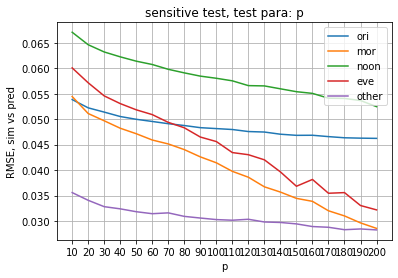

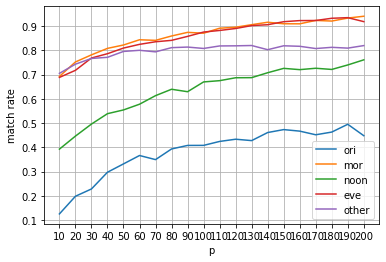

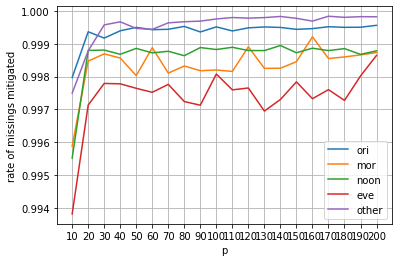

In [103]:
#test of k
test_k_nmf = fit_model_get_para_sensitive(test_matrice_reverse, k_nmf, 
                                          0.0, 288, result_para_dict, 'NMF', True)

plot_paras_sensitive(test_k_nmf, k_nmf, 'p', 0, 1)

###### aW and aH

In [104]:
missing_val = 0.0

In [105]:
aWaH_nmf_1 = [[300, 0.01, 0.01, 0.5],
            [300, 0.1, 0.1, 0.5],
            [300, 1., 1., 0.5],
            [300, 10., 10., 0.5],
            [300, 100., 100., 0.5]]
test_aWaH_nmf1 = fit_model_get_para_sensitive(test_matrice_reverse, aWaH_nmf_1, 
                                          missing_val, 288, result_para_dict, 'NMF', True)

aWaH_nmf_3 =  [[300, 0.01, 0.01, 0.2],
                [300, 0.01, 0.1, 0.2],
                [300, 0.01, 1.0, 0.2],
                [300, 0.01, 10.0, 0.2],
                [300, 0.01, 100.0, 0.2]
               ]

aWaH_nmf_4 =  [[300, 0.01, 0.01, 0.2],
                [300, 0.1, 0.01, 0.2],
                [300, 1., 0.01, 0.2],
                [300, 10., 0.01, 0.2],
                [300, 100., 0.01, 0.2]]

test_aWaH_nmf3 = fit_model_get_para_sensitive(test_matrice_reverse, aWaH_nmf_3, 
                                          missing_val, 288, result_para_dict, 'NMF', True)

test_aWaH_nmf4 = fit_model_get_para_sensitive(test_matrice_reverse, aWaH_nmf_4, 
                                          missing_val, 288, result_para_dict, 'NMF', True)

aWaH_nmf_5 =  [[300, 10, 0.01, 0.2],
                [300, 10, 0.1, 0.2],
                [300, 10, 1.0, 0.2],
                [300, 10, 10.0, 0.2],
                [300, 10, 100.0, 0.2]
               ]

aWaH_nmf_6 =  [[300, 0.01, 10, 0.2],
                [300, 0.1, 10, 0.2],
                [300, 1., 10, 0.2],
                [300, 10., 10, 0.2],
                [300, 100., 10, 0.2]]

test_aWaH_nmf5 = fit_model_get_para_sensitive(test_matrice_reverse, aWaH_nmf_5, 
                                          missing_val, 288, result_para_dict, 'NMF', True)

test_aWaH_nmf6 = fit_model_get_para_sensitive(test_matrice_reverse, aWaH_nmf_6, 
                                          missing_val, 288, result_para_dict, 'NMF', True)

RMSE, data with missing rate>=0.0, para=[300, 0.01, 0.01, 0.5], 0.05219334915819095
matched % compared with raw dt 0.2440605195771283
% of missings mitigated 0.9994724883764114
RMSE, data with missing rate>=0.0, para=[300, 0.01, 0.01, 0.5],mor, 0.05140094990303848
matched % compared with raw dtmor, 0.7067829706879533
% of missings mitigatedmor, 0.9995487089416615
RMSE, data with missing rate>=0.0, para=[300, 0.01, 0.01, 0.5],noon, 0.06524563560923087
matched % compared with raw dtnoon, 0.3891437062787005
% of missings mitigatednoon, 0.9990142137641227
RMSE, data with missing rate>=0.0, para=[300, 0.01, 0.01, 0.5],eve, 0.05502099804729722
matched % compared with raw dteve, 0.8640512056502786
% of missings mitigatedeve, 0.9986741348053143
RMSE, data with missing rate>=0.0, para=[300, 0.01, 0.01, 0.5],other, 0.035149535592247545
matched % compared with raw dtother, 0.7574565841710054
% of missings mitigatedother, 0.9997587126662689
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.1, 0

RMSE, data with missing rate>=0.0, para=[300, 0.01, 10.0, 0.2],other, 0.03864641406213541
matched % compared with raw dtother, 0.6917686290908666
% of missings mitigatedother, 0.9999136972776669
RMSE, data with missing rate>=0.0, para=[300, 0.01, 100.0, 0.2], 0.057342793891670414
matched % compared with raw dt 0.05902062500894096
% of missings mitigated 0.9998845536048968
RMSE, data with missing rate>=0.0, para=[300, 0.01, 100.0, 0.2],mor, 0.0616688827731069
matched % compared with raw dtmor, 0.6828140423157805
% of missings mitigatedmor, 0.9995940872035991
RMSE, data with missing rate>=0.0, para=[300, 0.01, 100.0, 0.2],noon, 0.07584291066424817
matched % compared with raw dtnoon, 0.36150943092571136
% of missings mitigatednoon, 0.9994874800190725
RMSE, data with missing rate>=0.0, para=[300, 0.01, 100.0, 0.2],eve, 0.06666611578729427
matched % compared with raw dteve, 0.6803656495429381
% of missings mitigatedeve, 0.9978248610327882
RMSE, data with missing rate>=0.0, para=[300, 0.01, 

RMSE, data with missing rate>=0.0, para=[300, 10, 1.0, 0.2],eve, 0.06667250125271557
matched % compared with raw dteve, 0.6733028012286413
% of missings mitigatedeve, 0.9973877109817477
RMSE, data with missing rate>=0.0, para=[300, 10, 1.0, 0.2],other, 0.03867191746106194
matched % compared with raw dtother, 0.6889531574035945
% of missings mitigatedother, 0.9998597446668764
RMSE, data with missing rate>=0.0, para=[300, 10, 10.0, 0.2], 0.05735618765159875
matched % compared with raw dt 0.06584034304679341
% of missings mitigated 0.999782256852688
RMSE, data with missing rate>=0.0, para=[300, 10, 10.0, 0.2],mor, 0.06168735907854398
matched % compared with raw dtmor, 0.6852102198761141
% of missings mitigatedmor, 0.9992956066303866
RMSE, data with missing rate>=0.0, para=[300, 10, 10.0, 0.2],noon, 0.07587849094323518
matched % compared with raw dtnoon, 0.37459899789708595
% of missings mitigatednoon, 0.9982394026406816
RMSE, data with missing rate>=0.0, para=[300, 10, 10.0, 0.2],eve, 0.0

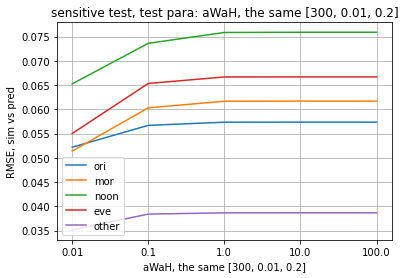

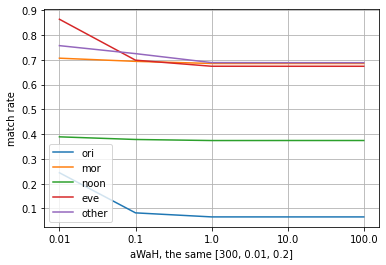

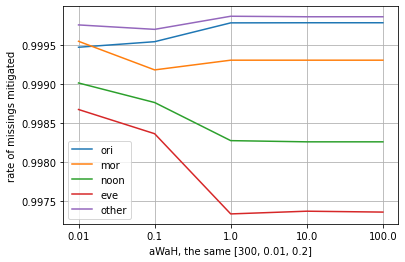

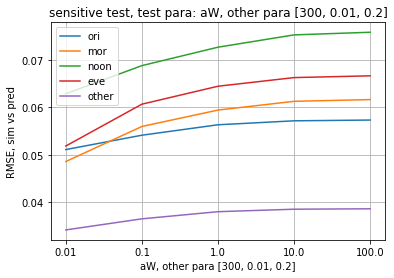

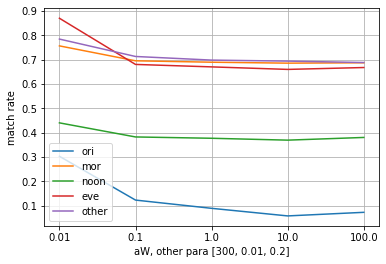

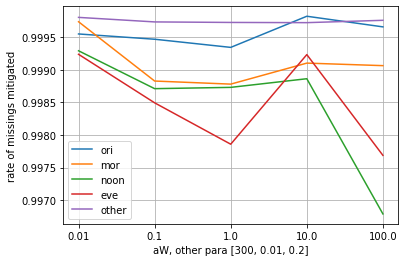

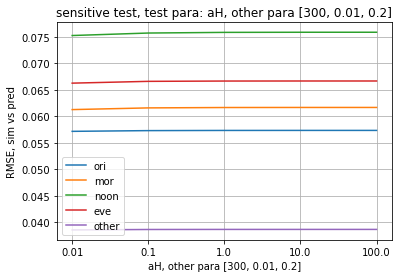

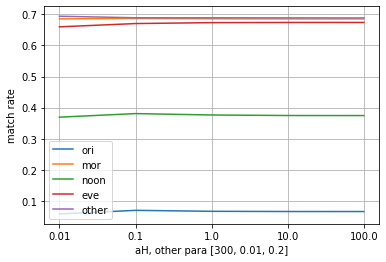

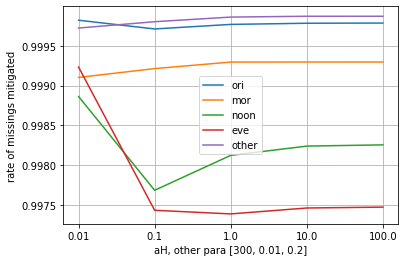

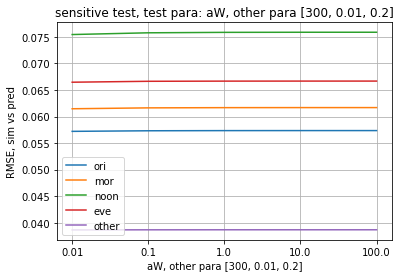

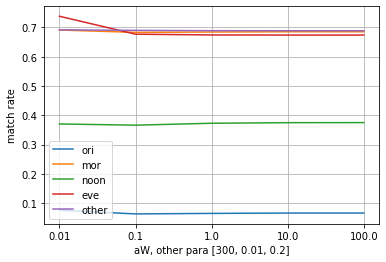

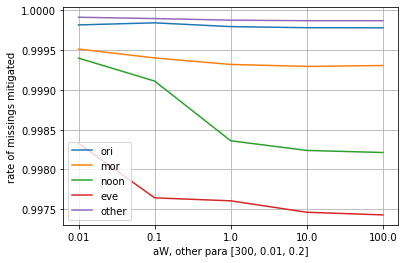

In [107]:
idx = plot_paras_sensitive(test_aWaH_nmf1, aWaH_nmf_1, 'aWaH, the same '+str([300, 0.01, 0.2]), 1, 1)
#idx = plot_paras_sensitive(test_aWaH_nmf3, aWaH_nmf_3, 'aH, other para '+str([300, 0.01, 0.2]), 2, idx)
idx = plot_paras_sensitive(test_aWaH_nmf4, aWaH_nmf_4, 'aW, other para '+str([300, 0.01, 0.2]), 1, idx)
idx = plot_paras_sensitive(test_aWaH_nmf5, aWaH_nmf_5, 'aH, other para '+str([300, 0.01, 0.2]), 2, idx)
idx = plot_paras_sensitive(test_aWaH_nmf6, aWaH_nmf_6, 'aW, other para '+str([300, 0.01, 0.2]), 1, idx)

###### l1 RATIO

In [11]:
l1_ratio_nmf_1 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [300, 0.01, 0.01], 4)
l1_ratio_nmf_2 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [300, 10, 10], 4)
l1_ratio_nmf_3 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [300, 0.1, 0.01], 4)
l1_ratio_nmf_4 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [300, 0.01, 0.1], 4)
l1_ratio_nmf_5 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [300, 0.01, 10], 4)
l1_ratio_nmf_6 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [300, 10, 0.01], 4)

In [109]:
test_l1_nmf_1 = fit_model_get_para_sensitive(test_matrice_reverse, l1_ratio_nmf_1,
                                            missing_val, 288, result_para_dict, 'NMF', True)
test_l1_nmf_2 = fit_model_get_para_sensitive(test_matrice_reverse, l1_ratio_nmf_2,
                                            missing_val, 288, result_para_dict, 'NMF', True)
test_l1_nmf_3 = fit_model_get_para_sensitive(test_matrice_reverse, l1_ratio_nmf_3,
                                            missing_val, 288, result_para_dict, 'NMF', True)
test_l1_nmf_4 = fit_model_get_para_sensitive(test_matrice_reverse, l1_ratio_nmf_4,
                                            missing_val, 288, result_para_dict, 'NMF', True)
test_l1_nmf_5 = fit_model_get_para_sensitive(test_matrice_reverse, l1_ratio_nmf_5,
                                            missing_val, 288, result_para_dict, 'NMF', True)
test_l1_nmf_6 = fit_model_get_para_sensitive(test_matrice_reverse, l1_ratio_nmf_6,
                                            missing_val, 288, result_para_dict, 'NMF', True)

C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.0], 0.04467559668840852
matched % compared with raw dt 0.5017792512481581
% of missings mitigated 0.9994984153874314


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.0],mor, 0.01811834296465937
matched % compared with raw dtmor, 0.9590003290273665
% of missings mitigatedmor, 0.9991277041172366


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.0],noon, 0.047411304241413633
matched % compared with raw dtnoon, 0.7971532874125574
% of missings mitigatednoon, 0.9986181726821335
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.0],eve, 0.02005818185297559
matched % compared with raw dteve, 0.9628979749489599
% of missings mitigatedeve, 0.9989093793376959


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.0],other, 0.025839492773634076
matched % compared with raw dtother, 0.832480498655575
% of missings mitigatedother, 0.9998666124647476


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.1], 0.04467559668840852
matched % compared with raw dt 0.5017792512481581
% of missings mitigated 0.9994984153874314


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.1],mor, 0.01811834296465937
matched % compared with raw dtmor, 0.9590003290273665
% of missings mitigatedmor, 0.9991277041172366


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.1],noon, 0.047411304241413633
matched % compared with raw dtnoon, 0.7971532874125574
% of missings mitigatednoon, 0.9986181726821335
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.1],eve, 0.02005818185297559
matched % compared with raw dteve, 0.9628979749489599
% of missings mitigatedeve, 0.9989093793376959


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.1],other, 0.025839492773634076
matched % compared with raw dtother, 0.832480498655575
% of missings mitigatedother, 0.9998666124647476


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.2], 0.04467559668840852
matched % compared with raw dt 0.5017792512481581
% of missings mitigated 0.9994984153874314


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.2],mor, 0.01811834296465937
matched % compared with raw dtmor, 0.9590003290273665
% of missings mitigatedmor, 0.9991277041172366


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.2],noon, 0.047411304241413633
matched % compared with raw dtnoon, 0.7971532874125574
% of missings mitigatednoon, 0.9986181726821335
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.2],eve, 0.02005818185297559
matched % compared with raw dteve, 0.9628979749489599
% of missings mitigatedeve, 0.9989093793376959


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.2],other, 0.025839492773634076
matched % compared with raw dtother, 0.832480498655575
% of missings mitigatedother, 0.9998666124647476


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.3], 0.04467559668840852
matched % compared with raw dt 0.5017792512481581
% of missings mitigated 0.9994984153874314


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.3],mor, 0.01811834296465937
matched % compared with raw dtmor, 0.9590003290273665
% of missings mitigatedmor, 0.9991277041172366


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.3],noon, 0.047411304241413633
matched % compared with raw dtnoon, 0.7971532874125574
% of missings mitigatednoon, 0.9986181726821335
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.3],eve, 0.02005818185297559
matched % compared with raw dteve, 0.9628979749489599
% of missings mitigatedeve, 0.9989093793376959


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.3],other, 0.025839492773634076
matched % compared with raw dtother, 0.832480498655575
% of missings mitigatedother, 0.9998666124647476


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.4], 0.04467559668840852
matched % compared with raw dt 0.5017792512481581
% of missings mitigated 0.9994984153874314


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.4],mor, 0.01811834296465937
matched % compared with raw dtmor, 0.9590003290273665
% of missings mitigatedmor, 0.9991277041172366


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.4],noon, 0.047411304241413633
matched % compared with raw dtnoon, 0.7971532874125574
% of missings mitigatednoon, 0.9986181726821335
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.4],eve, 0.02005818185297559
matched % compared with raw dteve, 0.9628979749489599
% of missings mitigatedeve, 0.9989093793376959


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.4],other, 0.025839492773634076
matched % compared with raw dtother, 0.832480498655575
% of missings mitigatedother, 0.9998666124647476


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.5], 0.04467559668840852
matched % compared with raw dt 0.5017792512481581
% of missings mitigated 0.9994984153874314


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.5],mor, 0.01811834296465937
matched % compared with raw dtmor, 0.9590003290273665
% of missings mitigatedmor, 0.9991277041172366


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.5],noon, 0.047411304241413633
matched % compared with raw dtnoon, 0.7971532874125574
% of missings mitigatednoon, 0.9986181726821335
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.5],eve, 0.02005818185297559
matched % compared with raw dteve, 0.9628979749489599
% of missings mitigatedeve, 0.9989093793376959


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.5],other, 0.025839492773634076
matched % compared with raw dtother, 0.832480498655575
% of missings mitigatedother, 0.9998666124647476


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.6], 0.04467559668840852
matched % compared with raw dt 0.5017792512481581
% of missings mitigated 0.9994984153874314


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.6],mor, 0.01811834296465937
matched % compared with raw dtmor, 0.9590003290273665
% of missings mitigatedmor, 0.9991277041172366


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.6],noon, 0.047411304241413633
matched % compared with raw dtnoon, 0.7971532874125574
% of missings mitigatednoon, 0.9986181726821335
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.6],eve, 0.02005818185297559
matched % compared with raw dteve, 0.9628979749489599
% of missings mitigatedeve, 0.9989093793376959


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.6],other, 0.025839492773634076
matched % compared with raw dtother, 0.832480498655575
% of missings mitigatedother, 0.9998666124647476


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.7], 0.04467559668840852
matched % compared with raw dt 0.5017792512481581
% of missings mitigated 0.9994984153874314


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.7],mor, 0.01811834296465937
matched % compared with raw dtmor, 0.9590003290273665
% of missings mitigatedmor, 0.9991277041172366


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.7],noon, 0.047411304241413633
matched % compared with raw dtnoon, 0.7971532874125574
% of missings mitigatednoon, 0.9986181726821335
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.7],eve, 0.02005818185297559
matched % compared with raw dteve, 0.9628979749489599
% of missings mitigatedeve, 0.9989093793376959


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.7],other, 0.025839492773634076
matched % compared with raw dtother, 0.832480498655575
% of missings mitigatedother, 0.9998666124647476


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.8], 0.04467559668840852
matched % compared with raw dt 0.5017792512481581
% of missings mitigated 0.9994984153874314


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.8],mor, 0.01811834296465937
matched % compared with raw dtmor, 0.9590003290273665
% of missings mitigatedmor, 0.9991277041172366


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.8],noon, 0.047411304241413633
matched % compared with raw dtnoon, 0.7971532874125574
% of missings mitigatednoon, 0.9986181726821335
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.8],eve, 0.02005818185297559
matched % compared with raw dteve, 0.9628979749489599
% of missings mitigatedeve, 0.9989093793376959


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.8],other, 0.025839492773634076
matched % compared with raw dtother, 0.832480498655575
% of missings mitigatedother, 0.9998666124647476


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.9], 0.04467559668840852
matched % compared with raw dt 0.5017792512481581
% of missings mitigated 0.9994984153874314


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.9],mor, 0.01811834296465937
matched % compared with raw dtmor, 0.9590003290273665
% of missings mitigatedmor, 0.9991277041172366


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.9],noon, 0.047411304241413633
matched % compared with raw dtnoon, 0.7971532874125574
% of missings mitigatednoon, 0.9986181726821335
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.9],eve, 0.02005818185297559
matched % compared with raw dteve, 0.9628979749489599
% of missings mitigatedeve, 0.9989093793376959


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 0.9],other, 0.025839492773634076
matched % compared with raw dtother, 0.832480498655575
% of missings mitigatedother, 0.9998666124647476


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 1.0], 0.04467559668840852
matched % compared with raw dt 0.5017792512481581
% of missings mitigated 0.9994984153874314


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 1.0],mor, 0.01811834296465937
matched % compared with raw dtmor, 0.9590003290273665
% of missings mitigatedmor, 0.9991277041172366


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 1.0],noon, 0.047411304241413633
matched % compared with raw dtnoon, 0.7971532874125574
% of missings mitigatednoon, 0.9986181726821335
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 1.0],eve, 0.02005818185297559
matched % compared with raw dteve, 0.9628979749489599
% of missings mitigatedeve, 0.9989093793376959


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.0, 1.0],other, 0.025839492773634076
matched % compared with raw dtother, 0.832480498655575
% of missings mitigatedother, 0.9998666124647476
RMSE, data with missing rate>=0.0, para=[300, 10, 10, 0.0], 0.05730340622798253
matched % compared with raw dt 0.012227211278485903
% of missings mitigated 1.0
RMSE, data with missing rate>=0.0, para=[300, 10, 10, 0.0],mor, 0.061611180809809575
matched % compared with raw dtmor, 0.6421219404031301
% of missings mitigatedmor, 1.0
RMSE, data with missing rate>=0.0, para=[300, 10, 10, 0.0],noon, 0.07574381453257908
matched % compared with raw dtnoon, 0.29952308913780523
% of missings mitigatednoon, 1.0
RMSE, data with missing rate>=0.0, para=[300, 10, 10, 0.0],eve, 0.06659527120152953
matched % compared with raw dteve, 0.6142765178686383
% of missings mitigatedeve, 1.0
RMSE, data with missing rate>=0.0, para=[300, 10, 10, 0.0],other, 0.03865210819892786
matched % compared with raw dtother, 0.6567061

RMSE, data with missing rate>=0.0, para=[300, 10, 10, 0.8],other, 0.0386736366929245
matched % compared with raw dtother, 0.6885605235968661
% of missings mitigatedother, 0.9998633380367826
RMSE, data with missing rate>=0.0, para=[300, 10, 10, 0.9], 0.057356936516350314
matched % compared with raw dt 0.06568119394017424
% of missings mitigated 0.9997870786909311
RMSE, data with missing rate>=0.0, para=[300, 10, 10, 0.9],mor, 0.06168878711131697
matched % compared with raw dtmor, 0.6855177889360972
% of missings mitigatedmor, 0.9993062900162624
RMSE, data with missing rate>=0.0, para=[300, 10, 10, 0.9],noon, 0.07588149400109706
matched % compared with raw dtnoon, 0.37396463671087077
% of missings mitigatednoon, 0.9982840322884711
RMSE, data with missing rate>=0.0, para=[300, 10, 10, 0.9],eve, 0.0666816362263997
matched % compared with raw dteve, 0.6741599073001159
% of missings mitigatedeve, 0.9973356815462079
RMSE, data with missing rate>=0.0, para=[300, 10, 10, 0.9],other, 0.038673639

C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.0], 0.044415265479325026
matched % compared with raw dt 0.6203779701872595
% of missings mitigated 0.9994159036712102
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.0],mor, 0.019002064461463884
matched % compared with raw dtmor, 0.9676587557043331
% of missings mitigatedmor, 0.9992259206015702
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.0],noon, 0.0472582013170139
matched % compared with raw dtnoon, 0.8117704175786447
% of missings mitigatednoon, 0.9986889918061987
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.0],eve, 0.020922023659150527
matched % compared with raw dteve, 0.9694127168055325
% of missings mitigatedeve, 0.9981960312687913
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.0],other, 0.02552028975772095
matched % compared with raw dtother, 0.9040749856087473
% of missings mitigatedother, 0.9998003349935108


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.1], 0.044718340533601526
matched % compared with raw dt 0.5176038582035106
% of missings mitigated 0.9995375647548351
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.1],mor, 0.01818110933298164
matched % compared with raw dtmor, 0.9604451883324034
% of missings mitigatedmor, 0.9987341772151899


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.1],noon, 0.047249498615249505
matched % compared with raw dtnoon, 0.8021651431269045
% of missings mitigatednoon, 0.9985967243342915
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.1],eve, 0.020337461543803843
matched % compared with raw dteve, 0.9690301458551748
% of missings mitigatedeve, 0.9984558736191946


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.1],other, 0.025753431563146773
matched % compared with raw dtother, 0.8514567352658577
% of missings mitigatedother, 0.9998782252403261


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.2], 0.04473195204969759
matched % compared with raw dt 0.5019535999885556
% of missings mitigated 0.9995592768190378
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.2],mor, 0.01837391796103625
matched % compared with raw dtmor, 0.9558173468949831
% of missings mitigatedmor, 0.9991905455722843


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.2],noon, 0.04730233623057957
matched % compared with raw dtnoon, 0.7979257864469336
% of missings mitigatednoon, 0.9986726221685371
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.2],eve, 0.02012450248982644
matched % compared with raw dteve, 0.9622983685556107
% of missings mitigatedeve, 0.9989267245584935


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.2],other, 0.025931122382722382
matched % compared with raw dtother, 0.8370293049530382
% of missings mitigatedother, 0.9998824766095807


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.3], 0.0447612887633457
matched % compared with raw dt 0.49830792312204053
% of missings mitigated 0.9995526775633937


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.3],mor, 0.018012434482634718
matched % compared with raw dtmor, 0.9590933150222452
% of missings mitigatedmor, 0.9992131491519496


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.3],noon, 0.04733639472420206
matched % compared with raw dtnoon, 0.7960320908973864
% of missings mitigatednoon, 0.998606042673505


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.3],eve, 0.019999395909021445
matched % compared with raw dteve, 0.9411686806820063
% of missings mitigatedeve, 0.9993121990871006


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.3],other, 0.02590017625933717
matched % compared with raw dtother, 0.8354470651953008
% of missings mitigatedother, 0.9998771403445244


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.4], 0.044752231713155025
matched % compared with raw dt 0.49582501823956054
% of missings mitigated 0.9995371466420521
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.4],mor, 0.01814778400784816
matched % compared with raw dtmor, 0.9487361057465344
% of missings mitigatedmor, 0.999232593832845


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.4],noon, 0.04733859221682258
matched % compared with raw dtnoon, 0.7952730033045792
% of missings mitigatednoon, 0.9985915585223811


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.4],eve, 0.019967212666192707
matched % compared with raw dteve, 0.9409222167043719
% of missings mitigatedeve, 0.9993773349937733
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.4],other, 0.025872298969685695
matched % compared with raw dtother, 0.8271496168894251
% of missings mitigatedother, 0.999870726272115


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.5], 0.044741873654745495
matched % compared with raw dt 0.49446196872809467
% of missings mitigated 0.9995154027639729
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.5],mor, 0.018022078719441087
matched % compared with raw dtmor, 0.9575268586469823
% of missings mitigatedmor, 0.9991579656449984


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.5],noon, 0.0472873553362628
matched % compared with raw dtnoon, 0.7945675614780482
% of missings mitigatednoon, 0.9985833382296297
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.5],eve, 0.020247753133011245
matched % compared with raw dteve, 0.9349850098401663
% of missings mitigatedeve, 0.9993776168382935


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.5],other, 0.025846210196407156
matched % compared with raw dtother, 0.8322432158943273
% of missings mitigatedother, 0.9998541155278163


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.6], 0.044735704555297524
matched % compared with raw dt 0.4931548002231664
% of missings mitigated 0.999511360429015
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.6],mor, 0.018033739671933665
matched % compared with raw dtmor, 0.9549125216371257
% of missings mitigatedmor, 0.9992067898786389


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.6],noon, 0.04726745083696422
matched % compared with raw dtnoon, 0.7946453478391485
% of missings mitigatednoon, 0.9985828016118182
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.6],eve, 0.020249471154455696
matched % compared with raw dteve, 0.9350880097114165
% of missings mitigatedeve, 0.9993766292644225


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.6],other, 0.025804787798225683
matched % compared with raw dtother, 0.8324219760014556
% of missings mitigatedother, 0.9998666590471836


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.7], 0.044732705708640685
matched % compared with raw dt 0.4929406642061142
% of missings mitigated 0.9995018686537847


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.7],mor, 0.017938064985997506
matched % compared with raw dtmor, 0.9594831409238517
% of missings mitigatedmor, 0.9991173095595375


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.7],noon, 0.04727167431294843
matched % compared with raw dtnoon, 0.7945863374962447
% of missings mitigatednoon, 0.9985832087384029
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.7],eve, 0.020251415044972902
matched % compared with raw dteve, 0.9349371884713715
% of missings mitigatedeve, 0.9993780742918528


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.7],other, 0.025819237518537104
matched % compared with raw dtother, 0.8323113149827571
% of missings mitigatedother, 0.9998540562835115


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.8], 0.0447158478921087
matched % compared with raw dt 0.49289283006451795
% of missings mitigated 0.999502797206496
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.8],mor, 0.0179975339924239
matched % compared with raw dtmor, 0.9558674162768408
% of missings mitigatedmor, 0.9991896272285251


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.8],noon, 0.047276609517355864
matched % compared with raw dtnoon, 0.7946828998755419
% of missings mitigatednoon, 0.998589074472046
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.8],eve, 0.020248826603158698
matched % compared with raw dteve, 0.9349592598723537
% of missings mitigatedeve, 0.9993778632430292


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.8],other, 0.025830710975729445
matched % compared with raw dtother, 0.8322453439908407
% of missings mitigatedother, 0.9998604565607616


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.9], 0.04471928222474394
matched % compared with raw dt 0.4920948492911606
% of missings mitigated 0.9995088594537074
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.9],mor, 0.017997388003971514
matched % compared with raw dtmor, 0.955896027352188
% of missings mitigatedmor, 0.9991891015244891


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.9],noon, 0.04727819758224466
matched % compared with raw dtnoon, 0.7946882644521694
% of missings mitigatednoon, 0.9985955698393724
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.9],eve, 0.020247069322774865
matched % compared with raw dteve, 0.9348341886001214
% of missings mitigatedeve, 0.9993790572960768


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 0.9],other, 0.0258249339516172
matched % compared with raw dtother, 0.8323879264572407
% of missings mitigatedother, 0.9998666861347232


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 1.0], 0.044718500298447934
matched % compared with raw dt 0.49108541478906487
% of missings mitigated 0.9995063198959231
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 1.0],mor, 0.017997376743613524
matched % compared with raw dtmor, 0.956192867258916
% of missings mitigatedmor, 0.9991836068250469


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 1.0],noon, 0.04728093413744406
matched % compared with raw dtnoon, 0.7944683168104373
% of missings mitigatednoon, 0.9986035980189363


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 1.0],eve, 0.020004802612970378
matched % compared with raw dteve, 0.940841288234104
% of missings mitigatedeve, 0.9993160054719562
RMSE, data with missing rate>=0.0, para=[300, 0.1, 0.0, 1.0],other, 0.025832445574642246
matched % compared with raw dtother, 0.826639937774458
% of missings mitigatedother, 0.9998649685438085


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.0], 0.045184674369485624
matched % compared with raw dt 0.29778317811824956
% of missings mitigated 0.9996721386617909
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.0],mor, 0.019262185236847817
matched % compared with raw dtmor, 0.9170064231864155
% of missings mitigatedmor, 0.9995690769628545


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.0],noon, 0.04801399344306975
matched % compared with raw dtnoon, 0.7293597914252608
% of missings mitigatednoon, 0.9990733307564991
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.0],eve, 0.020740946663916796
matched % compared with raw dteve, 0.9372031856388751
% of missings mitigatedeve, 0.9992970534825142


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.0],other, 0.026216113085868843
matched % compared with raw dtother, 0.7811752838614737
% of missings mitigatedother, 0.9998784360062825


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.1], 0.04474302279740557
matched % compared with raw dt 0.5057517202409052
% of missings mitigated 0.9995260414876509
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.1],mor, 0.01840190604794459
matched % compared with raw dtmor, 0.9547587371071342
% of missings mitigatedmor, 0.9991304347826087


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.1],noon, 0.04765019679585748
matched % compared with raw dtnoon, 0.8001051457019012
% of missings mitigatednoon, 0.9986313134023939
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.1],eve, 0.020262615963323367
matched % compared with raw dteve, 0.9641854733395869
% of missings mitigatedeve, 0.9987674609695973


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.1],other, 0.025792202893395583
matched % compared with raw dtother, 0.8311163887904645
% of missings mitigatedother, 0.9998613893824267


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.2], 0.04477351680387812
matched % compared with raw dt 0.5039961625395191
% of missings mitigated 0.9995105943259586


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.2],mor, 0.018386336947391065
matched % compared with raw dtmor, 0.9574696364962877
% of missings mitigatedmor, 0.9989909182643795


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.2],noon, 0.0474618132800123
matched % compared with raw dtnoon, 0.8038938779451525
% of missings mitigatednoon, 0.9985296430794061
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.2],eve, 0.02021750153410833
matched % compared with raw dteve, 0.9629531534514153
% of missings mitigatedeve, 0.9989077549399266


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.2],other, 0.025726723410401206
matched % compared with raw dtother, 0.8332221402905065
% of missings mitigatedother, 0.9998532592398829


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.3], 0.044744829199146956
matched % compared with raw dt 0.5026425010371515
% of missings mitigated 0.9994975448007571


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.3],mor, 0.01835668094710606
matched % compared with raw dtmor, 0.9551485630087407
% of missings mitigatedmor, 0.9991228769635595


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.3],noon, 0.047412030706526304
matched % compared with raw dtnoon, 0.8057245397193253
% of missings mitigatednoon, 0.9985503044360684


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.3],eve, 0.0199008529699925
matched % compared with raw dteve, 0.9660357924552594
% of missings mitigatedeve, 0.9988086212498646


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.3],other, 0.025725727854938086
matched % compared with raw dtother, 0.8337988544456468
% of missings mitigatedother, 0.9998655543960512


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.4], 0.044726352887432756
matched % compared with raw dt 0.5034954687209419
% of missings mitigated 0.9994939804381121
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.4],mor, 0.0183867336085696
matched % compared with raw dtmor, 0.9548803341773601
% of missings mitigatedmor, 0.9989695624603678


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.4],noon, 0.047407729090799024
matched % compared with raw dtnoon, 0.8058653598558002
% of missings mitigatednoon, 0.9985285279061574


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.4],eve, 0.019887111317417102
matched % compared with raw dteve, 0.9649138295719988
% of missings mitigatedeve, 0.9988467183895995


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.4],other, 0.02576544069735429
matched % compared with raw dtother, 0.8340989160540409
% of missings mitigatedother, 0.9998717249783536


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.5], 0.044724527060010226
matched % compared with raw dt 0.503544644006695
% of missings mitigated 0.9994930298355994


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.5],mor, 0.018318782688423928
matched % compared with raw dtmor, 0.9580525871564882
% of missings mitigatedmor, 0.9988916361156108


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.5],noon, 0.04741019388273429
matched % compared with raw dtnoon, 0.8063186665808334
% of missings mitigatednoon, 0.9985112349825157


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.5],eve, 0.019891527974177394
matched % compared with raw dteve, 0.965322150490169
% of missings mitigatedeve, 0.9988331388564761


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.5],other, 0.025771858514174295
matched % compared with raw dtother, 0.8340297529173543
% of missings mitigatedother, 0.9998589562764457


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.6], 0.044717257911531354
matched % compared with raw dt 0.5040113621732972
% of missings mitigated 0.9994970594199959


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.6],mor, 0.018366650886943475
matched % compared with raw dtmor, 0.9555848819077865
% of missings mitigatedmor, 0.9989532168451566


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.6],noon, 0.0474069739863803
matched % compared with raw dtnoon, 0.8066794343590404
% of missings mitigatednoon, 0.99850845670362


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.6],eve, 0.0199350197243379
matched % compared with raw dteve, 0.9655870073019551
% of missings mitigatedeve, 0.9988241582041689


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.6],other, 0.02577372055876537
matched % compared with raw dtother, 0.8340542260272588
% of missings mitigatedother, 0.9998589354758042


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.7], 0.04472059594764075
matched % compared with raw dt 0.5036926169120066
% of missings mitigated 0.9994964816769772


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.7],mor, 0.01837285692505784
matched % compared with raw dtmor, 0.9556349512896443
% of missings mitigatedmor, 0.9989520354695687


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.7],noon, 0.04739165812294414
matched % compared with raw dtnoon, 0.8066821166473542
% of missings mitigatednoon, 0.998494560994561


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.7],eve, 0.019946363101633478
matched % compared with raw dteve, 0.9656900071732053
% of missings mitigatedeve, 0.9988206282834781


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.7],other, 0.025780028262050548
matched % compared with raw dtother, 0.8342244737483334
% of missings mitigatedother, 0.9998716278233856


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.8], 0.04471772788077811
matched % compared with raw dt 0.5043900118735962
% of missings mitigated 0.9994957731538442


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.8],mor, 0.018376552899980515
matched % compared with raw dtmor, 0.9556277985208074
% of missings mitigatedmor, 0.9989522044007415


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.8],noon, 0.04738190612587507
matched % compared with raw dtnoon, 0.8066164005836659
% of missings mitigatednoon, 0.9984950725763386


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.8],eve, 0.019983614256557855
matched % compared with raw dteve, 0.9652743291213743
% of missings mitigatedeve, 0.9988347457627119


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.8],other, 0.02577693017424328
matched % compared with raw dtother, 0.8344543081717842
% of missings mitigatedother, 0.9998714495986014


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.9], 0.04471685660594815
matched % compared with raw dt 0.50429747292677
% of missings mitigated 0.9995003765213039
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.9],mor, 0.0189829056038927
matched % compared with raw dtmor, 0.9436039941061185
% of missings mitigatedmor, 0.9991121821294946


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.9],noon, 0.047380261253923334
matched % compared with raw dtnoon, 0.8068256190721428
% of missings mitigatednoon, 0.998493442657095


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.9],eve, 0.01998456828016926
matched % compared with raw dteve, 0.9652780076882047
% of missings mitigatedeve, 0.9990465091641064


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 0.9],other, 0.025777626359739417
matched % compared with raw dtother, 0.834635196375426
% of missings mitigatedother, 0.9998777435316677


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 1.0], 0.04471766101628146
matched % compared with raw dt 0.5044458928801339
% of missings mitigated 0.9994984226474805
RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 1.0],mor, 0.018983469078908164
matched % compared with raw dtmor, 0.9436469107191394
% of missings mitigatedmor, 0.9991115059973346


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 1.0],noon, 0.04738045304716222
matched % compared with raw dtnoon, 0.807155540534741
% of missings mitigatednoon, 0.9984630470613599


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 1.0],eve, 0.01998524435305314
matched % compared with raw dteve, 0.9647151869631592
% of missings mitigatedeve, 0.9990617180984154


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 0.1, 1.0],other, 0.025778250165410375
matched % compared with raw dtother, 0.8346575413888171
% of missings mitigatedother, 0.9998712915889053


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.0], 0.045360863376967195
matched % compared with raw dt 0.28229922177875055
% of missings mitigated 0.9997053734158371


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.0],mor, 0.020333904074092354
matched % compared with raw dtmor, 0.8977869333218889
% of missings mitigatedmor, 0.9997550734779567


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.0],noon, 0.04805144841135464
matched % compared with raw dtnoon, 0.7388175400197416
% of missings mitigatednoon, 0.9991167982911074
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.0],eve, 0.02109193331101139
matched % compared with raw dteve, 0.8815427909286542
% of missings mitigatedeve, 0.9994720824793492


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.0],other, 0.025955187573280077
matched % compared with raw dtother, 0.7712817631705233
% of missings mitigatedother, 0.9998557810849915


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.1], 0.04468343318550347
matched % compared with raw dt 0.5163847581648856
% of missings mitigated 0.9994971330110918
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.1],mor, 0.01838376472912637
matched % compared with raw dtmor, 0.9574338726521037
% of missings mitigatedmor, 0.9991598050747773


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.1],noon, 0.047399802746571074
matched % compared with raw dtnoon, 0.8077080919273851
% of missings mitigatednoon, 0.9985632484533997
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.1],eve, 0.02049395027637955
matched % compared with raw dteve, 0.9612610127094484
% of missings mitigatedeve, 0.99905042256196
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.1],other, 0.025848629484336937
matched % compared with raw dtother, 0.8219208837559201
% of missings mitigatedother, 0.9998804971319312


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.2], 0.04475393972247698
matched % compared with raw dt 0.5103634679484429
% of missings mitigated 0.9994914477396358
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.2],mor, 0.018623749574389822
matched % compared with raw dtmor, 0.9541543281404231
% of missings mitigatedmor, 0.9989078711287932


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.2],noon, 0.04743171876915531
matched % compared with raw dtnoon, 0.8072547852023518
% of missings mitigatednoon, 0.99849704627845
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.2],eve, 0.020394228849286173
matched % compared with raw dteve, 0.9636447240155236
% of missings mitigatedeve, 0.9988869776383689
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.2],other, 0.025773251084104477
matched % compared with raw dtother, 0.8247938140490547
% of missings mitigatedother, 0.9998785375926151


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.3], 0.04474090884907015
matched % compared with raw dt 0.5076074167060068
% of missings mitigated 0.9994924784212538
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.3],mor, 0.018875324225367435
matched % compared with raw dtmor, 0.9429030227601104
% of missings mitigatedmor, 0.9991230817413091


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.3],noon, 0.047399003106042184
matched % compared with raw dtnoon, 0.8085087549890563
% of missings mitigatednoon, 0.9985222226891345


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.3],eve, 0.019974630514787657
matched % compared with raw dteve, 0.9671430410711986
% of missings mitigatedeve, 0.9987684729064039


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.3],other, 0.025731985313986402
matched % compared with raw dtother, 0.8346234918446022
% of missings mitigatedother, 0.9998713180888162


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.4], 0.044726561449128115
matched % compared with raw dt 0.5073959629772685
% of missings mitigated 0.999490881238293


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.4],mor, 0.018355854391149867
matched % compared with raw dtmor, 0.9558531107391671
% of missings mitigatedmor, 0.998946856772521


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.4],noon, 0.04737031886154281
matched % compared with raw dtnoon, 0.8087984421269473
% of missings mitigatednoon, 0.9985129694317018


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.4],eve, 0.019893877192036523
matched % compared with raw dteve, 0.9665507918115103
% of missings mitigatedeve, 0.9987902782360057


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.4],other, 0.025769843079968602
matched % compared with raw dtother, 0.8346437087614798
% of missings mitigatedother, 0.9998713023558103


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.5], 0.0447246515547553
matched % compared with raw dt 0.5076503333190278
% of missings mitigated 0.9994897102153296


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.5],mor, 0.01840637520857112
matched % compared with raw dtmor, 0.9558388052014934
% of missings mitigatedmor, 0.9989471979267898


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.5],noon, 0.04736110214216091
matched % compared with raw dtnoon, 0.8087783249645938
% of missings mitigatednoon, 0.998492085200693


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.5],eve, 0.019892603249834353
matched % compared with raw dteve, 0.9671283268038772
% of missings mitigatedeve, 0.998769024171889


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.5],other, 0.02578558313687923
matched % compared with raw dtother, 0.8348671588953902
% of missings mitigatedother, 0.9998711282081022


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.6], 0.04472179304373068
matched % compared with raw dt 0.508146556657082
% of missings mitigated 0.9994910132018451
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.6],mor, 0.01902717158553076
matched % compared with raw dtmor, 0.9454136446218331
% of missings mitigatedmor, 0.9990827491318875


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.6],noon, 0.047411024343046636
matched % compared with raw dtnoon, 0.8090103429037381
% of missings mitigatednoon, 0.9984832312791416


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.6],eve, 0.019990637071024078
matched % compared with raw dteve, 0.9666979344847247
% of missings mitigatedeve, 0.9987849331713244


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.6],other, 0.025778451111166372
matched % compared with raw dtother, 0.8351470035869066
% of missings mitigatedother, 0.9998773639708255


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.7], 0.04472507745121928
matched % compared with raw dt 0.5074831373474672
% of missings mitigated 0.9994935141675343
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.7],mor, 0.018406603538045865
matched % compared with raw dtmor, 0.9550126604008412
% of missings mitigatedmor, 0.9989665315207886


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.7],noon, 0.04739470893839615
matched % compared with raw dtnoon, 0.8089473091283635
% of missings mitigatednoon, 0.9984767119441227


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.7],eve, 0.01999378187070035
matched % compared with raw dteve, 0.9666795416505729
% of missings mitigatedeve, 0.9987856038860675


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.7],other, 0.025781127015814895
matched % compared with raw dtother, 0.8352512803160649
% of missings mitigatedother, 0.9998837449622817


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.8], 0.044727101497671236
matched % compared with raw dt 0.5077965180321302
% of missings mitigated 0.9994922834348161


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.8],mor, 0.018370890417769983
matched % compared with raw dtmor, 0.9567936998412085
% of missings mitigatedmor, 0.9989239301382336


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.8],noon, 0.047384841865824326
matched % compared with raw dtnoon, 0.8092651602935497
% of missings mitigatednoon, 0.9984741734520244


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.8],eve, 0.019996284334123506
matched % compared with raw dteve, 0.9661240780591881
% of missings mitigatedeve, 0.9990226951894885


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.8],other, 0.025784736958785453
matched % compared with raw dtother, 0.8353736458655873
% of missings mitigatedother, 0.9998771951369274


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.9], 0.04472834620590987
matched % compared with raw dt 0.5082444601805359
% of missings mitigated 0.9994945482115553
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.9],mor, 0.018978569732924534
matched % compared with raw dtmor, 0.9466510736306024
% of missings mitigatedmor, 0.999061473486626


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.9],noon, 0.047383540628053944
matched % compared with raw dtnoon, 0.8094784022144972
% of missings mitigatednoon, 0.9984513476794853
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.9],eve, 0.02005600306004072
matched % compared with raw dteve, 0.964814508267579
% of missings mitigatedeve, 0.9990590695243073


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 0.9],other, 0.02578381993782526
matched % compared with raw dtother, 0.8354172718441126
% of missings mitigatedother, 0.9998836277121208


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 1.0], 0.04473511791387082
matched % compared with raw dt 0.5088528925797177
% of missings mitigated 0.999490281210036
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 1.0],mor, 0.01897524142231121
matched % compared with raw dtmor, 0.946726177703389
% of missings mitigatedmor, 0.9990601503759399


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 1.0],noon, 0.04738544483278731
matched % compared with raw dtnoon, 0.8096379983691687
% of missings mitigatednoon, 0.9984359588558546


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 1.0],eve, 0.019995008207396994
matched % compared with raw dteve, 0.9656127572697677
% of missings mitigatedeve, 0.9990372272143774
RMSE, data with missing rate>=0.0, para=[300, 0.0, 10, 1.0],other, 0.025805612200163933
matched % compared with raw dtother, 0.8264984193563146
% of missings mitigatedother, 0.9998834770449778


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.0], 0.04436037448972684
matched % compared with raw dt 0.6220901642275725
% of missings mitigated 0.9994511116762979
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.0],mor, 0.018512903859793102
matched % compared with raw dtmor, 0.9668755275167017
% of missings mitigatedmor, 0.9984884474195638


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.0],noon, 0.04713594981995554
matched % compared with raw dtnoon, 0.8189924788635681
% of missings mitigatednoon, 0.9986440929129774
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.0],eve, 0.021159303883138983
matched % compared with raw dteve, 0.9688830031819603
% of missings mitigatedeve, 0.9988178271663317
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.0],other, 0.025564976587527197
matched % compared with raw dtother, 0.9005540499272723
% of missings mitigatedother, 0.9997539054140809


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.1], 0.04477104024889713
matched % compared with raw dt 0.4925173097005851
% of missings mitigated 0.999563948110706
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.1],mor, 0.018122730276256868
matched % compared with raw dtmor, 0.9530921419681558
% of missings mitigatedmor, 0.9992375724306191


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.1],noon, 0.047335863305544526
matched % compared with raw dtnoon, 0.7930976674820823
% of missings mitigatednoon, 0.9986711867922449
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.1],eve, 0.02036304243762118
matched % compared with raw dteve, 0.9566701613051555
% of missings mitigatedeve, 0.9988963409457509


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.1],other, 0.02585315941226139
matched % compared with raw dtother, 0.8352725612811992
% of missings mitigatedother, 0.999851432705475


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.2], 0.0447574509605304
matched % compared with raw dt 0.49425096204740854
% of missings mitigated 0.9995544979793302
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.2],mor, 0.01837637580041928
matched % compared with raw dtmor, 0.9445731942835072
% of missings mitigatedmor, 0.9992902309975481


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.2],noon, 0.04734562162357807
matched % compared with raw dtnoon, 0.7921910540320158
% of missings mitigatednoon, 0.9986769840399099
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.2],eve, 0.020237682135290543
matched % compared with raw dteve, 0.9587411944306499
% of missings mitigatedeve, 0.9989300998573466


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.2],other, 0.02587287533203983
matched % compared with raw dtother, 0.8335722121669662
% of missings mitigatedother, 0.9998721309379196


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.3], 0.04478005226628585
matched % compared with raw dt 0.4926013547344177
% of missings mitigated 0.9995524221188055
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.3],mor, 0.01833293159441353
matched % compared with raw dtmor, 0.9463792684148034
% of missings mitigatedmor, 0.9992663242846662


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.3],noon, 0.04736316052891975
matched % compared with raw dtnoon, 0.7913032166001459
% of missings mitigatednoon, 0.9986312021643714
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.3],eve, 0.020234823536154422
matched % compared with raw dteve, 0.9373429711784289
% of missings mitigatedeve, 0.9993541947983327


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.3],other, 0.02581925094554833
matched % compared with raw dtother, 0.8323889905054974
% of missings mitigatedother, 0.9998666852884042


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.4], 0.04473027149817566
matched % compared with raw dt 0.4912865864126003
% of missings mitigated 0.9995377608114319
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.4],mor, 0.018025077105133347
matched % compared with raw dtmor, 0.9532316209604738
% of missings mitigatedmor, 0.9992352986158904


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.4],noon, 0.04733947550580494
matched % compared with raw dtnoon, 0.7904220848890605
% of missings mitigatednoon, 0.9986177592341362
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.4],eve, 0.02026111709498619
matched % compared with raw dteve, 0.933877761224227
% of missings mitigatedeve, 0.9993880389429763


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.4],other, 0.02581240753312969
matched % compared with raw dtother, 0.8319931645539989
% of missings mitigatedother, 0.9998669993793304


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.5], 0.044741094328603674
matched % compared with raw dt 0.48993426605438967
% of missings mitigated 0.9995214572940075
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.5],mor, 0.018022412156656023
matched % compared with raw dtmor, 0.9543581820522724
% of missings mitigatedmor, 0.9992164237580317


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.5],noon, 0.04727398778395989
matched % compared with raw dtnoon, 0.790443543195571
% of missings mitigatednoon, 0.9986176176944935
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.5],eve, 0.02026308045931086
matched % compared with raw dteve, 0.9340727252662363
% of missings mitigatedeve, 0.9993862292154894


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.5],other, 0.025791933770073217
matched % compared with raw dtother, 0.8321729887093839
% of missings mitigatedother, 0.9998541765731495


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.6], 0.0447295005552674
matched % compared with raw dt 0.48943178404360327
% of missings mitigated 0.9995149235435448
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.6],mor, 0.01803711606216842
matched % compared with raw dtmor, 0.9529204755160723
% of missings mitigatedmor, 0.9992403524764509


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.6],noon, 0.047272748494435156
matched % compared with raw dtnoon, 0.7908633213166817
% of missings mitigatednoon, 0.9986148429834744
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.6],eve, 0.02026329100278025
matched % compared with raw dteve, 0.9341757251374865
% of missings mitigatedeve, 0.9993852688051861


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.6],other, 0.02580292252244942
matched % compared with raw dtother, 0.8319580509615272
% of missings mitigatedother, 0.9998606951312948


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.7], 0.044725434670483816
matched % compared with raw dt 0.4898529033088709
% of missings mitigated 0.9995048836871006
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.7],mor, 0.018021677547222056
matched % compared with raw dtmor, 0.9546979385720212
% of missings mitigatedmor, 0.999210547090866


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.7],noon, 0.04727332946742045
matched % compared with raw dtnoon, 0.7907774880906399
% of missings mitigatednoon, 0.998609001108953
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.7],eve, 0.020257635002592984
matched % compared with raw dteve, 0.9341279037686917
% of missings mitigatedeve, 0.999385715083487


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.7],other, 0.02581642111761331
matched % compared with raw dtother, 0.8317356648758735
% of missings mitigatedother, 0.9998608792431831


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.8], 0.04471551770828716
matched % compared with raw dt 0.489311081069482
% of missings mitigated 0.9995071597520216
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.8],mor, 0.01799993928690276
matched % compared with raw dtmor, 0.9545083901978456
% of missings mitigatedmor, 0.9992138364779874


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.8],noon, 0.04727643383117756
matched % compared with raw dtnoon, 0.7906688554139307
% of missings mitigatednoon, 0.9986225365828656
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.8],eve, 0.02024701619608939
matched % compared with raw dteve, 0.9341462966028435
% of missings mitigatedeve, 0.9993855435146911


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.8],other, 0.02582387186080623
matched % compared with raw dtother, 0.8319420902376765
% of missings mitigatedother, 0.9998607083612971


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.9], 0.04471605876546907
matched % compared with raw dt 0.4885081827675493
% of missings mitigated 0.9995123034137013
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.9],mor, 0.017999056108877396
matched % compared with raw dtmor, 0.9545083901978456
% of missings mitigatedmor, 0.9992138364779874


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.9],noon, 0.047276300420500586
matched % compared with raw dtnoon, 0.7904690249345522
% of missings mitigatednoon, 0.99862385027491


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.9],eve, 0.02000247471991382
matched % compared with raw dteve, 0.9398186466552632
% of missings mitigatedeve, 0.9993276283618582


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 0.9],other, 0.025822045828959472
matched % compared with raw dtother, 0.8319644352510676
% of missings mitigatedother, 0.9998733543987184


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 1.0], 0.04471587958303879
matched % compared with raw dt 0.48823235411927957
% of missings mitigated 0.9995090721201009
RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 1.0],mor, 0.01799839575134389
matched % compared with raw dtmor, 0.953785960545327
% of missings mitigatedmor, 0.9992261259866894


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 1.0],noon, 0.04727645432947965
matched % compared with raw dtnoon, 0.7902557830136046
% of missings mitigatednoon, 0.9986316435623306


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 1.0],eve, 0.02000453472291309
matched % compared with raw dteve, 0.9393735400687891
% of missings mitigatedeve, 0.9993325647715551


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.0, para=[300, 10, 0.0, 1.0],other, 0.025803007997167362
matched % compared with raw dtother, 0.832116594151778
% of missings mitigatedother, 0.999860563576671


In [12]:
l1_ratio_nmf_1

[[300, 0.0, 0.0, 0.0],
 [300, 0.0, 0.0, 0.1],
 [300, 0.0, 0.0, 0.2],
 [300, 0.0, 0.0, 0.3],
 [300, 0.0, 0.0, 0.4],
 [300, 0.0, 0.0, 0.5],
 [300, 0.0, 0.0, 0.6],
 [300, 0.0, 0.0, 0.7],
 [300, 0.0, 0.0, 0.8],
 [300, 0.0, 0.0, 0.9],
 [300, 0.0, 0.0, 1.0]]

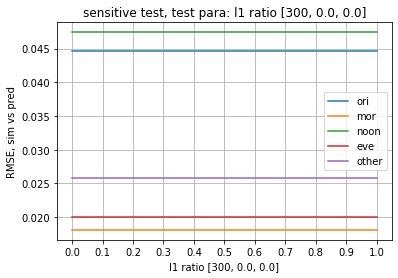

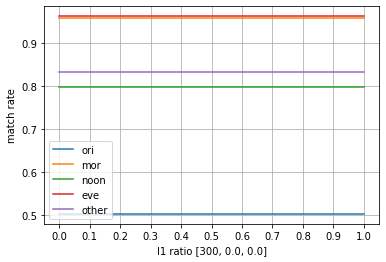

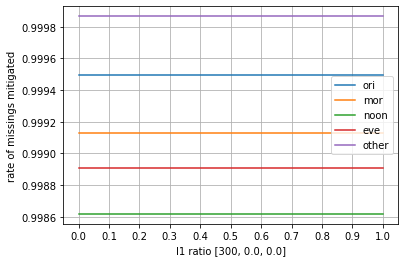

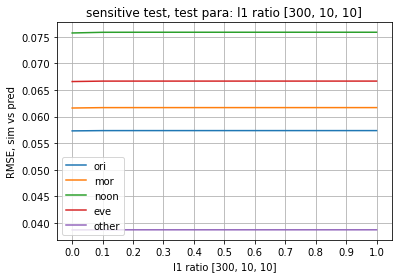

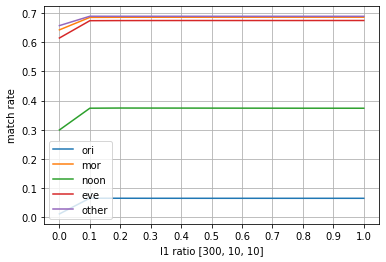

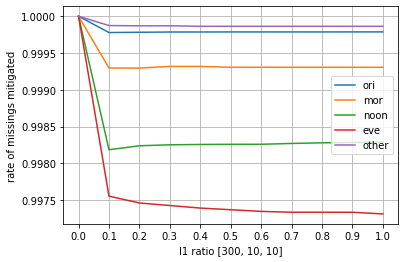

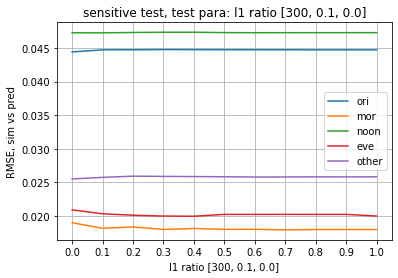

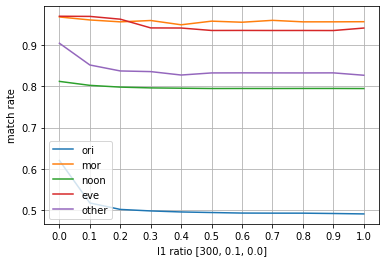

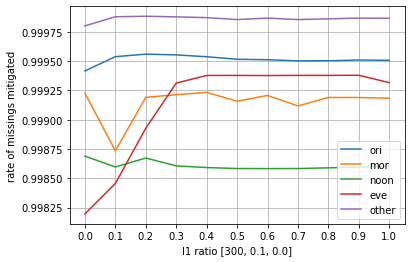

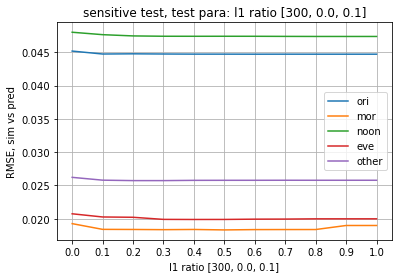

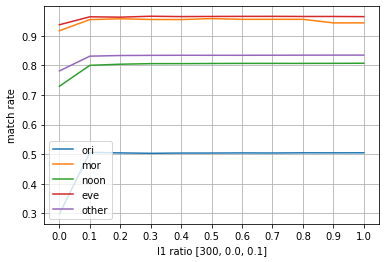

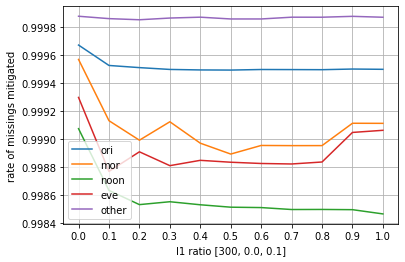

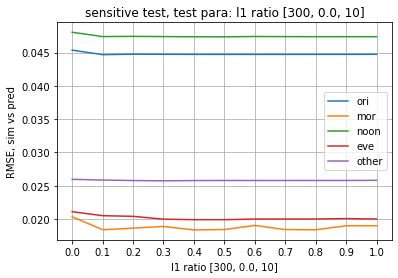

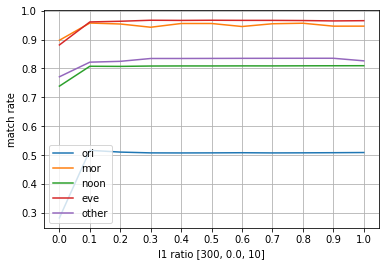

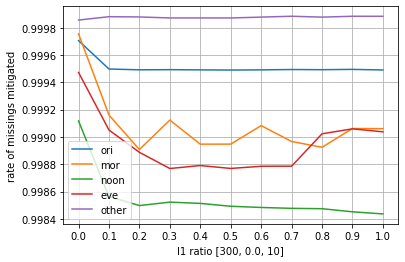

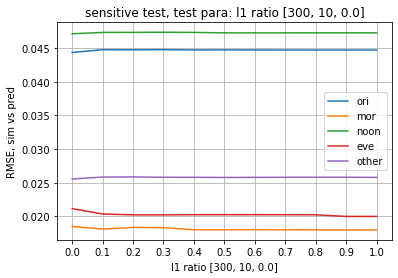

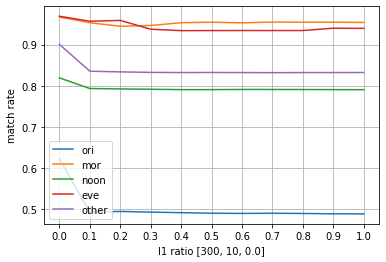

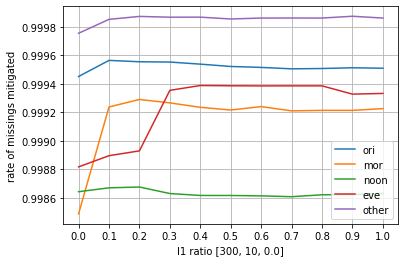

In [110]:
idx = plot_paras_sensitive(test_l1_nmf_1, l1_ratio_nmf_1, 'l1 ratio '+str(l1_ratio_nmf_1[0][:3]), 3, 1)
idx = plot_paras_sensitive(test_l1_nmf_2, l1_ratio_nmf_2, 'l1 ratio '+str(l1_ratio_nmf_2[0][:3]), 3, idx)
idx = plot_paras_sensitive(test_l1_nmf_3, l1_ratio_nmf_3, 'l1 ratio '+str(l1_ratio_nmf_3[0][:3]), 3, idx)
idx = plot_paras_sensitive(test_l1_nmf_4, l1_ratio_nmf_4, 'l1 ratio '+str(l1_ratio_nmf_4[0][:3]), 3, idx)
idx = plot_paras_sensitive(test_l1_nmf_5, l1_ratio_nmf_5, 'l1 ratio '+str(l1_ratio_nmf_5[0][:3]), 3, idx)
idx = plot_paras_sensitive(test_l1_nmf_6, l1_ratio_nmf_6, 'l1 ratio '+str(l1_ratio_nmf_6[0][:3]), 3, idx)

### BMF test

In [111]:
k_bmf =  generate_paralst(list(np.array(range(1, 21))*10), [0], [1.1, 1.1], 3)
k_bmf_100 =  generate_paralst(list(np.array(range(1, 11))*100), [0], [1.1, 1.1], 3)
#after check k, k=40
lw_bmf =  generate_paralst(list(np.array(range(0, 21))*0.2), [1], [40, 1.1], 3)
lh_bmf =  generate_paralst(list(np.array(range(0, 21))*0.2), [2], [40, 1.1], 3)
lwlh_bmf = generate_paralst(list(np.array(range(0, 21))*0.2), [1,2], [40], 3)

In [112]:
test_k_bmf = fit_model_get_para_sensitive(test_matrice_reverse, k_bmf,
                                          missing_val, 288, result_para_dict, 'BMF', True)
test_k_bmf_100 = fit_model_get_para_sensitive(test_matrice_reverse, k_bmf_100,
                                          missing_val, 288, result_para_dict, 'BMF', True)
test_lw_bmf = fit_model_get_para_sensitive(test_matrice_reverse, lw_bmf, 
                                          missing_val, 288, result_para_dict, 'BMF', True)
test_lh_bmf = fit_model_get_para_sensitive(test_matrice_reverse, lh_bmf, 
                                          missing_val, 288, result_para_dict, 'BMF', True)
test_lwlh_bmf = fit_model_get_para_sensitive(test_matrice_reverse, lwlh_bmf, 
                                          missing_val, 288, result_para_dict, 'BMF', True)

RMSE, data with missing rate>=0.0, para=[10, 1.1, 1.1], 0.056931489918811036
matched % compared with raw dt 0.012159259974536143
% of missings mitigated 1.0
RMSE, data with missing rate>=0.0, para=[10, 1.1, 1.1],mor, 0.054219034704644814
matched % compared with raw dtmor, 0.039340228602492026
% of missings mitigatedmor, 0.9999962771581314
RMSE, data with missing rate>=0.0, para=[10, 1.1, 1.1],noon, 0.07490415245042124
matched % compared with raw dtnoon, 0.022582185313935025
% of missings mitigatednoon, 1.0
RMSE, data with missing rate>=0.0, para=[10, 1.1, 1.1],eve, 0.05997625297972834
matched % compared with raw dteve, 0.04458422998399823
% of missings mitigatedeve, 0.9999845990951969
RMSE, data with missing rate>=0.0, para=[10, 1.1, 1.1],other, 0.035106271484682205
matched % compared with raw dtother, 0.06139132821951741
% of missings mitigatedother, 0.9998446907475363
RMSE, data with missing rate>=0.0, para=[20, 1.1, 1.1], 0.0569129439264087
matched % compared with raw dt 0.012167306

RMSE, data with missing rate>=0.0, para=[100, 1.1, 1.1],noon, 0.05562302287941052
matched % compared with raw dtnoon, 0.11921564525127677
% of missings mitigatednoon, 0.9994883827871262
RMSE, data with missing rate>=0.0, para=[100, 1.1, 1.1],eve, 0.06629512996622569
matched % compared with raw dteve, 0.014166160863727491
% of missings mitigatedeve, 1.0
RMSE, data with missing rate>=0.0, para=[100, 1.1, 1.1],other, 0.038618434285701886
matched % compared with raw dtother, 0.0033059979336182853
% of missings mitigatedother, 1.0
RMSE, data with missing rate>=0.0, para=[110, 1.1, 1.1], 0.04699145217221105
matched % compared with raw dt 0.1066209604737994
% of missings mitigated 0.9995416323891761
RMSE, data with missing rate>=0.0, para=[110, 1.1, 1.1],mor, 0.06139160827992912
matched % compared with raw dtmor, 0.012792727064646724
% of missings mitigatedmor, 1.0
RMSE, data with missing rate>=0.0, para=[110, 1.1, 1.1],noon, 0.05496690542515467
matched % compared with raw dtnoon, 0.127149854

RMSE, data with missing rate>=0.0, para=[190, 1.1, 1.1],other, 0.03862467394831245
matched % compared with raw dtother, 0.0033081260301317185
% of missings mitigatedother, 1.0
RMSE, data with missing rate>=0.0, para=[200, 1.1, 1.1], 0.044095118423842554
matched % compared with raw dt 0.11882760754187946
% of missings mitigated 0.9996732773880049
RMSE, data with missing rate>=0.0, para=[200, 1.1, 1.1],mor, 0.06144132067223125
matched % compared with raw dtmor, 0.012792727064646724
% of missings mitigatedmor, 1.0
RMSE, data with missing rate>=0.0, para=[200, 1.1, 1.1],noon, 0.049974972456448566
matched % compared with raw dtnoon, 0.12828714432856958
% of missings mitigatednoon, 0.9994784430833706
RMSE, data with missing rate>=0.0, para=[200, 1.1, 1.1],eve, 0.0663864786780693
matched % compared with raw dteve, 0.014166160863727491
% of missings mitigatedeve, 1.0
RMSE, data with missing rate>=0.0, para=[200, 1.1, 1.1],other, 0.03862503057267655
matched % compared with raw dtother, 0.003308

RMSE, data with missing rate>=0.0, para=[900, 1.1, 1.1],noon, 0.07542180310860555
matched % compared with raw dtnoon, 0.022582185313935025
% of missings mitigatednoon, 1.0
RMSE, data with missing rate>=0.0, para=[900, 1.1, 1.1],eve, 0.06643860131027146
matched % compared with raw dteve, 0.014173517997388217
% of missings mitigatedeve, 1.0
RMSE, data with missing rate>=0.0, para=[900, 1.1, 1.1],other, 0.038630781641943494
matched % compared with raw dtother, 0.0033081260301317185
% of missings mitigatedother, 1.0
RMSE, data with missing rate>=0.0, para=[1000, 1.1, 1.1], 0.05712022330725835
matched % compared with raw dt 0.01223883452784573
% of missings mitigated 1.0
RMSE, data with missing rate>=0.0, para=[1000, 1.1, 1.1],mor, 0.061485602589173
matched % compared with raw dtmor, 0.012792727064646724
% of missings mitigatedmor, 1.0
RMSE, data with missing rate>=0.0, para=[1000, 1.1, 1.1],noon, 0.07543111738379239
matched % compared with raw dtnoon, 0.022582185313935025
% of missings mit

RMSE, data with missing rate>=0.0, para=[40, 1.4, 1.1],eve, 0.06633136969409714
matched % compared with raw dteve, 0.014166160863727491
% of missings mitigatedeve, 1.0
RMSE, data with missing rate>=0.0, para=[40, 1.4, 1.1],other, 0.038618772555146515
matched % compared with raw dtother, 0.0033059979336182853
% of missings mitigatedother, 1.0
RMSE, data with missing rate>=0.0, para=[40, 1.6, 1.1], 0.056580197136281686
matched % compared with raw dt 0.019623174255754404
% of missings mitigated 0.9998969448714342
RMSE, data with missing rate>=0.0, para=[40, 1.6, 1.1],mor, 0.06142883103256039
matched % compared with raw dtmor, 0.012792727064646724
% of missings mitigatedmor, 1.0
RMSE, data with missing rate>=0.0, para=[40, 1.6, 1.1],noon, 0.0743105048832827
matched % compared with raw dtnoon, 0.022582185313935025
% of missings mitigatednoon, 1.0
RMSE, data with missing rate>=0.0, para=[40, 1.6, 1.1],eve, 0.06637184337762228
matched % compared with raw dteve, 0.014166160863727491
% of missi

RMSE, data with missing rate>=0.0, para=[40, 3.4, 1.1],noon, 0.07542056809789473
matched % compared with raw dtnoon, 0.022582185313935025
% of missings mitigatednoon, 1.0
RMSE, data with missing rate>=0.0, para=[40, 3.4, 1.1],eve, 0.06643669583531828
matched % compared with raw dteve, 0.014166160863727491
% of missings mitigatedeve, 1.0
RMSE, data with missing rate>=0.0, para=[40, 3.4, 1.1],other, 0.038630549453360224
matched % compared with raw dtother, 0.0033081260301317185
% of missings mitigatedother, 1.0
RMSE, data with missing rate>=0.0, para=[40, 3.6, 1.1], 0.057104411786796164
matched % compared with raw dt 0.01223481109537502
% of missings mitigated 1.0
RMSE, data with missing rate>=0.0, para=[40, 3.6, 1.1],mor, 0.06148416697106286
matched % compared with raw dtmor, 0.012792727064646724
% of missings mitigatedmor, 1.0
RMSE, data with missing rate>=0.0, para=[40, 3.6, 1.1],noon, 0.0754305383820364
matched % compared with raw dtnoon, 0.022582185313935025
% of missings mitigatedn

RMSE, data with missing rate>=0.0, para=[40, 1.1, 1.0],other, 0.03859236618211055
matched % compared with raw dtother, 0.0032985495958212695
% of missings mitigatedother, 1.0
RMSE, data with missing rate>=0.0, para=[40, 1.1, 1.2], 0.05067808025491659
matched % compared with raw dt 0.10000151996337782
% of missings mitigated 0.9996130544212382
RMSE, data with missing rate>=0.0, para=[40, 1.1, 1.2],mor, 0.0466017419291067
matched % compared with raw dtmor, 0.07105560562493742
% of missings mitigatedmor, 0.9997536035481089
RMSE, data with missing rate>=0.0, para=[40, 1.1, 1.2],noon, 0.06205602331974496
matched % compared with raw dtnoon, 0.10733713145358569
% of missings mitigatednoon, 0.9991736754016689
RMSE, data with missing rate>=0.0, para=[40, 1.1, 1.2],eve, 0.05143029036481107
matched % compared with raw dteve, 0.0861409994666078
% of missings mitigatedeve, 0.9994485323715523
RMSE, data with missing rate>=0.0, para=[40, 1.1, 1.2],other, 0.03859236282914053
matched % compared with ra

matched % compared with raw dt 0.030413573094144743
% of missings mitigated 0.9999995389291353
RMSE, data with missing rate>=0.0, para=[40, 1.1, 3.0],mor, 0.05974662414779613
matched % compared with raw dtmor, 0.026447362774129866
% of missings mitigatedmor, 1.0
RMSE, data with missing rate>=0.0, para=[40, 1.1, 3.0],noon, 0.0717804708981466
matched % compared with raw dtnoon, 0.08723874511823528
% of missings mitigatednoon, 0.9991962784902378
RMSE, data with missing rate>=0.0, para=[40, 1.1, 3.0],eve, 0.06466603614108195
matched % compared with raw dteve, 0.027957107910757967
% of missings mitigatedeve, 1.0
RMSE, data with missing rate>=0.0, para=[40, 1.1, 3.0],other, 0.038592386303603905
matched % compared with raw dtother, 0.0032985495958212695
% of missings mitigatedother, 1.0
RMSE, data with missing rate>=0.0, para=[40, 1.1, 3.2], 0.05551851828593879
matched % compared with raw dt 0.029906173554783057
% of missings mitigated 0.9999976958514727
RMSE, data with missing rate>=0.0, par

RMSE, data with missing rate>=0.0, para=[40, 0.6, 0.6],eve, 0.05071760877611278
matched % compared with raw dteve, 0.08597546395924148
% of missings mitigatedeve, 0.9995371730530078
RMSE, data with missing rate>=0.0, para=[40, 0.6, 0.6],other, 0.03113430794162843
matched % compared with raw dtother, 0.04885258356236972
% of missings mitigatedother, 0.9999709138097875
RMSE, data with missing rate>=0.0, para=[40, 0.8, 0.8], 0.05039516841649223
matched % compared with raw dt 0.10545148276897988
% of missings mitigated 0.9995007526191747
RMSE, data with missing rate>=0.0, para=[40, 0.8, 0.8],mor, 0.04636275196148798
matched % compared with raw dtmor, 0.07368782455688597
% of missings mitigatedmor, 0.9997644860390412
RMSE, data with missing rate>=0.0, para=[40, 0.8, 0.8],noon, 0.061876378466020135
matched % compared with raw dtnoon, 0.11211026350800395
% of missings mitigatednoon, 0.9993081978554134
RMSE, data with missing rate>=0.0, para=[40, 0.8, 0.8],eve, 0.05081058819883855
matched % co

matched % compared with raw dt 0.012235705191479622
% of missings mitigated 1.0
RMSE, data with missing rate>=0.0, para=[40, 2.6, 2.6],mor, 0.06147189728235882
matched % compared with raw dtmor, 0.012792727064646724
% of missings mitigatedmor, 1.0
RMSE, data with missing rate>=0.0, para=[40, 2.6, 2.6],noon, 0.07534666858937965
matched % compared with raw dtnoon, 0.022582185313935025
% of missings mitigatednoon, 1.0
RMSE, data with missing rate>=0.0, para=[40, 2.6, 2.6],eve, 0.06642402136563881
matched % compared with raw dteve, 0.014166160863727491
% of missings mitigatedeve, 1.0
RMSE, data with missing rate>=0.0, para=[40, 2.6, 2.6],other, 0.03862904546600992
matched % compared with raw dtother, 0.0033081260301317185
% of missings mitigatedother, 1.0
RMSE, data with missing rate>=0.0, para=[40, 2.8, 2.8], 0.057089947518732656
matched % compared with raw dt 0.012237046335636525
% of missings mitigated 1.0
RMSE, data with missing rate>=0.0, para=[40, 2.8, 2.8],mor, 0.061475505457744224


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

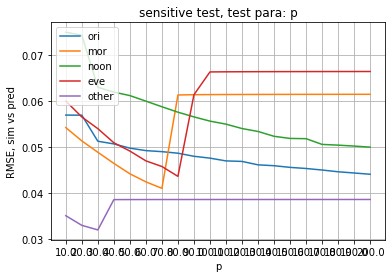

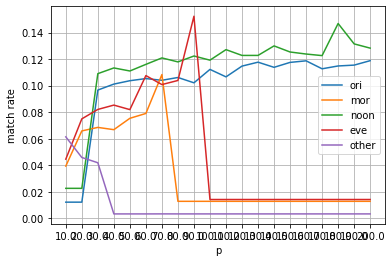

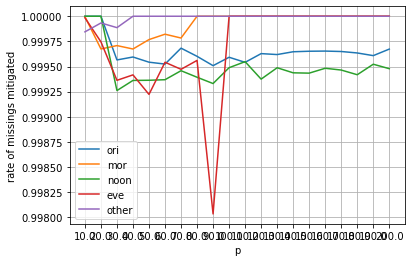

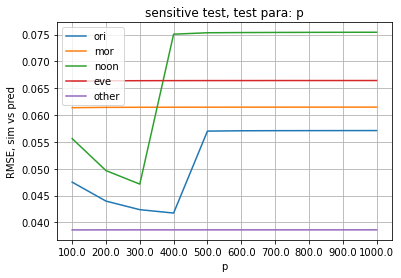

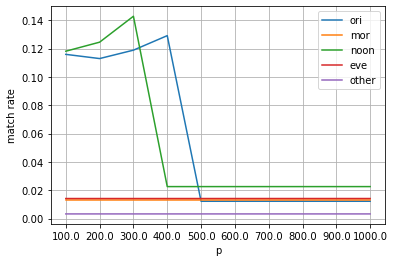

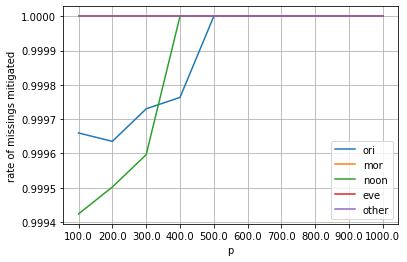

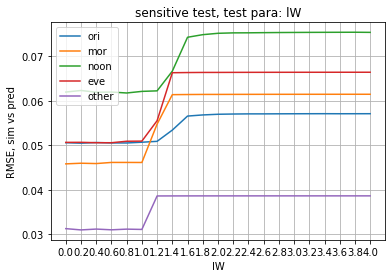

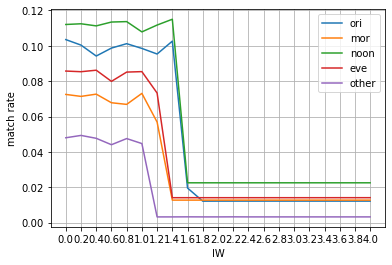

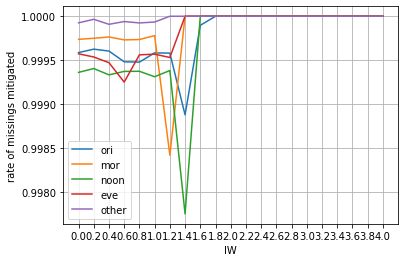

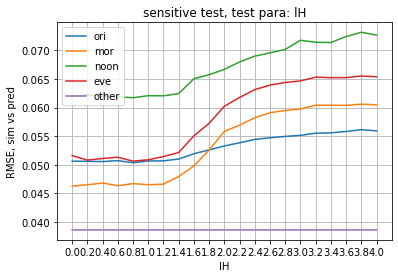

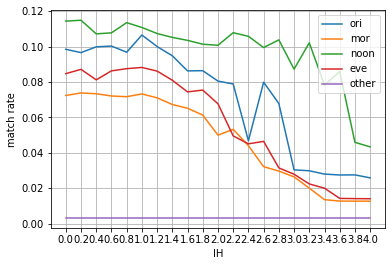

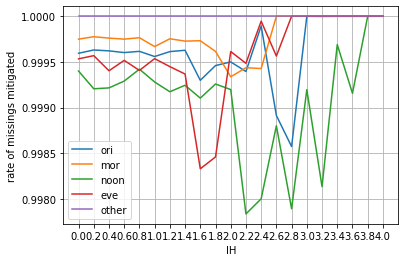

In [117]:
idx = plot_paras_sensitive(test_k_bmf, k_bmf, 'p', 0, 1)
idx = plot_paras_sensitive(test_k_bmf_100, k_bmf_100, 'p', 0, idx)
idx = plot_paras_sensitive(test_lw_bmf, lw_bmf, 'lW', 1, idx)
idx = plot_paras_sensitive(test_lh_bmf, lh_bmf, 'lH', 2, idx)
idx = plot_paras_sensitive(test_lwlh_bmf, lwlh_bmf, 1, 'lwlh', idx)

### SVD

In [49]:
k_svd = list(np.array(range(1, 21))*10)
k_svd_100 = (list(np.array(range(1, 11))*100))

In [19]:
missing_val = 0.0

In [27]:
k_svd_100

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [50]:
test_k_svd = fit_model_get_para(test_matrice_reverse, k_svd, 
                       missing_val, 288, 
                       result_para_dict, 'SVD',
                       True, True)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=10, 0.15167411629794555
matched % compared with raw dt 0.02512007710684806
% of missings mitigated 0.9998908609830307
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=10,mor, 0.16367598072612424
matched % compared with raw dtmor, 0.6488491194941561
% of missings mitigatedmor, 0.9996537184527325
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=10,noon, 0.18611027858998594
matched % compared with raw dtnoon, 0.3312357838719368
% of missings mitigatednoon, 0.999905745890922
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=10,eve, 0.21607944867533416
matched % compared with raw dteve, 0.6226011146057496
% of missings mitigatedeve, 0.9994639062713219
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=10,other, 0.08460165008296942
matched % compared with raw dtother, 0

if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=80,other, 0.059954876897525086
matched % compared with raw dtother, 0.693471106301613
% of missings mitigatedother, 0.9994098820458348
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=90, 0.13144947656344674
matched % compared with raw dt 0.10138289844498806
% of missings mitigated 0.9987179825213807
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=90,mor, 0.09168753174231675
matched % compared with raw dtmor, 0.695517359769967
% of missings mitigatedmor, 0.9980736929889472
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=90,noon, 0.1471388306517614
matched % compared with raw dtnoon, 0.3854153255225098
% of missings mitigatednoon, 0.9988347073893518
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=90,eve, 0.12672424462410511
matched % compared with raw dteve, 

if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=160,eve, 0.07877910369861922
matched % compared with raw dteve, 0.6822637900274053
% of missings mitigatedeve, 0.9993400868306802
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=160,other, 0.04705400926294471
matched % compared with raw dtother, 0.6852896392557195
% of missings mitigatedother, 0.9997700892932613
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=170, 0.11719529976447499
matched % compared with raw dt 0.09803406148520093
% of missings mitigated 0.999345262995117
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=170,mor, 0.05596960776620254
matched % compared with raw dtmor, 0.6955781583050799
% of missings mitigatedmor, 0.9995300751879699
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=170,noon, 0.12084462087542949
matched % compared with raw dtn

In [51]:
test_k_svd_100 = fit_model_get_para(test_matrice_reverse, k_svd_100, 
                       missing_val, 288, 
                       result_para_dict, 'SVD',
                       True, True)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=100, 0.1292786278439538
matched % compared with raw dt 0.09758164885627227
% of missings mitigated 0.9988521838725146
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=100,mor, 0.08624762977138334
matched % compared with raw dtmor, 0.6954923250790381
% of missings mitigatedmor, 0.9983439819599736
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=100,noon, 0.1433722430760357
matched % compared with raw dtnoon, 0.3872352581434273
% of missings mitigatednoon, 0.9988246803984268
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=100,eve, 0.11886652419113196
matched % compared with raw dteve, 0.6778568669646305
% of missings mitigatedeve, 0.996631381818597
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.0, k=100,other, 0.05603822205763174
matched % compared with raw dtother

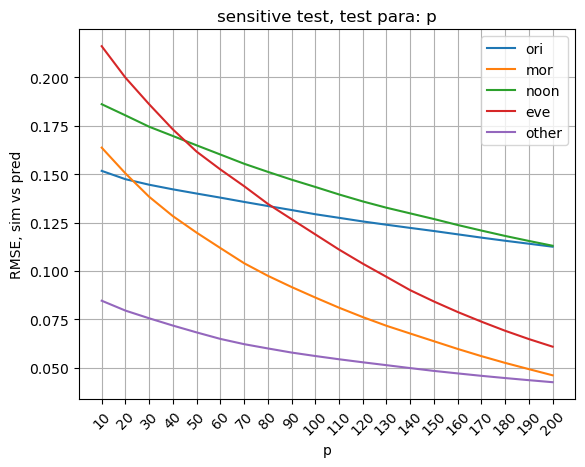

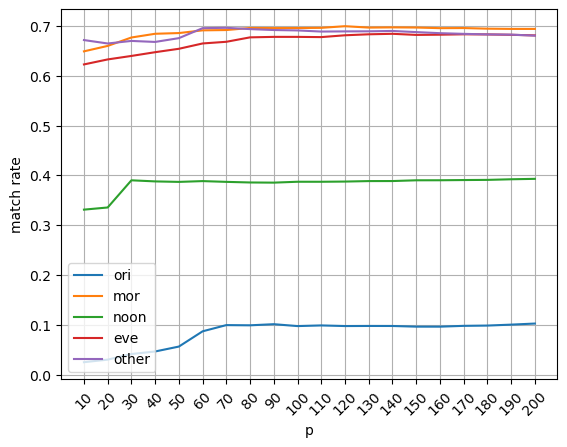

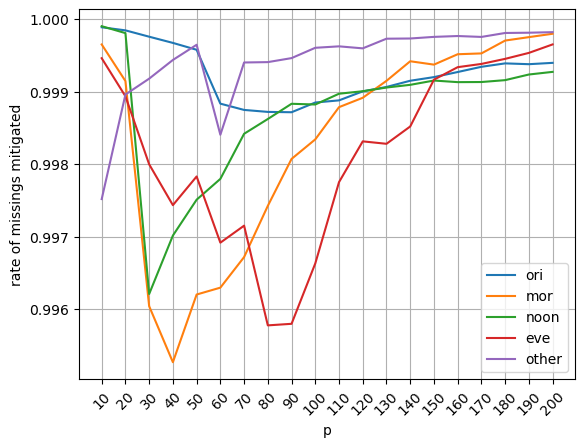

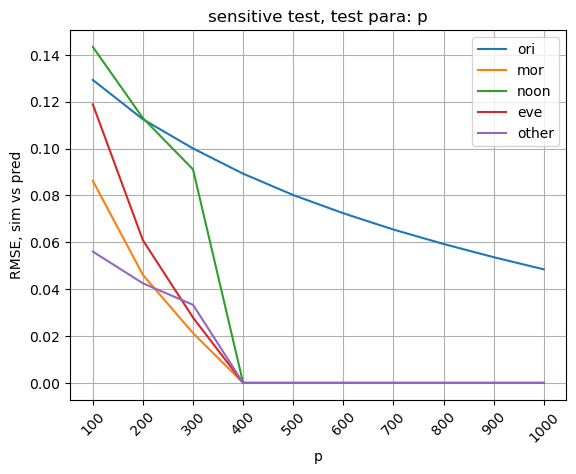

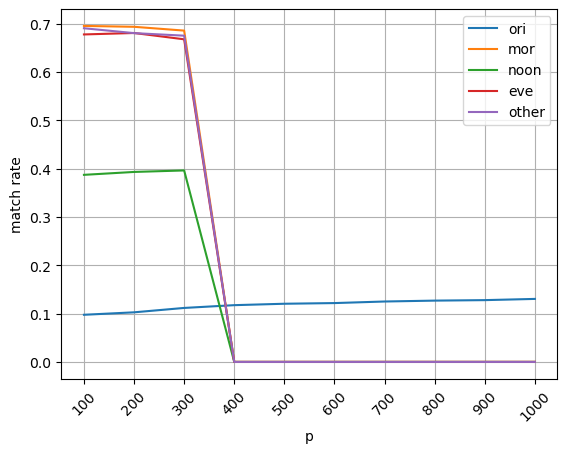

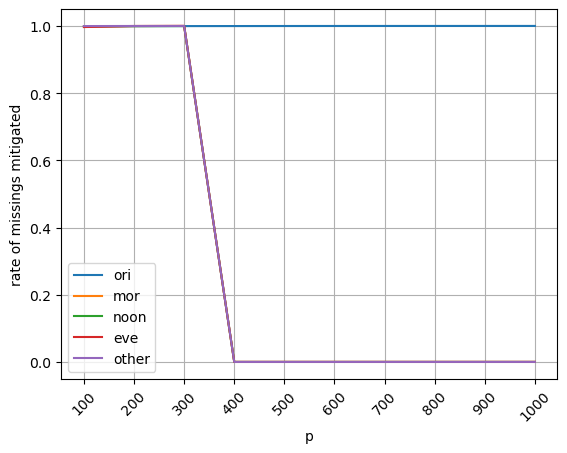

In [52]:
idx = plot_paras_sensitive_svd(test_k_svd, k_svd, 'p', 1)
idx = plot_paras_sensitive_svd(test_k_svd_100, k_svd_100, 'p', idx)

### NMF with zero loss

In [60]:
#prediction based on time
#prediction based on time

def zero_est_eval(est_matrix, zero_index):
    zero_est = np.count_nonzero(np.round(np.multiply(np.round(est_matrix,0), zero_index),0))
    #print(zero_est)
    zero_est_index = 1 - zero_est/np.count_nonzero(zero_index)
    return(zero_est_index)

def get_rmse(test_matrix, est_matrix, zero_index):
    pred_rmse = mean_squared_error(test_matrix, est_matrix, squared=False)
    
    test = test_matrix.copy()    
    test = test - np.multiply(test, zero_index)
    est = est_matrix.copy()
    est = np.round(est - np.multiply(est, zero_index),0)
    
    zero_rmse = mean_squared_error(test, est, squared=False)

    return(pred_rmse, zero_rmse) 

def fit_process_dt_mf01_sensitive_w0(dt, missing_info, missing_val, para_lst, Zero_index): 
    #convert data into matrix
    result_para = []
    fit_dt = dt[np.where(missing_info>=missing_val)[0],]
   
    #predict data based on missing_rate
    
    #para_lst = [k_val, alpha_W, alpha_H, l1_ratio, zero_weight]        
    model = NMF_w0(n_components=para_lst[0], init='random', random_state=0,
                   alpha_W = para_lst[1], alpha_H = para_lst[2],
                   l1_ratio = para_lst[3], zero_weight=para_lst[4], 
                   beta_loss='kullback-leibler',
                   solver="zero")
    W = model.fit_transform_w0(fit_dt, Zero_index)
    H = model.components_
    WH = np.dot(W, H)
        
    #check if the model fit the data well    
    if True in np.isnan(W) or True in np.isnan(H):
        print('Error, fitting data failed')
        del(W, H)
        return([0,0,0,0])
        
    else:
        pred_dt = np.dot(W, H)
        pred_dt = np.array(pred_dt)
    
        model_rmse, model_rmse_zero = get_rmse(fit_dt, pred_dt, Zero_index)
        zero_val = zero_est_eval(pred_dt, Zero_index)

        print('RMSE, data with missing rate>='+str(missing_val)+', para='+str(para_lst)+',', model_rmse)
        print('RMSE, zero, data with missing rate>='+str(missing_val)+', para='+str(para_lst)+',', model_rmse_zero)
        print('zero_val'+', para='+str(para_lst)+',', zero_val)

        WH_max, WH_index = get_pred_dt(pred_dt, 288)
        match_per, mitigate_miss_per = check_pred_index(fit_dt, WH_index)

        result_para = [model_rmse, model_rmse_zero, zero_val, match_per, mitigate_miss_per]    

        del(W, H, pred_dt)
        return(result_para)


#para_lst_nmf = [k_val, alpha_W, alpha_H, l1_ratio]
#para_lst_bmf = [k_val, lambda_w, lambda_h]    
def fit_dtbytime_sensitive_w0(dt, 
                           missing_info, missing_val, time_interval, 
                           para_lst, Zero_index):
     
    test_dt = dt
    num_time = 288
    num_taz = int(dt.shape[1]/num_time)    
    #predict data based on missing_rate
    
    fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    
    null_idx = 0
    result_para = {}
    for ky in time_dict:
        result_para[ky] = []
        #print(ky)
        input_dt = fit_dt[:, time_dict[ky]]
        input_dt_tru = fit_dt_tru[:, time_dict[ky]]
        zero_dt = Zero_index[:, time_dict[ky]]

        #para_lst_nmf = [k_val, alpha_W, alpha_H, l1_ratio]
        NMF_w0(n_components=para_lst[0], init='random', random_state=0,
               alpha_W = para_lst[1], alpha_H = para_lst[2],
               l1_ratio = para_lst[3], zero_weight=para_lst[4], 
               beta_loss='kullback-leibler',
               solver="zero")
        W = model.fit_transform_w0(input_dt, zero_dt)
        H = model.components_
        WH = np.dot(W, H)
        
        if True in np.isnan(W) or True in np.isnan(H):
            print('Error, fitting data failed')
            null_idx = 1
            del(W, H)
            result_para[ky] = [0,0,0,0]
        
        else:
            #print(WH.shape)
            pred_dt = np.dot(W, H)
            pred_dt = np.array(pred_dt)
            
            WH_max, WH_index = get_pred_dt_time(pred_dt, num_taz)
            #print(WH_max.shape, WH_index.shape)

            
            model_rmse, model_rmse_zero = get_rmse(input_dt, pred_dt, zero_dt)
            zero_val = zero_est_eval(pred_dt, zero_dt)

            print('RMSE, data with missing rate>='+str(missing_val)+', para='+str(para_lst)+','+ky+',', model_rmse)
            print('RMSE, zero, data with missing rate>='+str(missing_val)+', para='+str(para_lst)+','+ky+',', model_rmse_zero)
            print('zero_val'+', para='+str(para_lst)+',', zero_val)

            match_per, mitigate_miss_per = check_pred_indexbytime(input_dt, WH_index, num_taz, ky)

            del(WH_max, WH_index, pred_dt)
            #pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
            #pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')
            result_para[ky] = [model_rmse, model_rmse_zero, zero_val, match_per, mitigate_miss_per]
    
    return(result_para)    

def get_pred_dt_time(WH_pred, num_taz):
    #print('num taz', num_taz)
    time_interval = int(WH_pred.shape[1]/num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T) 


def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def add_result2dict(result_para, result_para_time, result_para_dict):
    result_para_dict = add_val_w0(result_para, 'ori', result_para_dict)
    result_para_dict = add_val_w0(result_para_time['mor'], 'mor', result_para_dict)
    result_para_dict = add_val_w0(result_para_time['noon'], 'noon', result_para_dict)
    result_para_dict = add_val_w0(result_para_time['eve'], 'eve', result_para_dict)
    result_para_dict = add_val_w0(result_para_time['other'], 'other', result_para_dict)
    return(result_para_dict)
    
    
def add_val_w0(result_val, ky, result_para_dict):    
    result_para_dict[ky]['rmse_predvssim'].append(result_val[0])
    result_para_dict[ky]['rmse_predvszero'].append(result_val[1])
    result_para_dict[ky]['per of zero val'].append(result_val[2])
    result_para_dict[ky]['per of match'].append(result_val[3])
    result_para_dict[ky]['per of missings mitigated'].append(result_val[4])
    return(result_para_dict)


def fit_model_get_para_sensitive_w0(fcd_dt, check_col, para_lst, missing_val, time_interval, result_para_dict, Zero_index):
    missing_info = check_missings(fcd_dt, check_col, time_interval, False)
    result_para_dict_return = copy.deepcopy(result_para_dict)
    for paras in para_lst:
        result_para = fit_process_dt_mf01_sensitive_w0(fcd_dt, 
                                                  missing_info, missing_val,  
                                                  paras, Zero_index)
        result_para_time = fit_dtbytime_sensitive_w0(fcd_dt, 
                                        missing_info, missing_val, 12, 
                                        paras, Zero_index)
        result_para_dict_return = add_result2dict(result_para, result_para_time, result_para_dict_return)
        #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))
    return(result_para_dict_return)


def plot_paras_sensitive(result_para_dict, xval, paras_intest, para_loc, idx):
    xval = np.array(xval)[:, para_loc]
    x_val = []
    for x in xval:
        if x < 1:
            x_val.append(round(x, 2))
        else: 
            x_val.append(x)

    #convert xval from number to string
    xval = list(map(str, list(x_val)))
    for ky in result_para_dict:
        #plt.figure(idx)
        paras = list(result_para_dict[ky].keys())
        #print(paras)
        #fig.tight_layout()
        
        #ax[0].set_title('RMSE')
        #print(result_para_dict[ky][paras[0]])
        plt.figure(idx)
        plt.title('sensitive test, test para: '+paras_intest)
        plt.plot(xval, result_para_dict[ky][paras[0]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.xticks(rotation=45)
        plt.ylabel('RMSE, sim vs pred')
        #ax[0, 0].legend()
        plt.legend()
        
        plt.figure(idx+1)
        plt.plot(xval, result_para_dict[ky][paras[1]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.xticks(rotation=45)
        plt.ylabel('RMSE, sim pred vs sim zero')
        #ax[0, 1].legend()
        plt.legend()
        
        plt.figure(idx+2)
        plt.plot(xval, result_para_dict[ky][paras[2]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.xticks(rotation=45)
        plt.ylabel('zero_val')
        #ax[0, 1].legend()
        plt.legend()
        
        plt.figure(idx+3)
        plt.plot(xval, result_para_dict[ky][paras[3]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.xticks(rotation=45)
        plt.ylabel('match per')
        #label = f"({x},{y})"
        plt.legend()  
        
        plt.figure(idx+4)
        plt.plot(xval, result_para_dict[ky][paras[4]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.xticks(rotation=45)
        plt.ylabel('rate'+paras[4][3:])
        #label = f"({x},{y})"
        plt.legend()  

    return(idx+5) 

def generate_paralst(test_valrange, val_loc, other_val, para_len):
    para_lst = []
    add_para_cb = []
    idx = 0
    if len(val_loc) == 1:
        for i in range(para_len):
            if i in val_loc:
                add_para_cb.append(0)
            else:
                add_para_cb.append(other_val[idx])
                idx += 1
        #print(add_para_cb)        
        for j in range(len(test_valrange)):
            add_para_cb_cur = copy.deepcopy(add_para_cb)
            add_para_cb_cur[val_loc[0]] = test_valrange[j]
            para_lst.append(add_para_cb_cur)
        
    else:
        add_para_cb = np.zeros(para_len)
        idx = 0
        for i in range(para_len):
            if i not in val_loc:
                add_para_cb[i] = other_val[idx]
                idx += 1
        for j in range(len(test_valrange)):
            add_para_cb_cur = copy.deepcopy(add_para_cb)
            add_para_cb_cur[val_loc] = test_valrange[j]
            para_lst.append(list(add_para_cb_cur))
    
    #conver type k to int
    for i in range(len(para_lst)):
        para_lst[i][0] = int(para_lst[i][0])    
    
    return(para_lst)

In [61]:
result_para_dict_w0 = {'ori':{'rmse_predvssim':[],                            
                                'rmse_predvszero':[],
                                'per of zero val':[],
                                'per of match':[],
                                'per of missings mitigated':[]},
                       'mor':{'rmse_predvssim':[],                            
                                'rmse_predvszero':[],
                                'per of zero val':[],
                                'per of match':[],
                                'per of missings mitigated':[]},
                       'noon':{'rmse_predvssim':[],                            
                                'rmse_predvszero':[],
                                'per of zero val':[],
                                'per of match':[],
                                'per of missings mitigated':[]},
                       'eve':{'rmse_predvssim':[],                            
                                'rmse_predvszero':[],
                                'per of zero val':[],
                                'per of match':[],
                                'per of missings mitigated':[]},
                       'other':{'rmse_predvssim':[],                            
                                'rmse_predvszero':[],
                                'per of zero val':[],
                                'per of match':[],
                                'per of missings mitigated':[]}
              }

In [ ]:
k_nmf = generate_paralst(list(np.array(range(1, 21))*10), [0], [0, 0, 0, 0.5], 5)
k_nmf_100 = generate_paralst(list(np.array(range(1, 11))*100), [0], [0, 0, 0.5], 5)

In [ ]:
#'sim_t', k_nmf_100, 0.05, 288, result_para_dict, 'NMF'
test_k_nmf = fit_model_get_para_sensitive_w0(test_matrice_reverse, k_nmf, 
                                             0.0, 288, result_para_dict_w0,
                                             Zero_index)

test_k_nmf_100 = fit_model_get_para_sensitive_w0(test_matrice_reverse, k_nmf_100, 
                                             0.0, 288, result_para_dict_w0,
                                             Zero_index)

idx = plot_paras_sensitive_w0(test_k_nmf, k_nmf, 'p', 0, 1)
idx = plot_paras_sensitive_w0(test_k_nmf_100, k_nmf_100, 'p', 0, 1)